# Introduction
This notebook demonstrates the following processes:
1. Reading in Hector-processed data
2. Calculating RMS and WRMS values
3. Visualising Hector-derived parameters as well as RMS and WRMS values.

The workflow includes: 
- Reading `.mom` files for each GNSS station and displacement component into Pandas DataFrames
- Cleaning data and calculating metrics
- Visualising results

**Requirements**: Python ≥ 3.8 with packages `pandas`, `numpy`, `matplotlib`, `seaborn`, and `cmcrameri`  
**Note**: Ensure that the file paths are set correctly for your environment.

In [1]:
import urllib.request

import pandas as pd
from glob import glob
import os
import re
import json

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy as np

from datetime import datetime, timezone, timedelta
from cmcrameri import cm
import seaborn as sns

# Helper functions
This section includes a set of helper functions to support the processing of station data.
   
- **`datetime_to_mjd(date_obj)` / `mjd_to_datetime(mjd)`**  
  Convert between Python `datetime` objects and Modified Julian Dates (MJD). These functions allow consistent time handling when reading, merging, or processing time series data from different sources.
- **`load_station_data(base_code, suffix='_o', residual_label=None)`**
  Load Hector-processed GNSS displacement time series for all three components (east, north, up), from `.mom` files for a given station-correction combination. Calculates residuals between observed and modelled values.
- **`merge_all_corrections(station, dataset)`**
  Combine all available NTL-corrected GNSS displacement time series for a station-dataset pair into a single DataFrame. Reads each correction using `load_station_data` and merges them by date, preserving original and residual columns for later comparison.

**Note**: Not all functions used in this notebook are defined here; some are introduced later in the notebook.

In [2]:
def datetime_to_mjd(date_obj):
    """
    Convert a datetime or ISO-format string to Modified Julian Date (MJD).

    Parameters:
    - date_obj: datetime object or string in "YYYY-MM-DD" or "YYYY-MM-DDTHH:MM:SS" format.

    Returns:
    - mjd: float representing Modified Julian Date
    """
    if isinstance(date_obj, str):
        try:
            # Try parsing as ISO format (with time)
            date_obj = datetime.strptime(date_obj, "%Y-%m-%dT%H:%M:%S")
        except ValueError:
            try:
                # Fall back to date-only format
                date_obj = datetime.strptime(date_obj, "%Y-%m-%d")
            except ValueError as e:
                raise ValueError(f"Unsupported date format. Expected '%Y-%m-%dT%H:%M:%S' or '%Y-%m-%d'. Got: {date_obj}") from e
    
    unix_epoch = datetime(1970, 1, 1)
    jd = 2440587.5 + (date_obj - unix_epoch).total_seconds() / 86400
    mjd = jd - 2400000.5
    return mjd


def mjd_to_datetime(mjd):
    """
    Convert Modified Julian Date (MJD) to a Python datetime object in UTC.

    Parameters: 
    - mjd: float representing Modified Julian Date

    Returns: 
    - date_obj: datetime object in UTC
    """
    mjd = mjd + 2400000.5  # Convert MJD to Julian Date
    unix_epoch = datetime(1970, 1, 1, tzinfo=timezone.utc)
    date_obj = unix_epoch + timedelta(days=(mjd - 2440587.5))  # Convert JD to UTC datetime
    return date_obj  # Return datetime object instead of string


def load_station_data(base_code, suffix='_o', residual_label=None):
    """
    Load Hector-processed .mom files for all three GNSS components (east, north, up) for a given station/correction.

    Parameters:
    - base_code: Base filename code representing the station, dataset, and correction code (e.g., "ASG01").
    - suffix: Suffix to append to component column names when reading data (default is '_o').
    - residual_label: If provided, computes residuals between the observed component (`suffix`) and the modeled component (`_m`)
      and stores them as new columns named '{component_initial}_res_{residual_label}'.

    Returns:
    - DataFrame containing date, MJD, component displacements (and optionally residuals),
      or None if any of the component files are missing.
    """
    dfs = []
    for idx, comp in enumerate(components):
        file_path = os.path.join(input_dir, f"{base_code}_{idx}.mom")
        if not os.path.isfile(file_path):
            return None
        df = pd.read_csv(file_path, sep='\\s+', names=['MJD', f'{comp}{suffix}', f'{comp}_m'], comment='#')
        df['date'] = df['MJD'].apply(lambda x: mjd_to_datetime(x).strftime('%Y-%m-%d') if pd.notna(x) else None)
        dfs.append(df)

    if len(dfs) != 3:
        return None

    merged_df = dfs[0]
    for df in dfs[1:]:
        merged_df = pd.merge(merged_df, df, on='date')

    if residual_label:
        for comp in components:
            merged_df[f'{comp[0]}_res_{residual_label}'] = merged_df[f'{comp}{suffix}'] - merged_df[f'{comp}_m']

    return merged_df[['date', 'MJD'] + [f'{comp[0]}_res_{residual_label}' for comp in components]] if residual_label else merged_df



def merge_all_corrections(station, dataset):
    """
    Merge Hector-processed GNSS data for all available non-tidal loading (NTL) corrections
    for a given station–dataset combination.

    Parameters:
    - station: Station identifier (e.g., 'aboa', 'syog', 'vesl').
    - dataset: Dataset identifier (e.g., 'gr', 'ngl', 'tud', 'osu', 'ay').

    Returns:
    - Combined DataFrame containing original and residual time series for each correction,
      merged on 'date'. Returns None if no corrections are found.
    """
    station_code = station_map[station]
    dataset_code = dataset_map[dataset]

    final_df = None

    for corr_label, corr_code in correction_map.items():
        base_code = f"{station_code}{dataset_code}{corr_code}"
        df = load_station_data(base_code, suffix='_o', residual_label=corr_label)
        if df is None:
            print(f"Missing data for {base_code}")
            continue
        if final_df is None:
            final_df = df
        else:
            # Drop 'MJD' column from this correction dataframe to avoid conflicts
            df = df.drop(columns=['MJD'], errors='ignore')
            final_df = pd.merge(final_df, df, on='date', how='outer')

    return final_df

# Read in data
First, the GNSS time series are read in. This includes:
1. **Original GNSS data** – Original GNSS time series, which contains formal error values needed to calculate WRMS of the residuals.
2. **Processed GNSS data** – Hector-processed data in `.mom` format, which contains time series that have been corrected (or left uncorrected) for NTL effects.



***What does Hector do?***

Hector is an open-source academic software package for estimating trajectory models, such as linear trends with annual and semi-annual signals, in time series data that contain temporally correlated noise. In geophysical applications, correlated noise is common in GNSS displacement time series and can strongly influence the accuracy of estimated trends. Hector addresses this by using Maximum Likelihood Estimation (MLE) to simultaneously estimate the trajectory parameters and the characteristics of the chosen noise model.  

Key capabilities include:
- Correct handling of missing data without interpolation or zero-padding.  
- Inclusion of yearly, half-yearly, and other periodic signals in the trend estimation.  
- Estimation of offsets at specified epochs.  
- Support for multiple noise models (e.g., power-law, ARFIMA, generalized Gauss–Markov, white noise) and their combinations.  
- Tools for outlier removal, offset detection, and power spectral density analysis.  

Hector is widely used in GNSS research to extract reliable trends, seasonal amplitudes, and noise parameters from multi-component (east, north, up) time series. Its results have been validated against other established software, such as CATS and est_noise, with equivalent outputs.  

*Reference*:  
Bos, M.S., Fernandes, R.M.S., Williams, S.D.P., and Bastos, L. (2013). Fast Error Analysis of Continuous GNSS Observations with Missing Data. *Journal of Geodesy*, 87(4), 351–360. https://doi.org/10.1007/s00190-012-0605-0

## 1. Original GNSS data

In [3]:
# GR

column_names = ['date', 'x', 'y', 'z','std_x', 'std_y', 'std_z', 'corr_xy', 'corr_xz', 'corr_yz', 'dis_n', 'dis_e', 'dis_u']

aboa_gr = pd.read_csv('GNSS/ABOA_GR.tab', sep='\t', names=column_names, header=None, skiprows=1)
syog_gr = pd.read_csv('GNSS/SYOG_GR.tab', sep='\t', names=column_names, header=None, skiprows=1)
vesl_gr= pd.read_csv('GNSS/VESL_GR.tab', sep='\t', names=column_names, header=None, skiprows=1)

# Convert displacement to mm
for i, df in enumerate([aboa_gr, syog_gr, vesl_gr]):
    df[['std_x', 'std_y', 'std_z']] *= 1000  # Convert meters to mm
    df['MJD'] = df['date'].apply(lambda x: datetime_to_mjd(x) if pd.notna(x) else None)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')  # Convert to datetime, handle errors
    df['date'] = df['date'].dt.strftime('%Y-%m-%d')
    df = df[(df['date'] >= '2003-02-01') & (df['date'] <= '2023-12-31')].copy()

    
    # Save back to original variable
    if i == 0:
        aboa_gr = df
    elif i == 1:
        syog_gr = df
    else:
        vesl_gr = df


In [4]:
# NGL
# column names
columns = ['station', 'date', 'decimal_year', 'x', 'y', 'z', 'std_x', 'std_y', 'std_z', 'corr_xy', 'corr_yz', 'corr_xz', 'antenna_height']

syog_ngl = pd.read_csv('GNSS/SYOG_NGL.txyz2.txt', sep='\\s+', names=columns)
vesl_ngl = pd.read_csv('GNSS/VESL_NGL.txyz2.txt', sep='\\s+', names=columns)

for i, df in enumerate([syog_ngl, vesl_ngl]):
    df[['std_x', 'std_y', 'std_z']] *= 1000  # Convert meters to mm
    df['date'] = pd.to_datetime(df['date'], format='%y%b%d', errors='coerce')  # Convert to datetime, handle errors
    df['date'] = df['date'].dt.strftime('%Y-%m-%d')
    df['MJD'] = df['date'].apply(lambda x: datetime_to_mjd(x) if pd.notna(x) else None)
    df = df[(df['date'] >= '2003-02-01') & (df['date'] <= '2023-12-31')].copy()

    # Save back to original variable
    if i == 0:
        syog_ngl = df
    else:
        vesl_ngl = df
        

In [5]:
# TUD
# original GNSS data
column_names = ['station', 'date', 'flag', 'x', 'y', 'z', 'std_x', 'std_y', 'std_z','cor_XY', 'cor_XZ', 'cor_YZ', 'weight']

aboa_tud = pd.read_csv('GNSS/ABOA_TUD.xyz', sep='\\s+', names=column_names, skiprows=7)
syog_tud = pd.read_csv('GNSS/SYOG_TUD.xyz', sep='\\s+', names=column_names, skiprows=7)
vesl_tud = pd.read_csv('GNSS/VESL_TUD.xyz', sep='\\s+', names=column_names, skiprows=7)

# Convert date to MJD and filter by date range
for i, df in enumerate([aboa_tud, syog_tud, vesl_tud]):
    df[['std_x', 'std_y', 'std_z']] *= 1000  # Convert meters to mm
    df['MJD'] = df['date'].apply(lambda x: datetime_to_mjd(x) if pd.notna(x) else None)
    df = df[(df['date'] >= '2003-02-01') & (df['date'] <= '2023-12-31')].copy()
    
    # Save back to original variable
    if i == 0:
        aboa_tud = df
    elif i == 1:
        syog_tud = df
    else:
        vesl_tud = df


In [6]:
# OSU
# This dataset is missing formal error values so no need to read it in again

In [7]:
# AY
column_names = ['decimal-year', 'east', 'north', 'up', 'std_x', 'std_y', 'std_z', 'corrEN', 'corrEU', 'corrNU', 'julian-sec', 'year', 'month', 'day', 'hour', 'minute', 'second']

aboa_ay = pd.read_csv('GNSS/ABOA_AY.series', sep='\\s+', names=column_names)
syog_ay = pd.read_csv('GNSS/SYOG_AY.series', sep='\\s+', names=column_names)
vesl_ay = pd.read_csv('GNSS/VESL_AY.series', sep='\\s+', names=column_names)

# Convert displacement to mm
for i, df in enumerate([aboa_ay, syog_ay, vesl_ay]):
    df[['std_x', 'std_y', 'std_z']] *= 1000  # Convert meters to mm  
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1) + ' 12:00:00')
    
    # Group by date first
    df = df.groupby('date', as_index=False).mean(numeric_only=True)
    
    # MJD and date formatting
    df['MJD'] = df['date'].apply(lambda x: datetime_to_mjd(x) if pd.notna(x) else None)
    df['date'] = df['date'].dt.strftime('%Y-%m-%d')
    df = df[(df['date'] >= '2003-02-01') & (df['date'] <= '2023-12-31')].copy()
    
    # Normalize displacements AFTER grouping
    df['east'] -= df['east'].iloc[0]
    df['north'] -= df['north'].iloc[0]
    df['up'] -= df['up'].iloc[0]
 
    # Save back to original variable
    if i == 0:
        aboa_ay = df
    elif i == 1:
        syog_ay = df
    else:
        vesl_ay = df


## 2. Processed GNSS data

In [8]:
# Codes on how the files were named 
station_map = {
    'ABOA': 'A',
    'SYOG': 'S',
    'VESL': 'V'
}
dataset_map = {
    'GR': 'G',
    'NGL': 'N',
    'TUD': 'T',
    'OSU': 'O',
    'AY': 'A'
}
correction_map = {
    'Original': '00',
    'EOST6': '01',
    'GFZ4': '02',
    'GFZ5': '03',
    'EOST1': '04',
    'EOST3': '05',
    'EOST2': '06',
    'GFZ1': '07',
    'EOST4': '08',
    'EOST5': '09',
    'GFZ2': '10',
    'GFZ3': '11'
}

# Components and output
components = ['east', 'north', 'up']
input_dir = 'hector/processed_all'

In [9]:
all_merged = {}

# Read in data
for station in ['ABOA', 'SYOG', 'VESL']:
    for dataset in ['GR', 'NGL', 'TUD', 'OSU', 'AY']:
        key = f"{station}_{dataset}"
        df = merge_all_corrections(station, dataset)
        if df is not None:
            all_merged[key] = df
        else:
            print(f"Failed to load: {key}")

all_merged.keys()

Missing data for AG04
Missing data for AG05
Missing data for AG06
Missing data for AG07
Missing data for AG08
Missing data for AG09
Missing data for AG10
Missing data for AG11
Missing data for AN00
Missing data for AN01
Missing data for AN02
Missing data for AN03
Missing data for AN04
Missing data for AN05
Missing data for AN06
Missing data for AN07
Missing data for AN08
Missing data for AN09
Missing data for AN10
Missing data for AN11
Failed to load: ABOA_NGL
Missing data for AT01
Missing data for AT02
Missing data for AT03
Missing data for AO01
Missing data for AO02
Missing data for AO03
Missing data for AA01
Missing data for AA02
Missing data for AA03
Missing data for SG04
Missing data for SG05
Missing data for SG06
Missing data for SG07
Missing data for SG08
Missing data for SG09
Missing data for SG10
Missing data for SG11
Missing data for SN01
Missing data for SN02
Missing data for SN03
Missing data for ST01
Missing data for ST02
Missing data for ST03
Missing data for SO01
Missing

dict_keys(['ABOA_GR', 'ABOA_TUD', 'ABOA_OSU', 'ABOA_AY', 'SYOG_GR', 'SYOG_NGL', 'SYOG_TUD', 'SYOG_OSU', 'SYOG_AY', 'VESL_GR', 'VESL_NGL', 'VESL_TUD', 'VESL_OSU', 'VESL_AY'])

In [10]:
# Read in and make a DataFrame from Hector derived parameters
# Reverse lookup for dataset and correction
station_rev = {v: k for k, v in station_map.items()}
dataset_rev = {v: k for k, v in dataset_map.items()}
correction_rev = {v: k for k, v in correction_map.items()}

# Components lookup
component_map = {
    "0": "East",
    "1": "North",
    "2": "Up"
}

# Read JSON
with open("hector/hector_estimatetrend.json", "r") as f:
    data = json.load(f)

rows = []
for key, vals in data.items():
    # Example key: "AA00_0"
    station_code = key[0]       # A, S, V
    dataset_code = key[1]       # A, G, N, T, O
    correction_code = key[2:4]  # 00, 01, ...
    component_code = key.split("_")[1]  # 0,1,2

    station = station_rev.get(station_code, station_code)
    provider = dataset_rev.get(dataset_code, dataset_code)
    correction = correction_rev.get(correction_code, correction_code)
    component = component_map.get(component_code, component_code)

    rows.append({
        "Station": station,  # first column now
        "Provider": provider,
        "Correction": correction,
        "Component": component,
        "Trend (mm/yr)": vals["trend"],
        "Trend σ (mm/yr)": vals["trend_sigma"],
        "Annual Amp (mm)": vals["amp_365.250"],
        "Annual Amp σ (mm)": vals["amp_365.250_sigma"],
        "Semi-Annual Amp (mm)": vals["amp_182.625"],
        "Semi-Annual Amp σ (mm)": vals["amp_182.625_sigma"],
        r"$\sigma_\mathrm{pl}$ (mm/yr$^{\hat{\kappa}/4}$)": vals["NoiseModel"]["GGM"]["sigma"],
        r"$\sigma_\mathrm{wn}$ (mm)": vals["NoiseModel"]["White"]["sigma"],
        r"$\hat{\kappa}$": vals["NoiseModel"]["GGM"]["kappa"], 
        "phase": vals["pha_365.250"]
        
    })

# DataFrame
hector_params = pd.DataFrame(rows)

# Save to CSV
hector_params.to_csv("hector/hector_table.csv", index=False)

hector_params.head()

Station Provider Correction Component  Trend (mm/yr)  Trend σ (mm/yr)  \
0    ABOA       AY   Original      East       1.319810         0.091258   
1    ABOA       AY   Original     North      11.040300         0.140673   
2    ABOA       AY   Original        Up       0.440846         0.523965   
3    ABOA       AY      EOST1      East       1.414730         0.189336   
4    ABOA       AY      EOST1     North      11.060000         0.178479   

   Annual Amp (mm)  Annual Amp σ (mm)  Semi-Annual Amp (mm)  \
0         0.517531           0.088151              0.109501   
1         0.442485           0.131149              0.322578   
2         2.457330           0.479487              1.150500   
3         0.845906           0.161717              0.257991   
4         0.528823           0.157856              0.439432   

   Semi-Annual Amp σ (mm)  $\sigma_\mathrm{pl}$ (mm/yr$^{\hat{\kappa}/4}$)  \
0                0.053161                                          3.18196   
1                0.095886                                          4.78339   
2                0.335348                                         16.42770   
3                0.102009                                          5.11178   
4                0.113109                                          5.45876   

   $\sigma_\mathrm{wn}$ (mm)  $\hat{\kappa}$      phase  
0                   0.180909       -0.856129  -18.02870  
1                   0.095059       -0.880178   72.89360  
2                   0.456425       -0.956408   66.40500  
3                   0.255115       -1.103190    4.27714  
4                   0.473053       -0.974968  129.98100

# Calculate RMS and WRMS
This section computes Root Mean Square (RMS) and Weighted Root Mean Square (WRMS) values for GNSS residual time series before and after applying NTL corrections.

- **RMS** is calculated as:  
    $$
    \text{RMS} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} Ts_i^2}
    $$

  after filtering out NaN values.  
  It measures the average magnitude of the residuals without considering uncertainties.

- **WRMS** uses the formal errors from the original GNSS solutions as weights:  
    $$
    \text{WRMS} = \sqrt{\frac{1}{N-1} \cdot \frac{\sum_{i=1}^{N} \frac{(Ts_i - \bar{Ts}_i)^2}{\sigma_i^2}}{\sum_{i=1}^{N} \frac{1}{\sigma_i^2}}}
    $$
    where
    $$
    \bar{Ts_i} = \frac{\sum_{i=1}^{N} \frac{Ts_i}{\sigma_i^2}}{\sum_{i=1}^{N} \frac{1}{\sigma_i^2}}
    $$

  giving more influence to points with smaller uncertainty.

- **Change** in RMS and WRMS is calculated as a percentage with
    $$
    \text{Change} = \frac{\text{Original} - \text{Corrected}}{\text{Original}} \times 100 \%
    $$

  where positive values indicate a reduction and negative values an increase in RMS or WRMS.
  

**Workflow:**
1. `calculate_rms` – Computes RMS for a given component.
2. `calculate_wrms` – Computes WRMS, weighting by inverse variance ($1/\sigma^2$).
3. `compute_rms_wrms_after` – Applies RMS/WRMS calculations to post-correction residuals.
4. `compute_baseline_rms_wrms` – Computes the same metrics for the uncorrected baseline.
5. `evaluate_all_models` – Compares baseline and corrected results for all models, computing both values and percentage changes.

Finally, results for all stations, datasets, and corrections are flattened into a single DataFrame and exported to **`rms_wrms_results.csv`** for further analysis.

In [11]:
def calculate_rms(ts):
    """
    Calculate the Root Mean Square (RMS) of a time series.
    RMS is defined as:
        RMS = sqrt( (1/N) * sum(Ts_i^2) )
        
    Parameters:
    - ts: Time series values.

    Returns:
    - RMS values of the time series. Returns NaN if no valid data points exist.
    """
    ts = np.asarray(ts)

    # Filter out NaN values
    ts = ts[~np.isnan(ts)]

    N = len(ts)
    if N == 0:
        print("RMS: No valid data points (all NaN)")
        return np.nan
    if N == 1:
        print("RMS: Only one valid data point")
        return np.abs(ts[0])  # sqrt(x^2) = |x|

    rms = np.sqrt(np.mean(ts**2))
    return rms


def calculate_wrms(ts, sigma):
    """
    Calculate the Weighted Root Mean Square (WRMS) of a time series.
    WRMS is defined as:
        WRMS = sqrt( (1/(N-1)) * [ Σ ((Ts_i - bar{Ts_i})^2 / σ_i^2) / Σ (1/σ_i^2) ] )

    where bar{Ts}_i)^2 is the weighted mean.

    Parameters:
    - ts: Time series values.
    - sigma: Formal errors for each time series value.

    Returns:
    - WRMS value. Returns NaN if fewer than two valid data points exist.
    """
    ts = np.asarray(ts)
    sigma = np.asarray(sigma)

    # Filter invalid entries
    valid_mask = (~np.isnan(ts)) & (~np.isnan(sigma)) & (sigma > 0)
    ts = ts[valid_mask]
    sigma = sigma[valid_mask]

    N = len(ts)
    if N < 2:
        print("Too few valid data points")
        return np.nan

    weights = 1 / sigma**2
    weighted_mean = np.sum(ts * weights) / np.sum(weights)

    numerator = np.sum(((ts - weighted_mean)**2) / sigma**2)
    denominator = np.sum(1 / sigma**2)

    wrms = np.sqrt((1 / (N - 1)) * (numerator / denominator))
    return wrms


def compute_rms_wrms_after(df, model, std_x, std_y, std_z):
    """
    Compute RMS and WRMS for E, N, U, and total displacement residuals
    after applying a given NTL correction model.

    Parameters:
    - df: DataFrame containing residual time series for the given model.
    - model: Correction model label (e.g., 'ntal', 'ntol').
    - std_x, std_y, std_z: Formal errors for E, N, and U components from the original GNSS solution.

    Returns:
    - RMS and WRMS for each component (ENU) as well as total RMS and WRMS
    """
    N = len(df)
    e_ts = np.asarray(df.get(f'e_res_{model}', np.full(N, np.nan)))
    n_ts = np.asarray(df.get(f'n_res_{model}', np.full(N, np.nan)))
    u_ts = np.asarray(df.get(f'u_res_{model}', np.full(N, np.nan)))

    std_x = np.asarray(std_x)
    std_y = np.asarray(std_y)
    std_z = np.asarray(std_z)

    # Filter valid
    valid_mask = (~np.isnan(e_ts)) & (~np.isnan(n_ts)) & (~np.isnan(u_ts)) & \
                 (~np.isnan(std_x)) & (~np.isnan(std_y)) & (~np.isnan(std_z)) & \
                 (std_x > 0) & (std_y > 0) & (std_z > 0)

    if np.sum(valid_mask) < 2:
        print(f"{model}: Too few valid data points after filtering")
        return tuple([np.nan]*8)

    e_ts, n_ts, u_ts = e_ts[valid_mask], n_ts[valid_mask], u_ts[valid_mask]
    std_x, std_y, std_z = std_x[valid_mask], std_y[valid_mask], std_z[valid_mask]

    total_ts = np.sqrt(e_ts**2 + n_ts**2 + u_ts**2)
    total_std = np.sqrt(std_x**2 + std_y**2 + std_z**2)

    return (
        calculate_rms(e_ts),
        calculate_rms(n_ts),
        calculate_rms(u_ts),
        calculate_rms(total_ts),
        calculate_wrms(e_ts, std_x),
        calculate_wrms(n_ts, std_y),
        calculate_wrms(u_ts, std_z),
        calculate_wrms(total_ts, total_std)
    )


def compute_baseline_rms_wrms(e_ts, n_ts, u_ts, std_x, std_y, std_z):
    """
    Compute baseline RMS and WRMS for uncorrected GNSS time series.

    Parameters:
    - e_ts, n_ts, u_ts: East, North, and Up time series values.
    - std_x, std_y, std_z: Formal errors for E, N, and U components.

    Returns:
    - RMS and WRMS for each component (ENU) as well as total RMS and WRMS
    """
    total_ts = np.sqrt(e_ts**2 + n_ts**2 + u_ts**2)
    total_std = np.sqrt(std_x**2 + std_y**2 + std_z**2)

    return (
        calculate_rms(e_ts),
        calculate_rms(n_ts),
        calculate_rms(u_ts),
        calculate_rms(total_ts),
        calculate_wrms(e_ts, std_x),
        calculate_wrms(n_ts, std_y),
        calculate_wrms(u_ts, std_z),
        calculate_wrms(total_ts, total_std)
    )


def evaluate_all_models(df, model_list, std_x, std_y, std_z, base_model='orig'):
    """
    Evaluate and compare RMS/WRMS changes for multiple NTL correction models.

    Parameters:
    - df: DataFrame containing residuals for baseline and corrected models.
    - model_list: List of correction model labels to evaluate.
    - std_x, std_y, std_z: Standard deviations for E, N, and U components from the baseline GNSS solution.
    - base_model: Label for the uncorrected baseline model. Default is 'orig'.

    Returns:
    - Dictionary containing RMS, WRMS, and percentage change for each model.
    """
# baseline: use Original (capital O)
    e_ts = np.asarray(df[f'e_res_{base_model}'])
    n_ts = np.asarray(df[f'n_res_{base_model}'])
    u_ts = np.asarray(df[f'u_res_{base_model}'])

    baseline = compute_baseline_rms_wrms(e_ts, n_ts, u_ts, std_x, std_y, std_z)

    results = {}
    for model in model_list:
        model_vals = compute_rms_wrms_after(df, model, std_x, std_y, std_z)
        b_vals = baseline

        def pct(before, after):
            return ((before - after) / before * 100) if before != 0 else np.nan

        results[model] = {
            "rms": {
                "e": model_vals[0], "n": model_vals[1], "u": model_vals[2], "total": model_vals[3],
                "change_%": {
                    "e": pct(b_vals[0], model_vals[0]),
                    "n": pct(b_vals[1], model_vals[1]),
                    "u": pct(b_vals[2], model_vals[2]),
                    "total": pct(b_vals[3], model_vals[3]),
                }
            },
            "wrms": {
                "e": model_vals[4], "n": model_vals[5], "u": model_vals[6], "total": model_vals[7],
                "change_%": {
                    "e": pct(b_vals[4], model_vals[4]),
                    "n": pct(b_vals[5], model_vals[5]),
                    "u": pct(b_vals[6], model_vals[6]),
                    "total": pct(b_vals[7], model_vals[7]),
                }
            }
        }

    return results

In [12]:
# Formal errors for each dataset and station
std_dict = {
    'ABOA_GR': aboa_gr[['date', 'std_x', 'std_y', 'std_z']],
    'SYOG_GR': syog_gr[['date', 'std_x', 'std_y', 'std_z']],
    'VESL_GR': vesl_gr[['date', 'std_x', 'std_y', 'std_z']],
    'SYOG_NGL': syog_ngl[['date', 'std_x', 'std_y', 'std_z']],
    'VESL_NGL': vesl_ngl[['date', 'std_x', 'std_y', 'std_z']],
    'ABOA_TUD': aboa_tud[['date', 'std_x', 'std_y', 'std_z']],
    'SYOG_TUD': syog_tud[['date', 'std_x', 'std_y', 'std_z']],
    'VESL_TUD': vesl_tud[['date', 'std_x', 'std_y', 'std_z']],
    'ABOA_OSU': aboa_tud[['date', 'std_x', 'std_y', 'std_z']],
    'SYOG_OSU': syog_tud[['date', 'std_x', 'std_y', 'std_z']],
    'VESL_OSU': vesl_tud[['date', 'std_x', 'std_y', 'std_z']],
    'ABOA_AY': aboa_ay[['date', 'std_x', 'std_y', 'std_z']],
    'SYOG_AY': syog_ay[['date', 'std_x', 'std_y', 'std_z']],
    'VESL_AY': vesl_ay[['date', 'std_x', 'std_y', 'std_z']],
}


results = {}

# Calculate RMS, WRMS, and percentage change
for key, df in all_merged.items():
    if key not in std_dict:
        print(f"Missing std dev for {key}")
        continue

    std_df = std_dict[key]
    df_std = pd.merge(df, std_df, on='date', how='inner')

    std_x = np.asarray(df_std['std_x'])
    std_y = np.asarray(df_std['std_y'])
    std_z = np.asarray(df_std['std_z'])

    res = evaluate_all_models(
        df_std,
        model_list=list(correction_map.keys()),
        std_x=np.asarray(df_std['std_x']),
        std_y=np.asarray(df_std['std_y']),
        std_z=np.asarray(df_std['std_z']),
        base_model='Original'
    )


    results[key] = res

EOST1: Too few valid data points after filtering
EOST3: Too few valid data points after filtering
EOST2: Too few valid data points after filtering
GFZ1: Too few valid data points after filtering
EOST4: Too few valid data points after filtering
EOST5: Too few valid data points after filtering
GFZ2: Too few valid data points after filtering
GFZ3: Too few valid data points after filtering
EOST6: Too few valid data points after filtering
GFZ4: Too few valid data points after filtering
GFZ5: Too few valid data points after filtering
EOST6: Too few valid data points after filtering
GFZ4: Too few valid data points after filtering
GFZ5: Too few valid data points after filtering
EOST6: Too few valid data points after filtering
GFZ4: Too few valid data points after filtering
GFZ5: Too few valid data points after filtering
EOST1: Too few valid data points after filtering
EOST3: Too few valid data points after filtering
EOST2: Too few valid data points after filtering
GFZ1: Too few valid data poin

In [13]:
# Flatten the results
rows = []
for key, model_results in results.items():
    station, dataset = key.split('_')

    for model, metrics in model_results.items():
        for comp in ['e', 'n', 'u', 'total']:
            row = {
                'station': station,
                'dataset': dataset,
                'correction': model,
                'component': comp,
                'rms': metrics['rms'][comp],
                'rms_change_%': metrics['rms']['change_%'][comp],
                'wrms': metrics['wrms'][comp],
                'wrms_change_%': metrics['wrms']['change_%'][comp]
            }
            rows.append(row)

# Create DataFrame and save to CSV
results_df = pd.DataFrame(rows)
results_df.to_csv('rms_wrms_results.csv', index=False)

# Visualisation
The final part of the workflow focuses on visualising the results. These plots support the interpretation of how different correction models influence the GNSS time series and their derived parameters. The visualisation is organised into three main sections: 

1. **Uncorrected GNSS time series comparison**  
   - For each station, the uncorrected time series from all datasets are plotted together.  
   - This enables direct comparison of raw displacement patterns across datasets.   
  

2. **Hector-derived parameters**  
   - Visualisations then focus on parameters estimated using Hector, including:  
     - *Linear trends*: long-term displacement rates estimated from the GNSS time series  
     - *Seasonal signals*: amplitudes of periodic signals with annual and semi-annual frequencies  
     - *Noise characteristics*: standard deviation of the stochastic noise estimated by the applied noise model (here PLWN)  
   - These plots help evaluate how NTL corrections influence trend stability, seasonal cycles, and noise levels.  
  

3. **RMS and WRMS analysis**  
   - Bar plots illustrate changes in RMS and WRMS for each correction model.  
   - The visualisation emphasises the vertical component, which is typically most sensitive to loading effects.  

4. **PSD plots**
    - PSD (Power Spectral Density) plots show how the variance (power) of a signal is distributed across different frequencies. High values at a frequency mean strong oscillations at that period.

## 1. Uncorrected time series

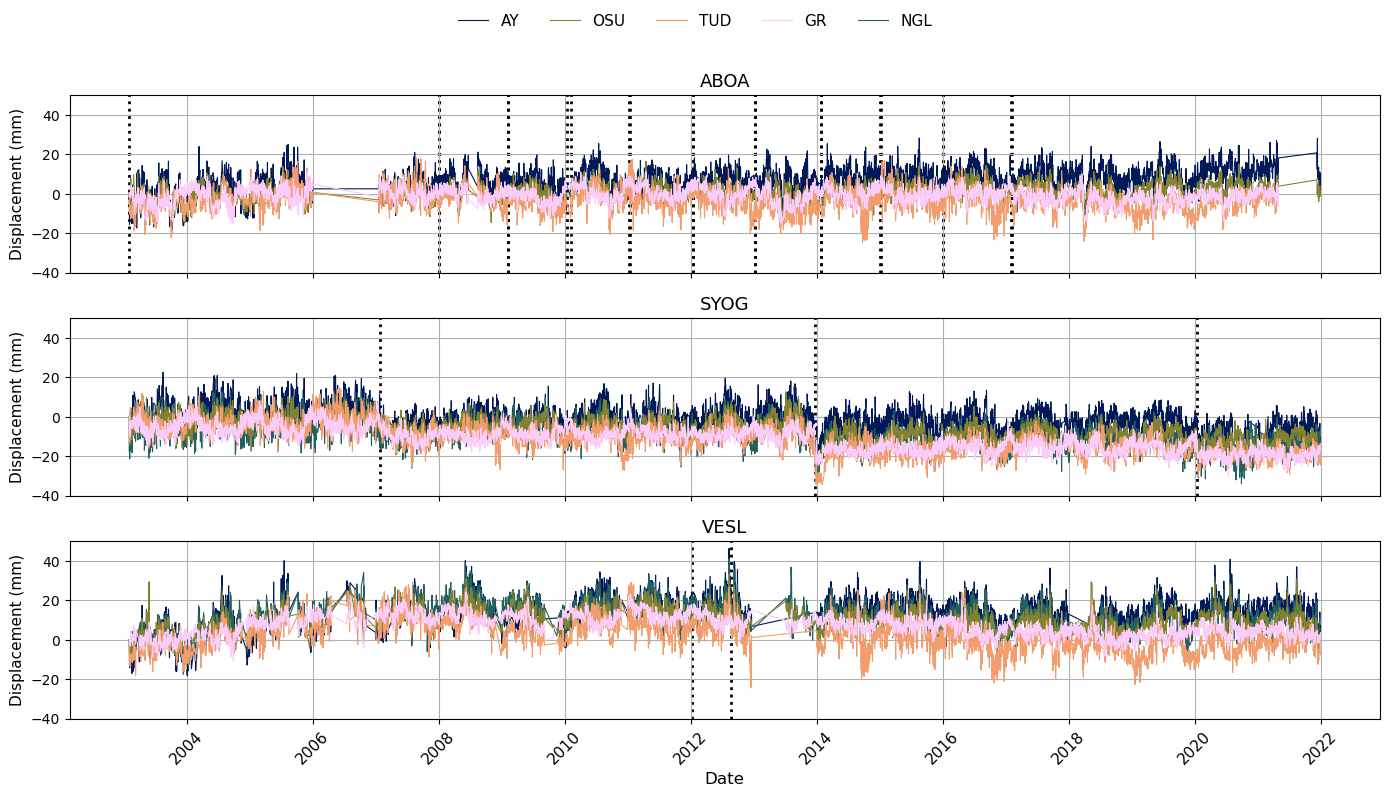

In [14]:
# maps and folder
station_map = {
    'ABOA': 'A',
    'SYOG': 'S',
    'VESL': 'V'
}
dataset_map = {
    'AY': 'A',
    'NGL': 'N',
    'OSU': 'O',
    'TUD': 'T',
    'GR': 'G',
}
correction_map = {'Original': '00'}
data_folder = "hector/processed_all"

# Find file for station + dataset
def find_mom_file(s_code, d_code, corr_code='00'):
    if not os.path.isdir(data_folder):
        raise FileNotFoundError(f"data_folder '{data_folder}' not found.")
    candidates = [f for f in os.listdir(data_folder) if f.lower().endswith('_2.mom')]
    # prefer files that start with s_code+d_code and contain corr_code
    patt = re.compile(fr'^{re.escape(s_code)}{re.escape(d_code)}.*{re.escape(corr_code)}', re.IGNORECASE)
    matches = [f for f in candidates if patt.search(f)]
    # fallback: any file that contains the pieces
    if not matches:
        matches = [f for f in candidates
                   if s_code.lower() in f.lower() and d_code.lower() in f.lower() and corr_code in f]
    return os.path.join(data_folder, matches[0]) if matches else None

# Read in mom files
def read_mom_file(filepath, mjd_to_datetime, normalize=True):
    """Read .mom file: detect data start where first three tokens are numeric"""
    with open(filepath, 'r') as fh:
        lines = fh.readlines()

    data_start = None
    for i, line in enumerate(lines):
        if not line.strip():
            continue
        toks = line.strip().split()
        if len(toks) >= 3:
            try:
                float(toks[0]); float(toks[1]); float(toks[2])
                data_start = i
                break
            except Exception:
                continue

    if data_start is None:
        return None

    df = pd.read_csv(filepath, sep='\\s+', header=None,
                     skiprows=data_start, comment='#', engine='python')
    df = df.iloc[:, :3].copy()
    df.columns = ['mjd', 'obs', 'model']

    df['mjd'] = pd.to_numeric(df['mjd'], errors='coerce')
    df = df.dropna(subset=['mjd']).reset_index(drop=True)
    if df.empty:
        return None

    df['date'] = df['mjd'].apply(lambda x: mjd_to_datetime(float(x)))
    df['date'] = pd.to_datetime(df['date'])
    df = df[(df['date'] >= '2003-02-01') & (df['date'] <= '2021-12-31')].copy()

    # normalization step 
    if normalize and not df['obs'].empty:
        df['obs'] = df['obs'] - df['obs'].iloc[0]

    return df


# Define offsets directly 
offsets_map = {
    "A": [  # ABOA
        "2003-02-01", "2007-12-31", "2008-01-03", "2009-02-04", "2009-02-05",
        "2010-01-12", "2010-02-05", "2011-01-11", "2011-01-13", "2012-01-15",
        "2012-01-17", "2013-01-09", "2013-01-10", "2014-01-23", "2014-01-24",
        "2015-01-05", "2015-01-06", "2016-01-05", "2016-01-06", "2017-02-02",
        "2017-02-06"
    ],
    "S": [  # SYOG
        "2007-01-26", "2013-12-23", "2020-01-18"
    ],
    "V": [  # VESL
        "2012-01-08", "2012-08-21"
    ]
}

def plot_original_series(mjd_to_datetime, figsize=(14, 8), save_path=None, debug=False):
    """
    Plot original GNSS displacement time series with station offsets as black dotted lines.
    """
    datasets = list(dataset_map.keys())
    palette = [cm.batlow(i / (len(datasets) - 1)) for i in range(len(datasets))]
    color_map = dict(zip(datasets, palette))

    n_rows = len(station_map)
    fig, axs = plt.subplots(n_rows, 1, figsize=figsize, sharex=True)
    if n_rows == 1:
        axs = [axs]

    handles, labels = [], []

    for row, (station, s_code) in enumerate(station_map.items()):
        ax = axs[row]

        # Plot GNSS datasets
        for dataset, d_code in dataset_map.items():
            fpath = find_mom_file(s_code, d_code, corr_code=correction_map['Original'])
            if fpath is None:
                continue

            df = read_mom_file(fpath, mjd_to_datetime)
            if df is None or df.empty:
                continue

            if debug:
                print(f"[DEBUG] {station}_{dataset}: {len(df)} rows "
                      f"{df['date'].min().date()} → {df['date'].max().date()}")

            line, = ax.plot(df['date'], df['obs'],
                            label=dataset,
                            color=color_map[dataset], linewidth=0.8)

            if dataset not in labels:  # collect legend entries only once
                handles.append(line)
                labels.append(dataset)

        # Plot offsets as black dotted lines
        if s_code in offsets_map:
            for step in offsets_map[s_code]:
                ax.axvline(pd.to_datetime(step), color="black", linestyle=":", linewidth=2, zorder=0)

        ax.set_ylabel("Displacement (mm)", fontsize=11)
        ax.set_title(station, fontsize=13)
        ax.grid(True)
        ax.set_ylim(-40, 50)

    # x-axis formatting
    axs[-1].xaxis.set_major_locator(mdates.AutoDateLocator())
    axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    axs[-1].tick_params(axis='x', rotation=45, labelsize=11)
    axs[-1].set_xlabel('Date', fontsize=12)

    # shared legend
    fig.legend(handles, labels, loc="upper center",
               ncol=len(datasets), fontsize=11, frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.93])  # leave space for legend
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

    
plot_original_series(mjd_to_datetime, save_path="figures/station_comparison_org_up.png")

## 2. Hector data

In [15]:
# Define desired correction and provider orders
correction_order = [
    'Original', 'EOST1', 'EOST2', 'GFZ1', 'EOST3', 'EOST4', 'EOST5',
    'GFZ2', 'GFZ3', 'EOST6', 'GFZ4', 'GFZ5'
]

provider_order = ['AY', 'NGL', 'OSU', 'TUD', 'GR']

# Apply categorical ordering
hector_params['Correction'] = pd.Categorical(
    hector_params['Correction'], categories=correction_order, ordered=True
)
hector_params['Provider'] = pd.Categorical(
    hector_params['Provider'], categories=provider_order, ordered=True
)

In [16]:
hector_params.head()

Station Provider Correction Component  Trend (mm/yr)  Trend σ (mm/yr)  \
0    ABOA       AY   Original      East       1.319810         0.091258   
1    ABOA       AY   Original     North      11.040300         0.140673   
2    ABOA       AY   Original        Up       0.440846         0.523965   
3    ABOA       AY      EOST1      East       1.414730         0.189336   
4    ABOA       AY      EOST1     North      11.060000         0.178479   

   Annual Amp (mm)  Annual Amp σ (mm)  Semi-Annual Amp (mm)  \
0         0.517531           0.088151              0.109501   
1         0.442485           0.131149              0.322578   
2         2.457330           0.479487              1.150500   
3         0.845906           0.161717              0.257991   
4         0.528823           0.157856              0.439432   

   Semi-Annual Amp σ (mm)  $\sigma_\mathrm{pl}$ (mm/yr$^{\hat{\kappa}/4}$)  \
0                0.053161                                          3.18196   
1                0.095886                                          4.78339   
2                0.335348                                         16.42770   
3                0.102009                                          5.11178   
4                0.113109                                          5.45876   

   $\sigma_\mathrm{wn}$ (mm)  $\hat{\kappa}$      phase  
0                   0.180909       -0.856129  -18.02870  
1                   0.095059       -0.880178   72.89360  
2                   0.456425       -0.956408   66.40500  
3                   0.255115       -1.103190    4.27714  
4                   0.473053       -0.974968  129.98100

In [17]:
def compute_percentage_changes(df_station):
    """Compute % changes vs Original for a station DataFrame."""
    metrics = [
    'Trend (mm/yr)',
    'Annual Amp (mm)',
    'Semi-Annual Amp (mm)',
    r"$\hat{\kappa}$",
    r"$\sigma_\mathrm{pl}$ (mm/yr$^{\hat{\kappa}/4}$)",
    r"$\sigma_\mathrm{wn}$ (mm)"
]

    # Extract originals per (Provider, Component)
    originals = (
        df_station[df_station['Correction'] == 'Original']
        .drop_duplicates(subset=['Provider', 'Component'])
        .rename(columns={metric: f'{metric} (original)' for metric in metrics})
    )

    # Merge
    df_merged = pd.merge(
        df_station,
        originals[['Provider', 'Component'] + [f'{metric} (original)' for metric in metrics]],
        on=['Provider', 'Component'],
        how='left'
    )

    # Compute % change
    for metric in metrics:
        df_merged[f'{metric} % change'] = (
            (df_merged[f'{metric} (original)'] - df_merged[metric]) /
            df_merged[f'{metric} (original)'] * 100
        )

    # Ensure sorting by provider + correction
    df_merged = df_merged.sort_values(['Provider', 'Correction'])

    display_cols = ['Provider', 'Correction', 'Component'] + [f'{metric} % change' for metric in metrics]
    print(f"\n{df_station['Station'].iloc[0]} % changes:")
    print(df_merged[display_cols].round(2).to_string(index=False))

    return df_merged



def plot_metric(df_station, y_col, y_err_col=None, save_path=None, ylim=None):
    """Plot a given metric with error bars for one station."""
    components = ['East', 'North', 'Up']
    providers = df_station['Provider'].dropna().unique()
    palette = [cm.batlow(i / (len(provider_order) - 1)) for i in range(len(provider_order))]
    color_map = dict(zip(provider_order, palette))


    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    legend_handles, legend_labels = None, None

    for i, comp in enumerate(components):
        ax = axes[i]
        df_comp = df_station[df_station['Component'] == comp].copy()

        sns.barplot(
            data=df_comp,
            x='Correction',
            y=y_col,
            hue='Provider',
            palette=color_map,
            ax=ax,
            errorbar=None,
            dodge=True
        )

        if i == 0:
            legend_handles, legend_labels = ax.get_legend_handles_labels()
        ax.legend_.remove()

        # Error bars
        if y_err_col is not None:
            for patch, (_, row) in zip(ax.patches, df_comp.iterrows()):
                x = patch.get_x() + patch.get_width() / 2
                y = patch.get_height()
                err = row[y_err_col]
                ax.errorbar(x=x, y=y, yerr=err, fmt='none',
                            ecolor='black', capsize=3)

        ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
        ax.set_title(f'{comp}')
        ax.set_ylabel(y_col)
        if ylim:
            ax.set_ylim(ylim)
        ax.tick_params(axis='x', rotation=90)

    fig.legend(handles=legend_handles, labels=legend_labels,
               loc='right', bbox_to_anchor=(1.01, 0.5), title='Provider')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


### a) Individual station plots


=== ABOA ===
Correction values: ['Original', 'EOST1', 'EOST3', 'EOST2', 'GFZ1', 'EOST4', 'EOST5', 'GFZ2', 'GFZ3', 'EOST6', 'GFZ4', 'GFZ5']
Provider values: ['AY', 'GR', 'OSU', 'TUD']

ABOA % changes:
Provider Correction Component  Trend (mm/yr) % change  Annual Amp (mm) % change  Semi-Annual Amp (mm) % change  $\hat{\kappa}$ % change  $\sigma_\mathrm{pl}$ (mm/yr$^{\hat{\kappa}/4}$) % change  $\sigma_\mathrm{wn}$ (mm) % change
      AY   Original      East                    0.00                      0.00                           0.00                    -0.00                                                      0.00                                0.00
      AY   Original     North                    0.00                      0.00                           0.00                    -0.00                                                      0.00                                0.00
      AY   Original        Up                    0.00                      0.00                           0.0

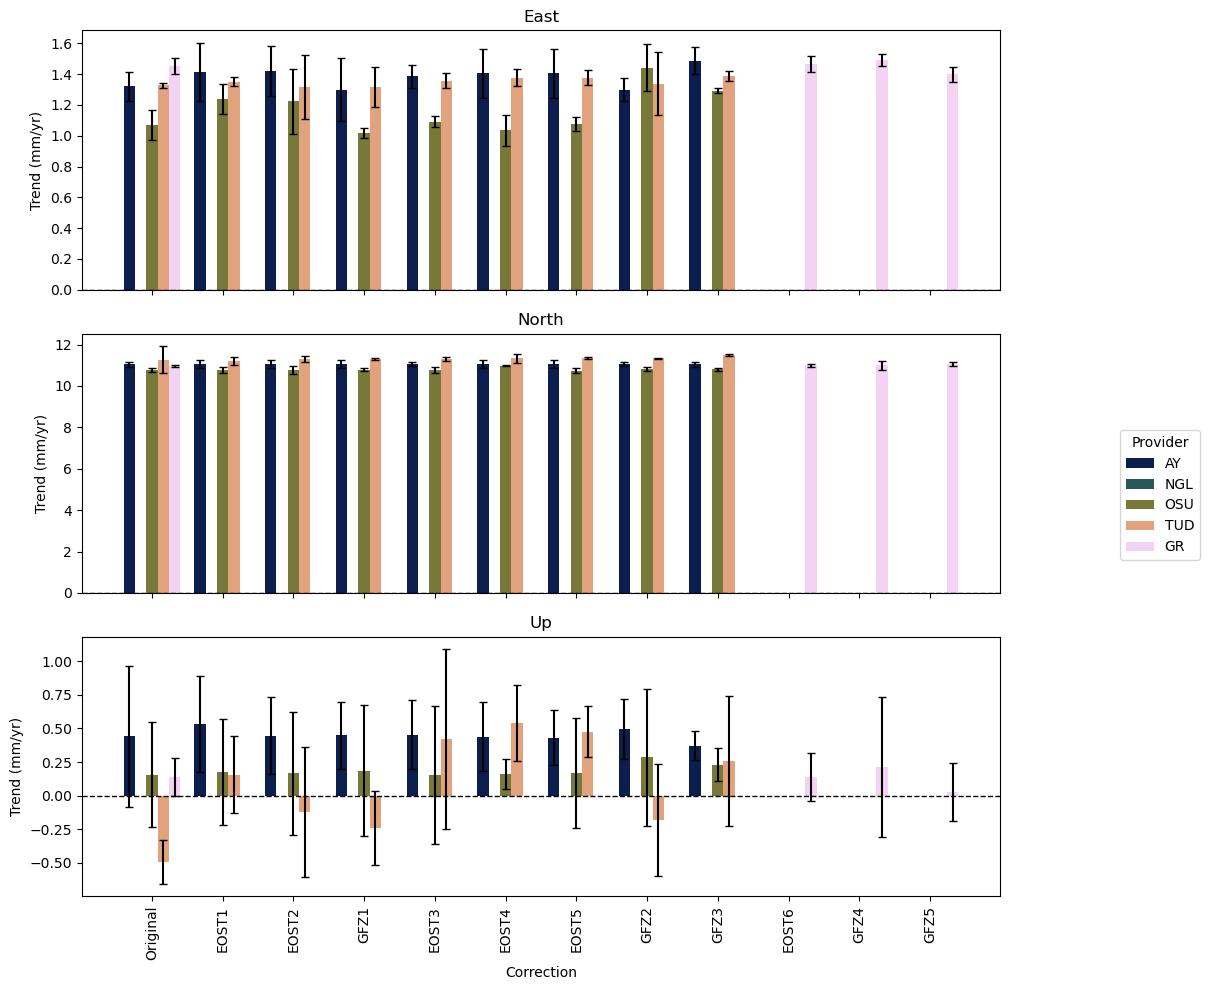

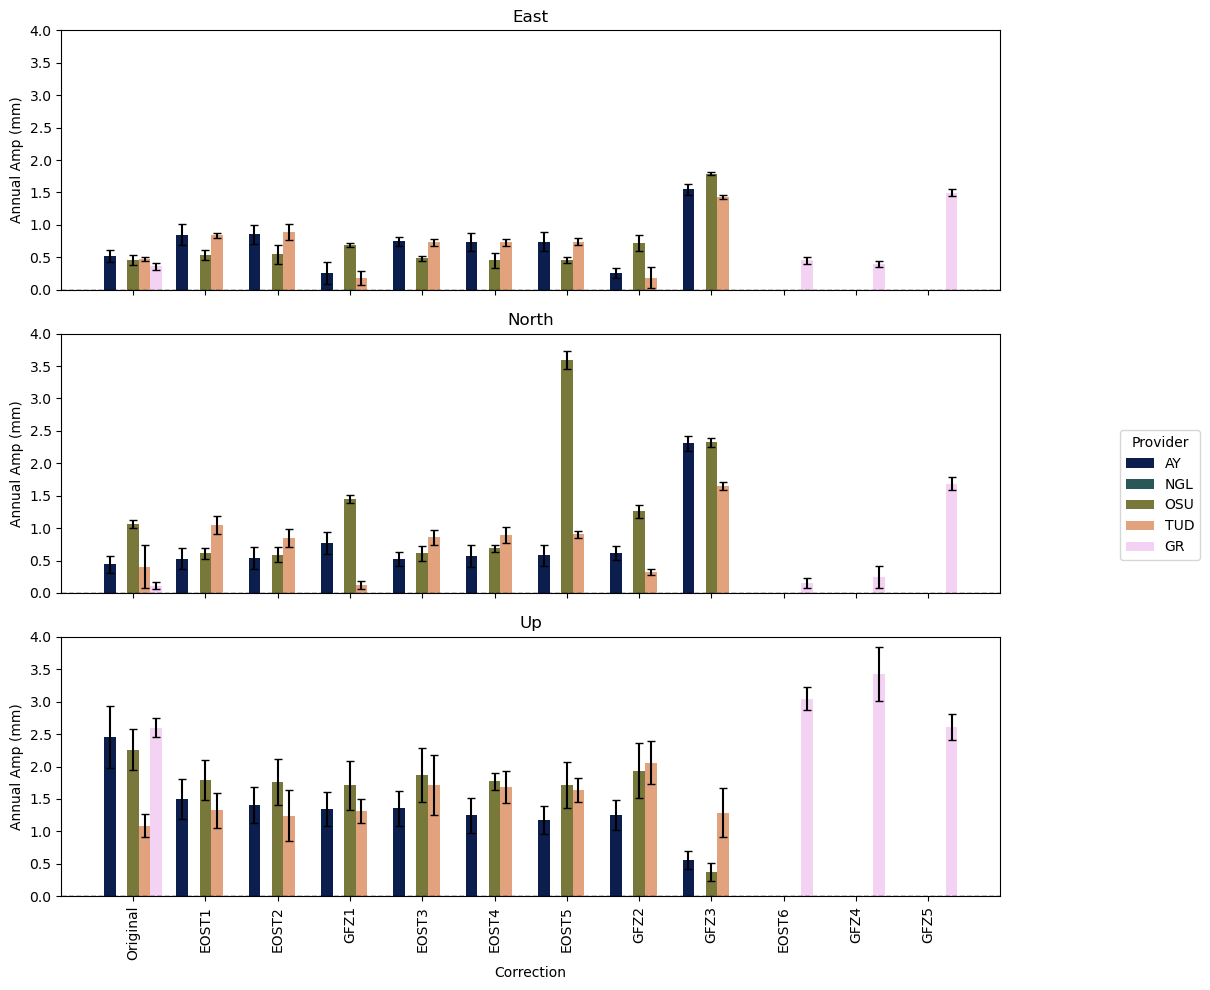

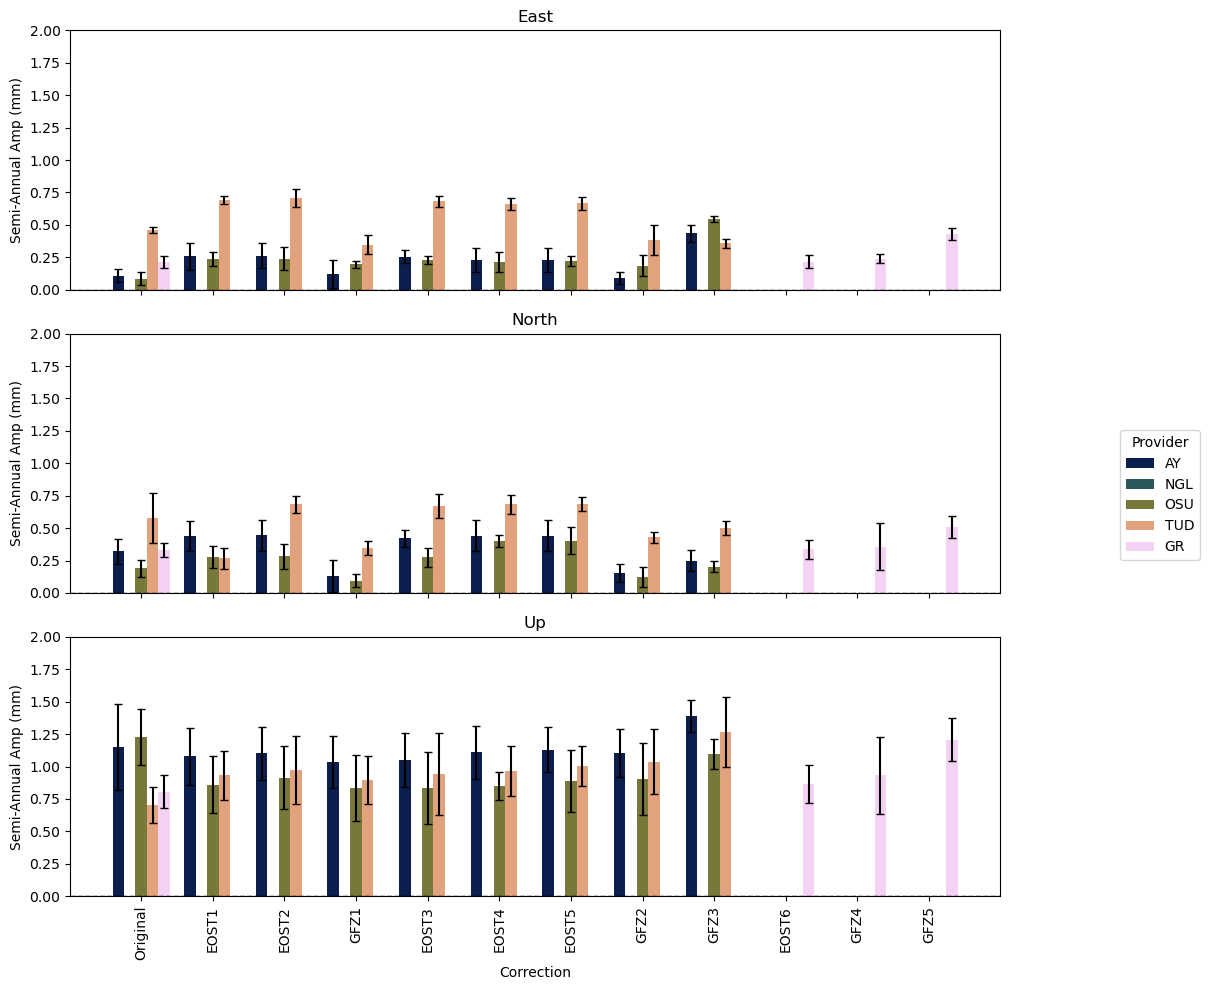

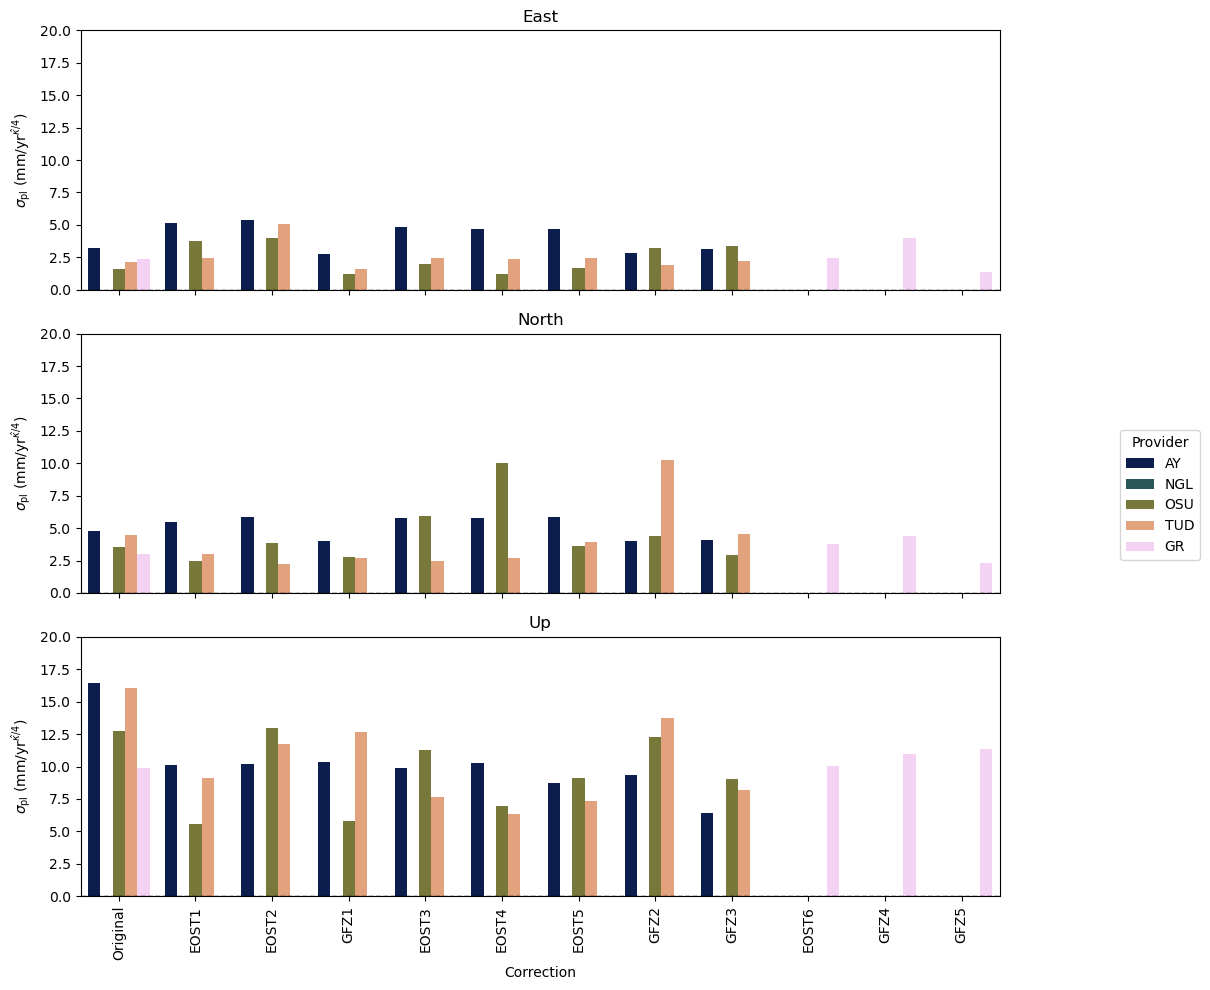

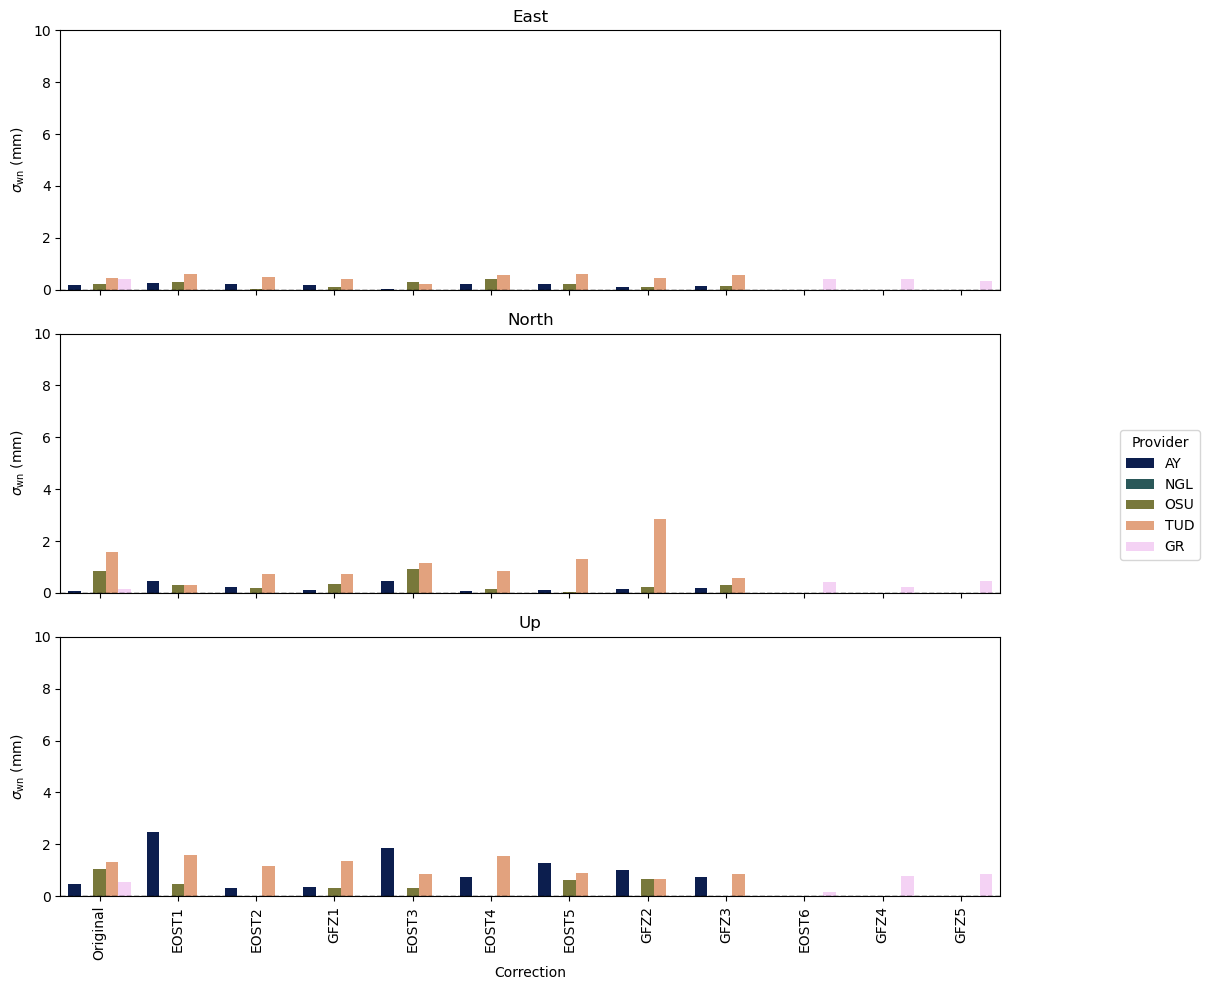

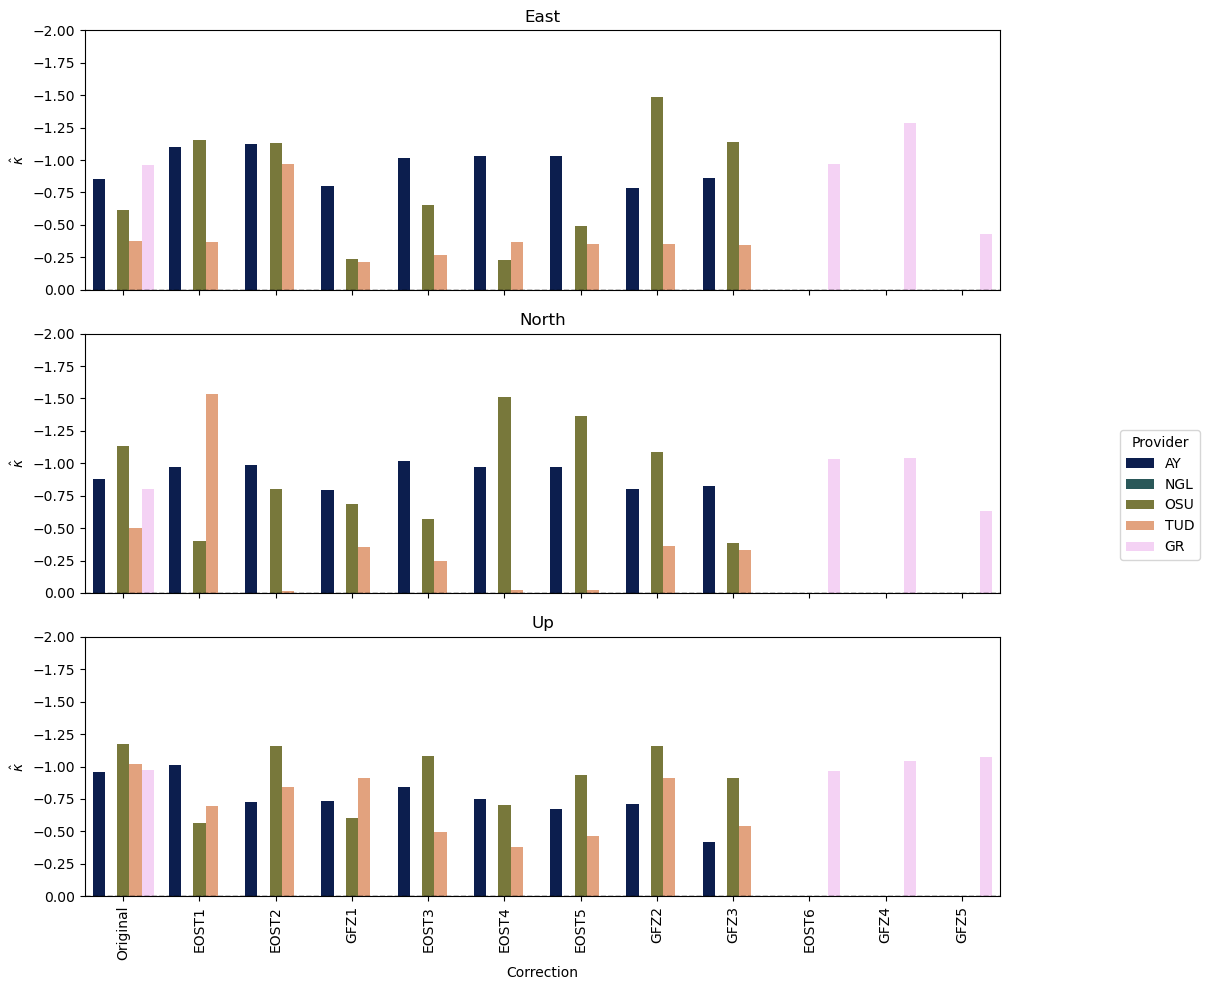


=== SYOG ===
Correction values: ['Original', 'EOST1', 'EOST3', 'EOST2', 'GFZ1', 'EOST4', 'EOST5', 'GFZ2', 'GFZ3', 'EOST6', 'GFZ4', 'GFZ5']
Provider values: ['AY', 'GR', 'NGL', 'OSU', 'TUD']

SYOG % changes:
Provider Correction Component  Trend (mm/yr) % change  Annual Amp (mm) % change  Semi-Annual Amp (mm) % change  $\hat{\kappa}$ % change  $\sigma_\mathrm{pl}$ (mm/yr$^{\hat{\kappa}/4}$) % change  $\sigma_\mathrm{wn}$ (mm) % change
      AY   Original      East                   -0.00                      0.00                           0.00                    -0.00                                                      0.00                                0.00
      AY   Original     North                    0.00                      0.00                           0.00                    -0.00                                                      0.00                                0.00
      AY   Original        Up                    0.00                      0.00                       

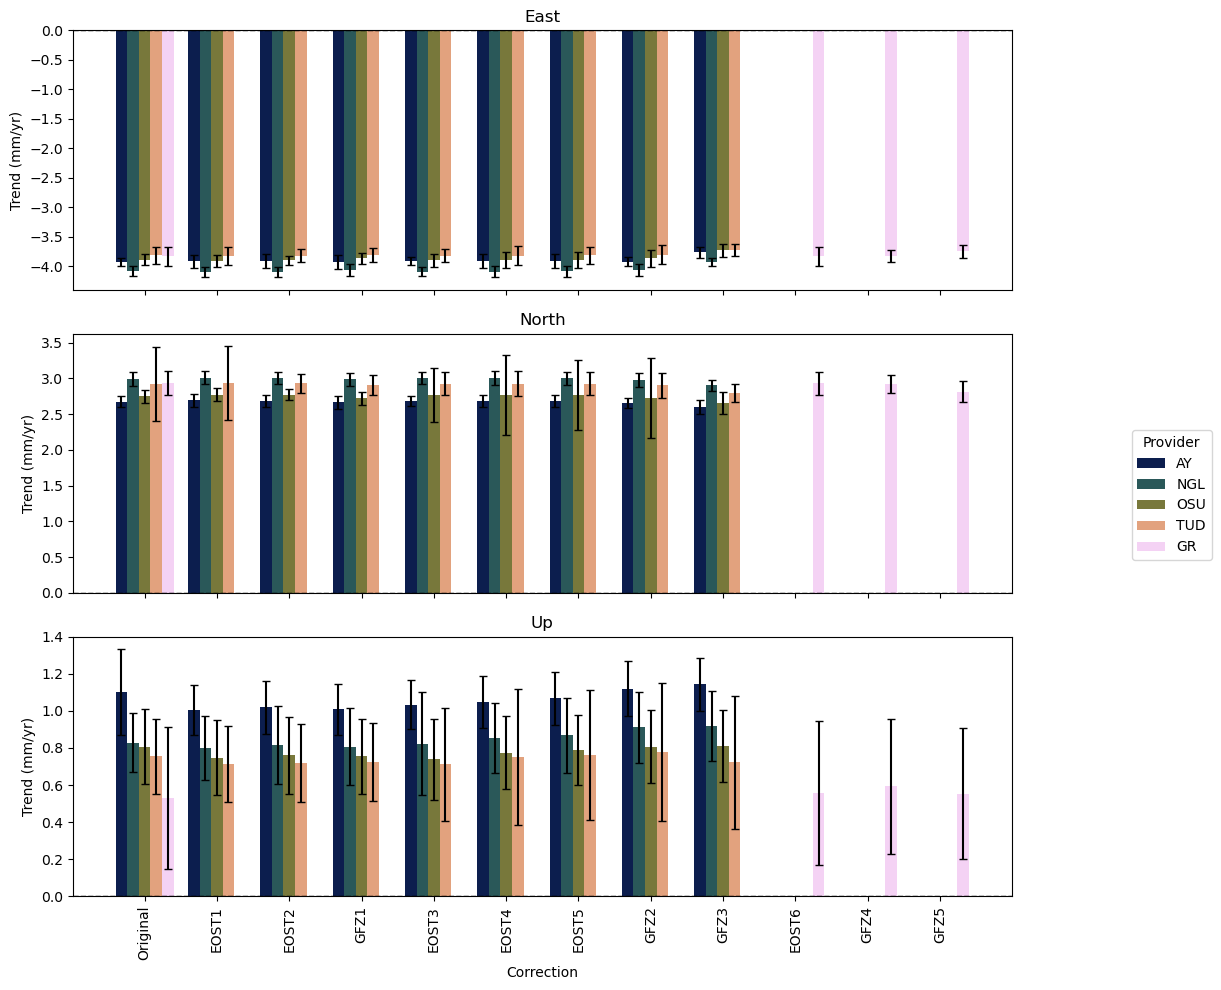

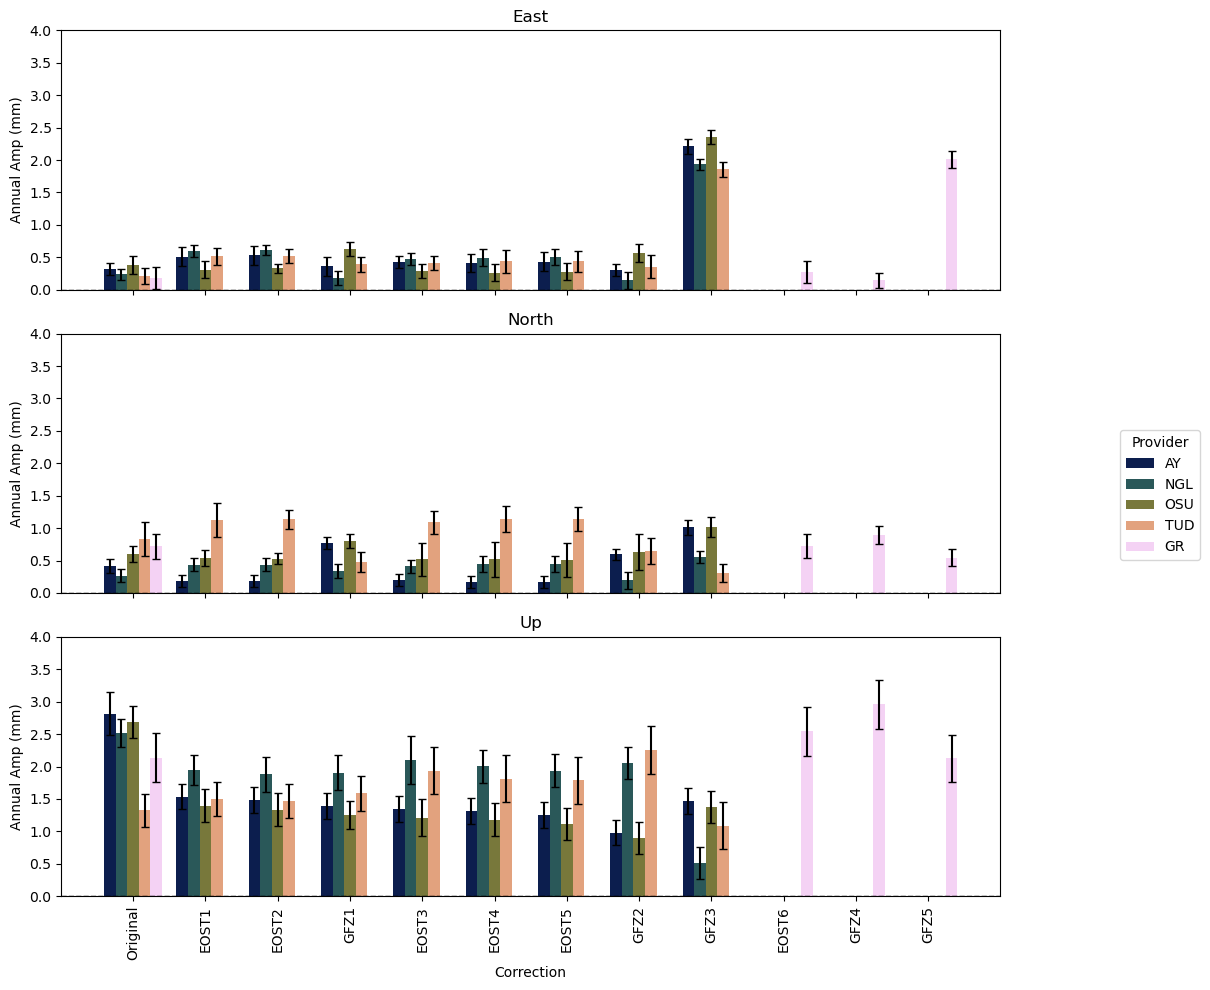

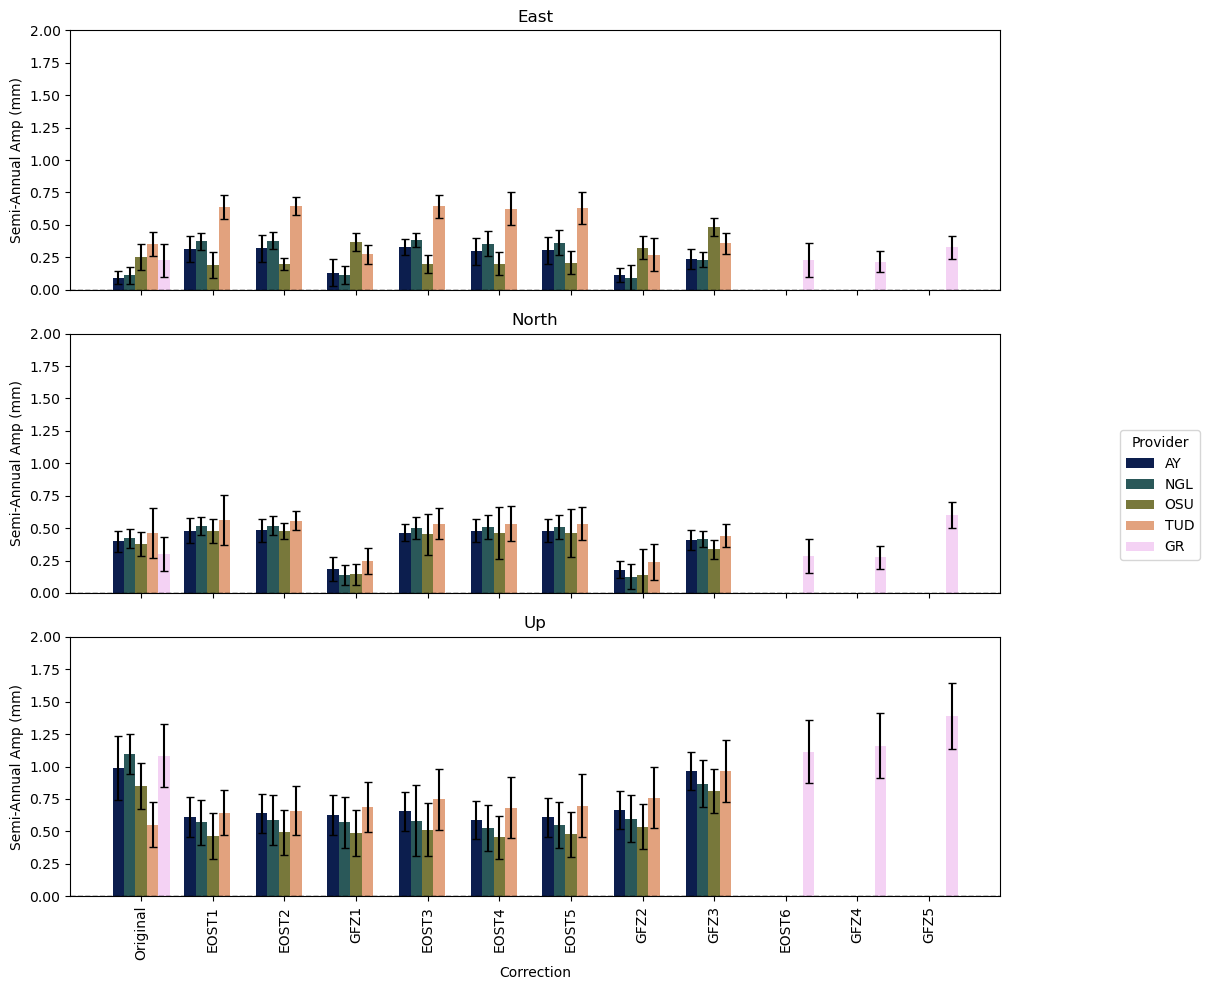

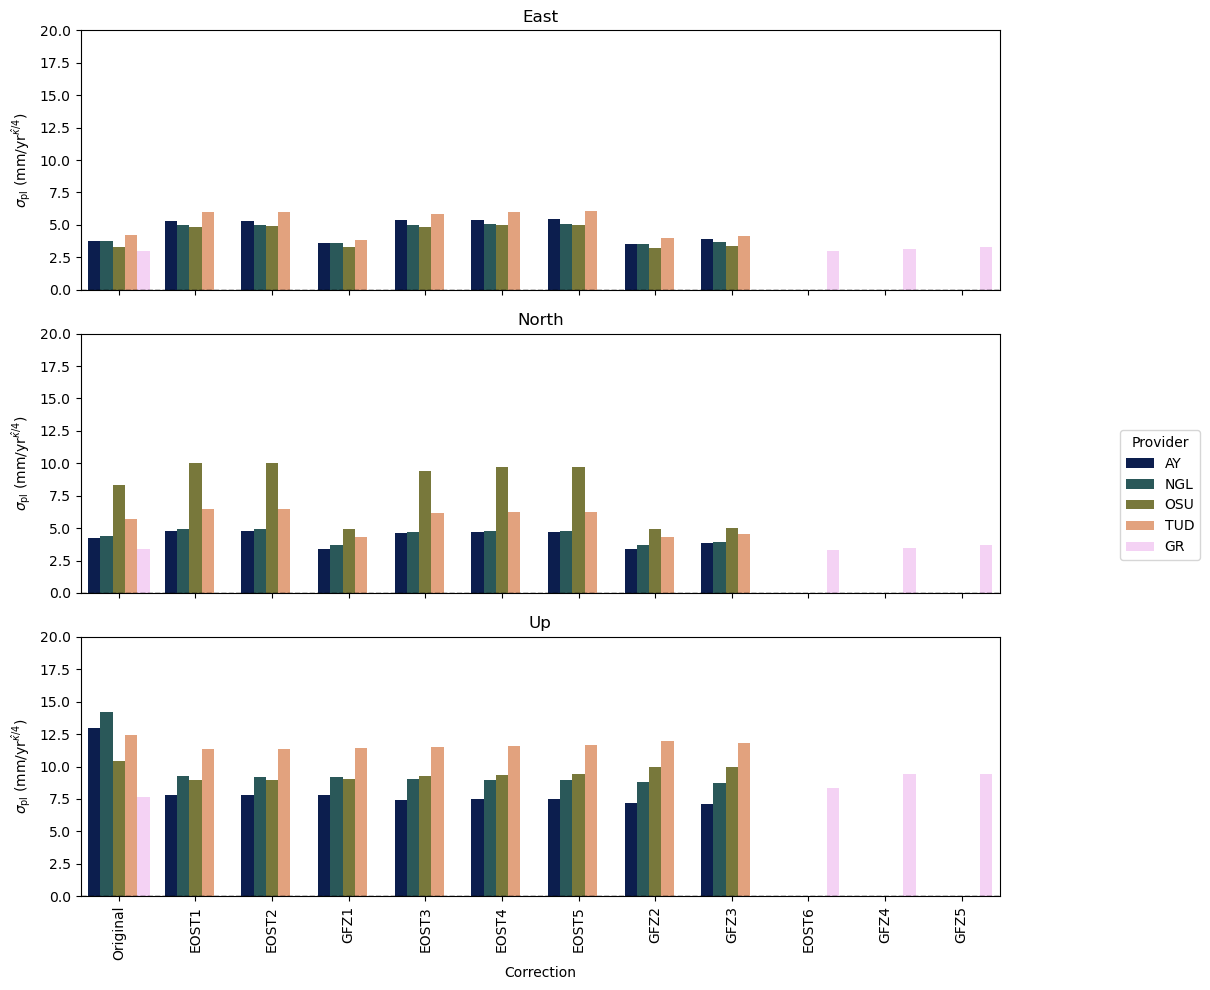

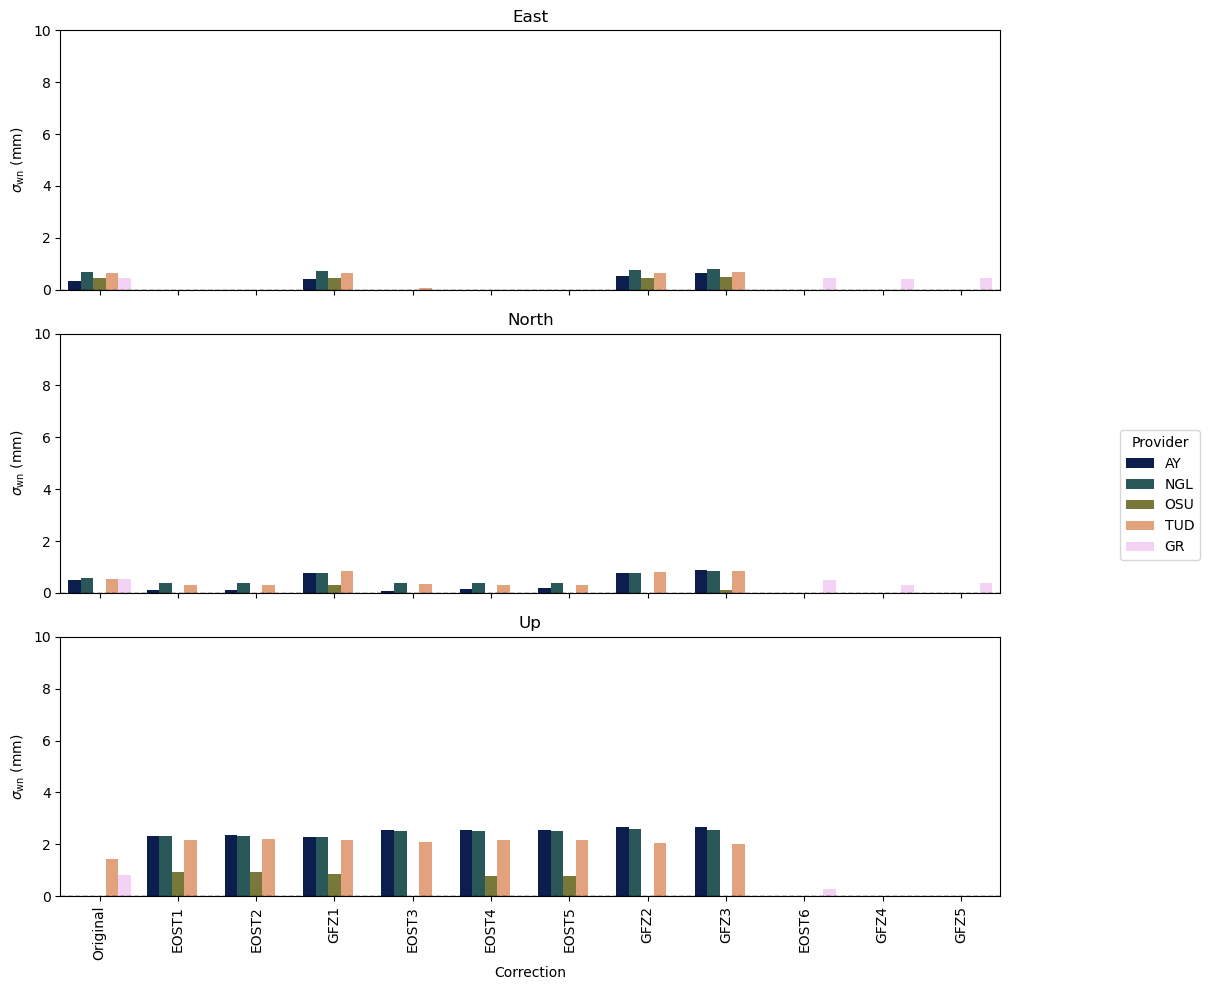

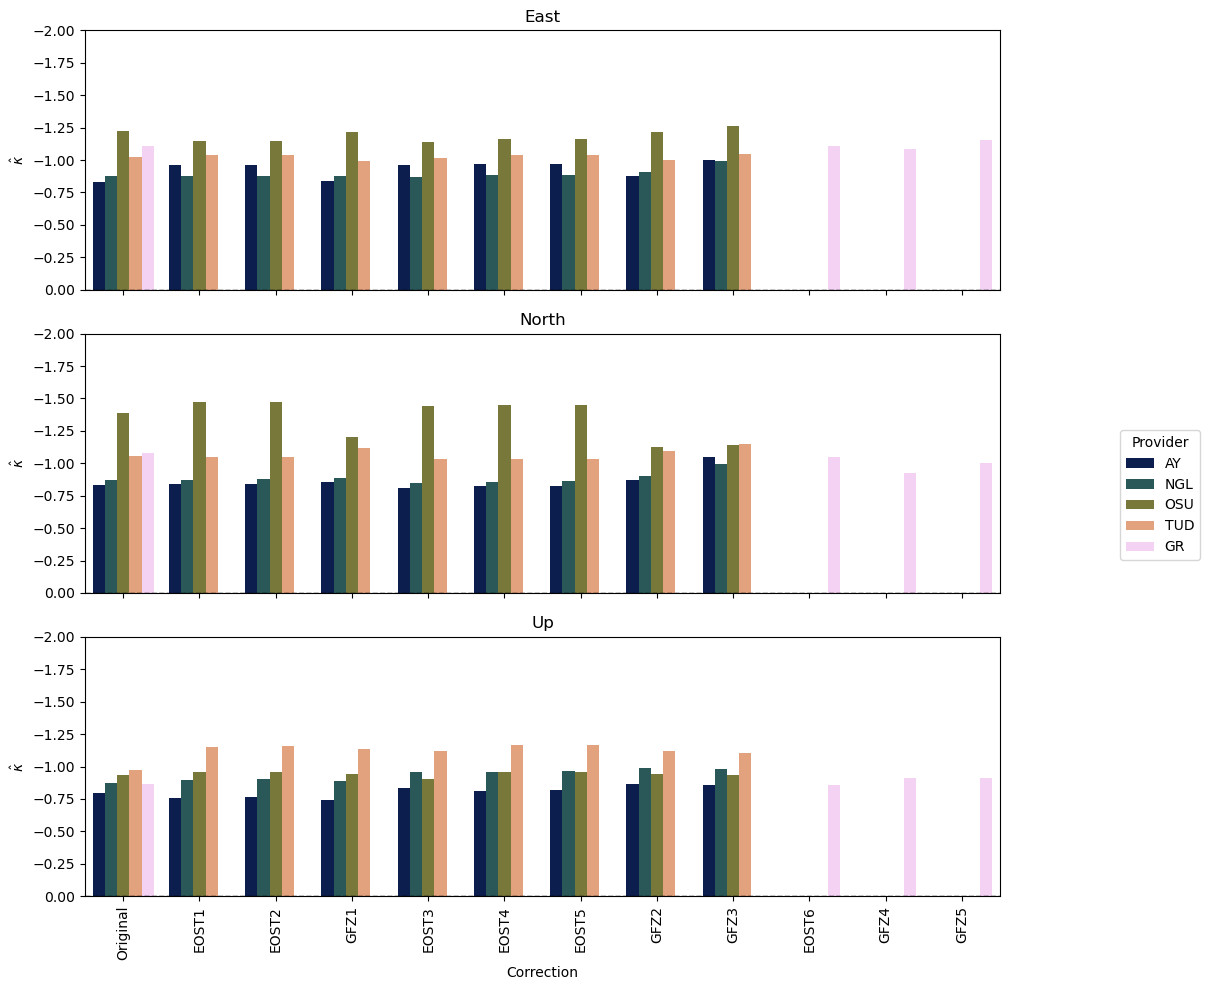


=== VESL ===
Correction values: ['Original', 'EOST1', 'EOST3', 'EOST2', 'GFZ1', 'EOST4', 'EOST5', 'GFZ2', 'GFZ3', 'EOST6', 'GFZ4', 'GFZ5']
Provider values: ['AY', 'GR', 'NGL', 'OSU', 'TUD']

VESL % changes:
Provider Correction Component  Trend (mm/yr) % change  Annual Amp (mm) % change  Semi-Annual Amp (mm) % change  $\hat{\kappa}$ % change  $\sigma_\mathrm{pl}$ (mm/yr$^{\hat{\kappa}/4}$) % change  $\sigma_\mathrm{wn}$ (mm) % change
      AY   Original      East                   -0.00                      0.00                           0.00                    -0.00                                                      0.00                                0.00
      AY   Original     North                    0.00                      0.00                           0.00                    -0.00                                                      0.00                                0.00
      AY   Original        Up                    0.00                      0.00                       

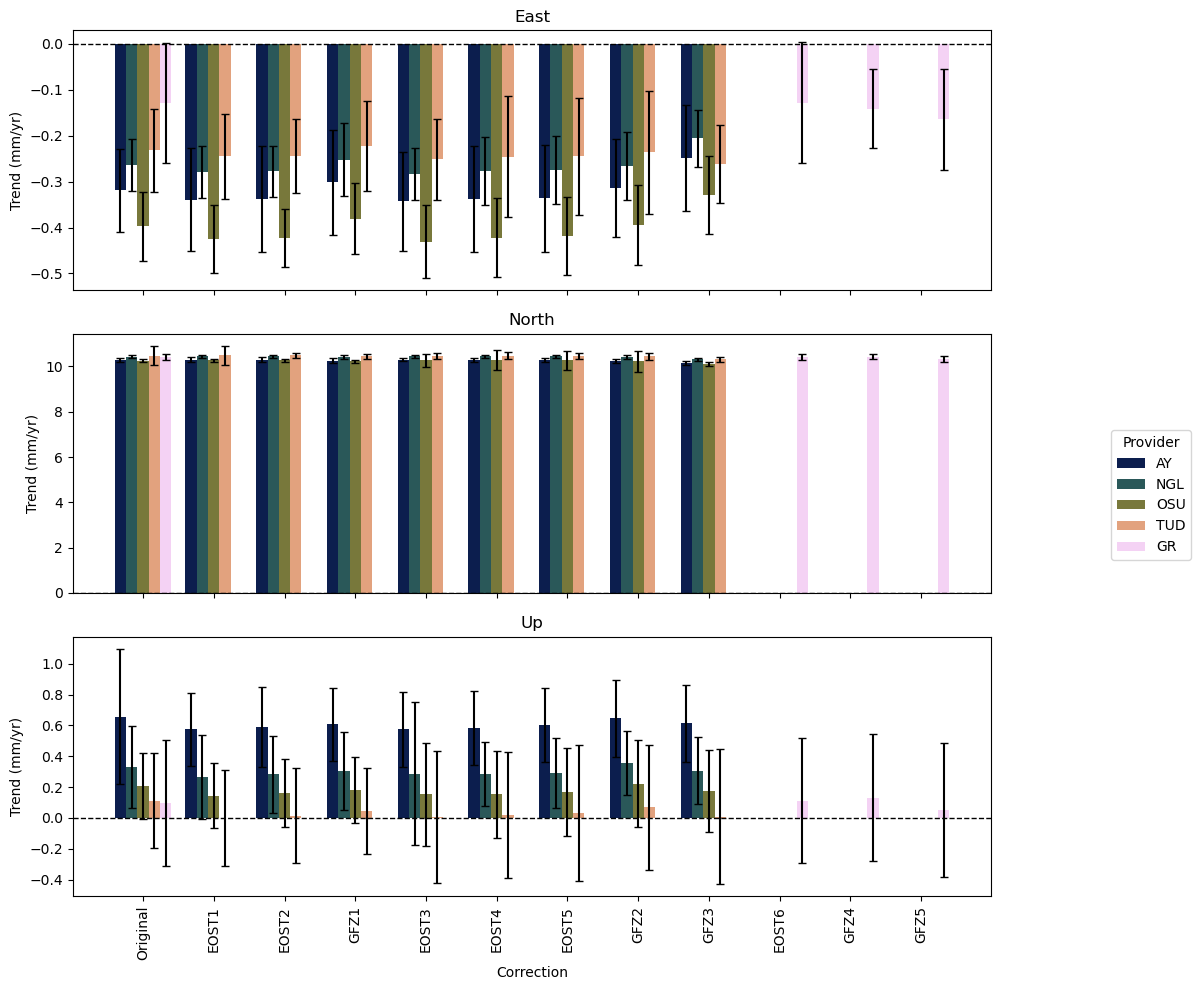

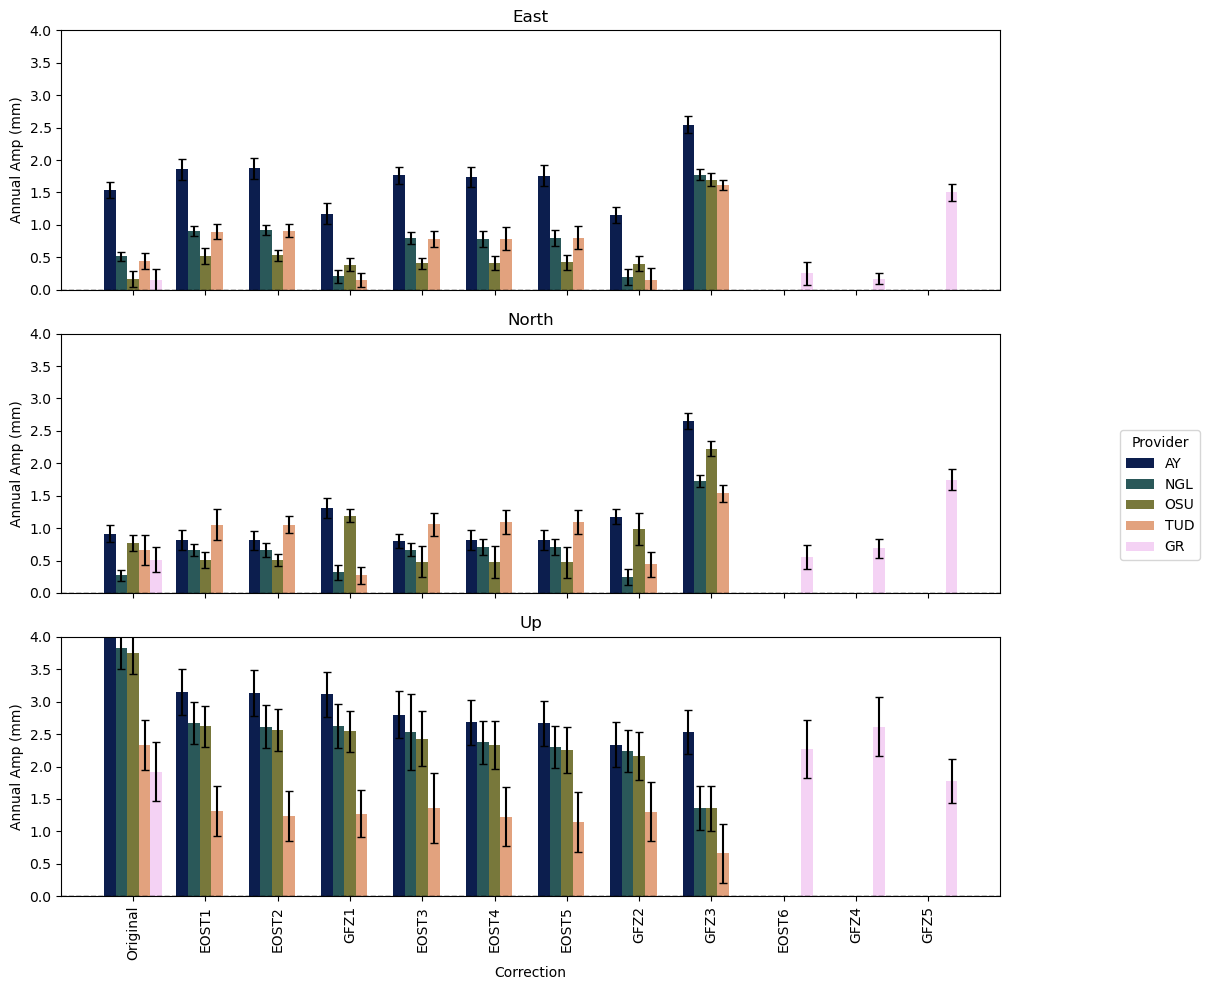

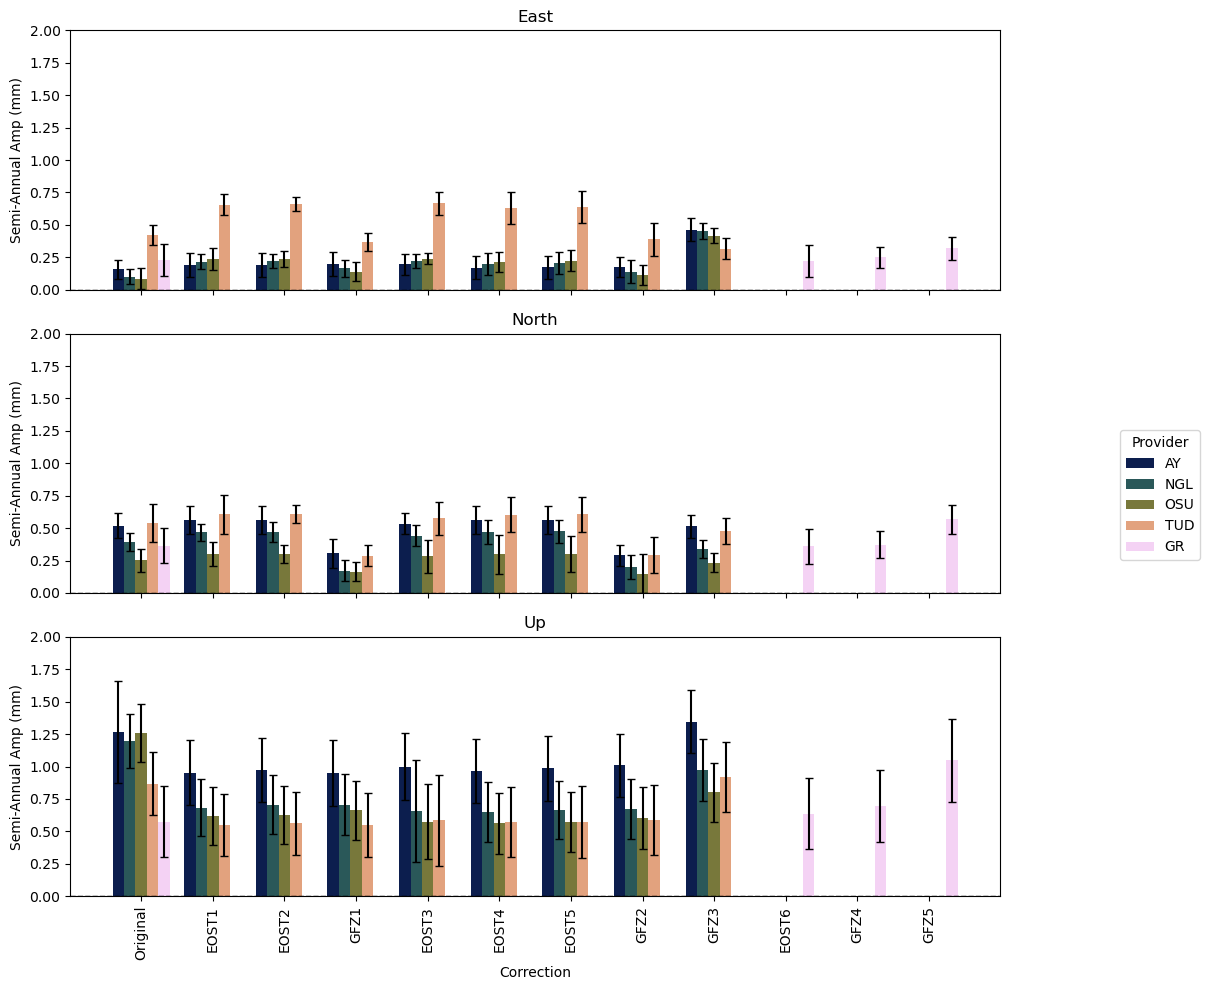

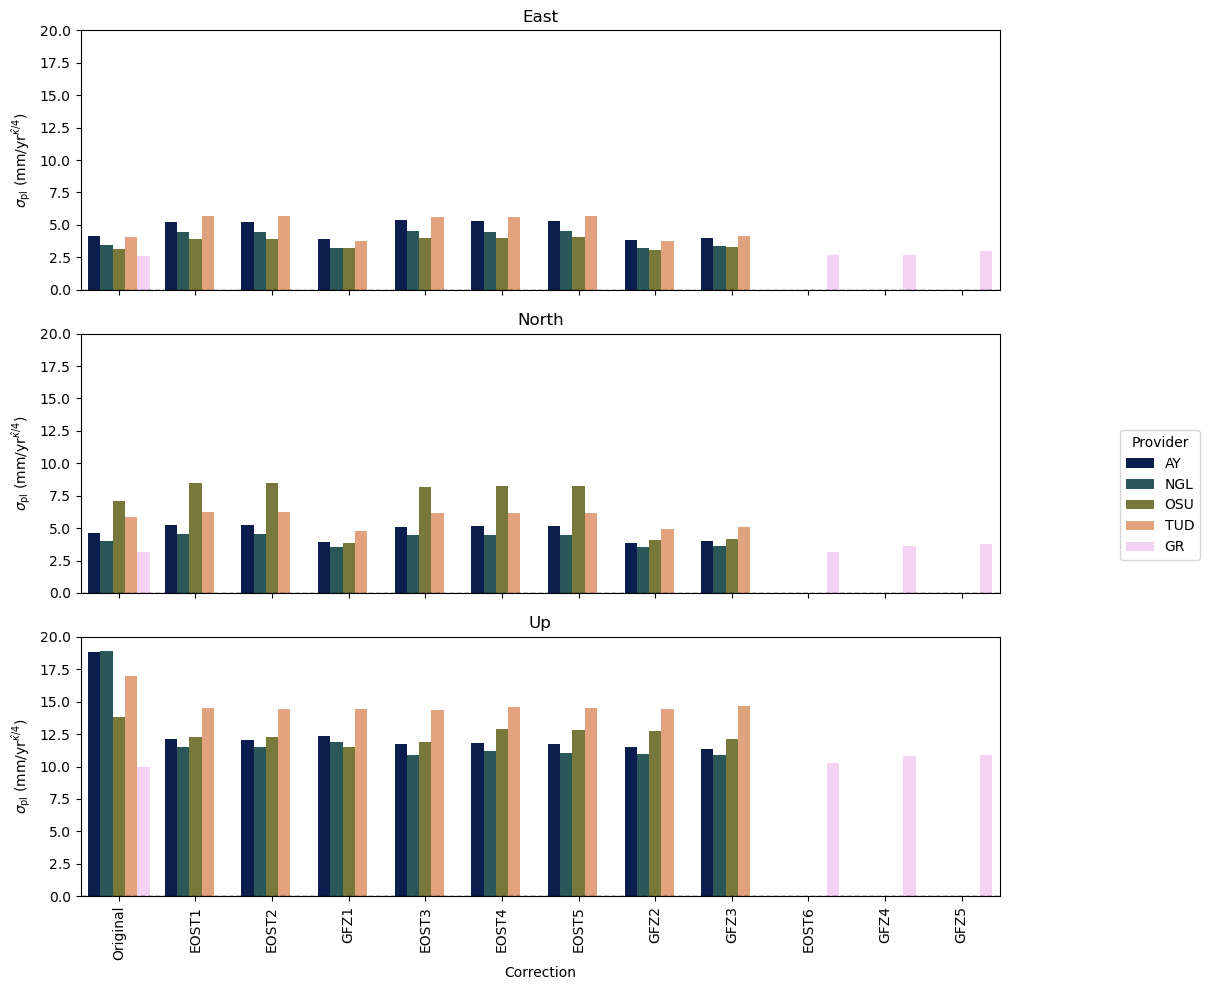

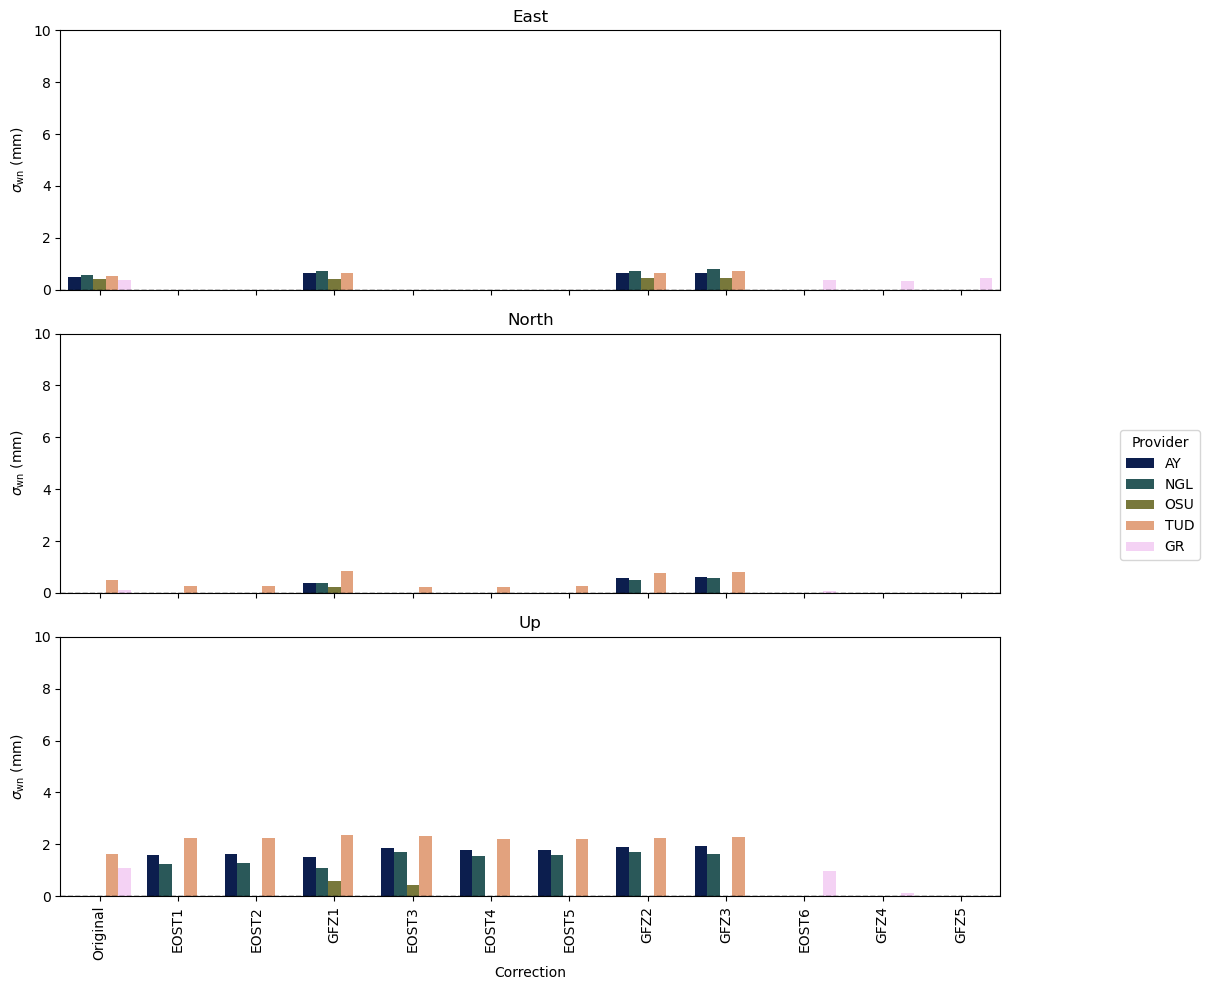

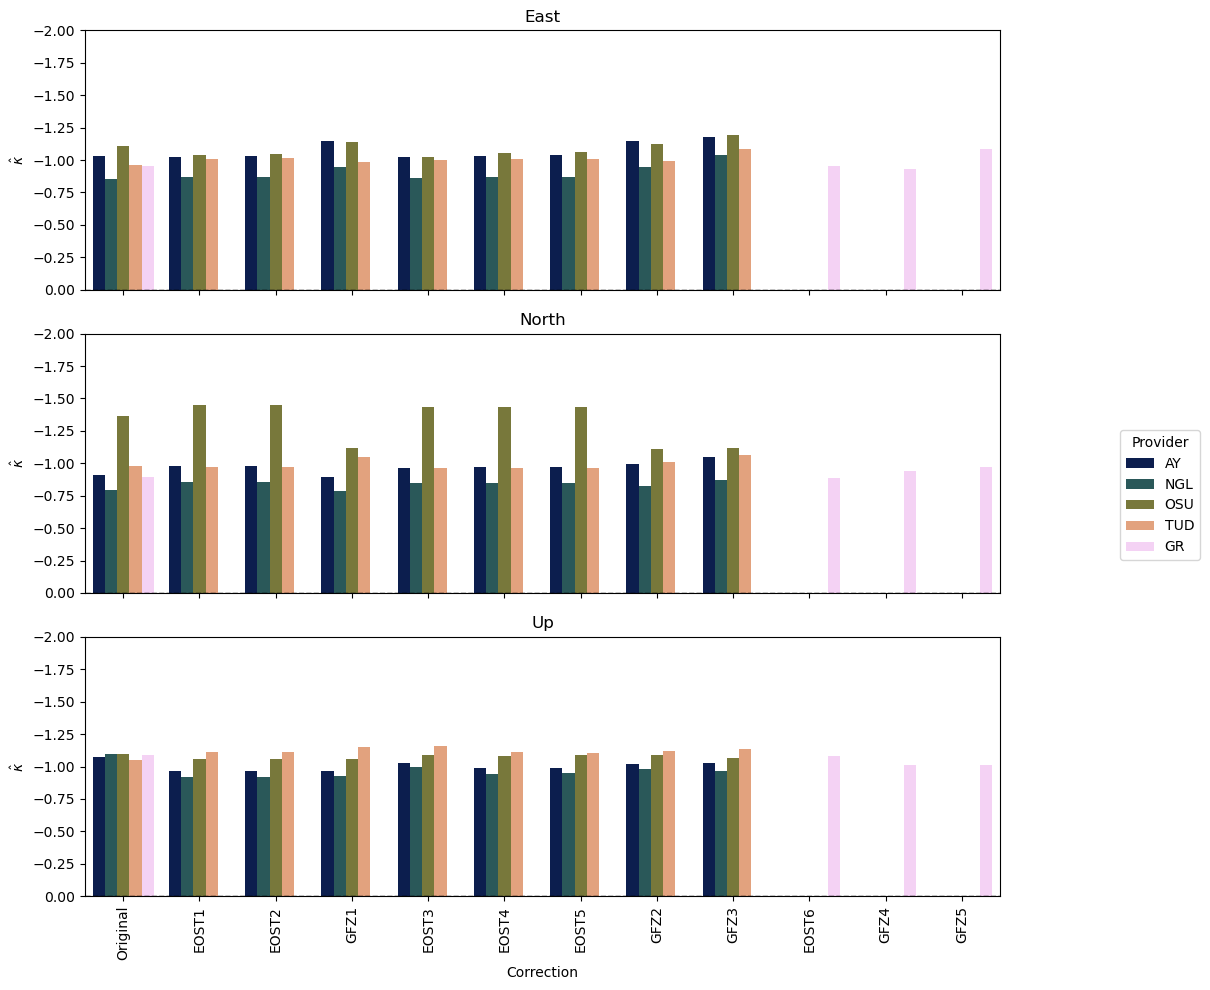

In [18]:
# Run for all stations
stations = ["ABOA", "SYOG", "VESL"]

for st in stations:
    df_station = hector_params[hector_params["Station"] == st].copy()
    if df_station.empty:
        print(f"Skipping {st} (no data)")
        continue

    # Print available values (sorted by category order automatically)
    print(f"\n=== {st} ===")
    print("Correction values:", df_station['Correction'].dropna().unique().tolist())
    print("Provider values:", df_station['Provider'].dropna().unique().tolist())

    df_with_changes = compute_percentage_changes(df_station)

    # Example plots
    plot_metric(df_station, 'Trend (mm/yr)', 'Trend σ (mm/yr)', f'figures/{st.lower()}_trend.png')
    plot_metric(df_station, 'Annual Amp (mm)', 'Annual Amp σ (mm)', f'figures/{st.lower()}_amp.png', ylim=(0,4))
    plot_metric(df_station, 'Semi-Annual Amp (mm)', 'Semi-Annual Amp σ (mm)', f'figures/{st.lower()}_semiamp.png', ylim=(0,2))
    plot_metric(df_station, r"$\sigma_\mathrm{pl}$ (mm/yr$^{\hat{\kappa}/4}$)", None, f'figures/{st.lower()}_noise_pl.png', ylim=(0,20))
    plot_metric(df_station, r"$\sigma_\mathrm{wn}$ (mm)", None, f'figures/{st.lower()}_noise_wn.png', ylim=(0,10))
    plot_metric(df_station, r"$\hat{\kappa}$", None, f'figures/{st.lower()}_kappa.png', ylim=(0,-2))


### b) Combination plots for vertical component

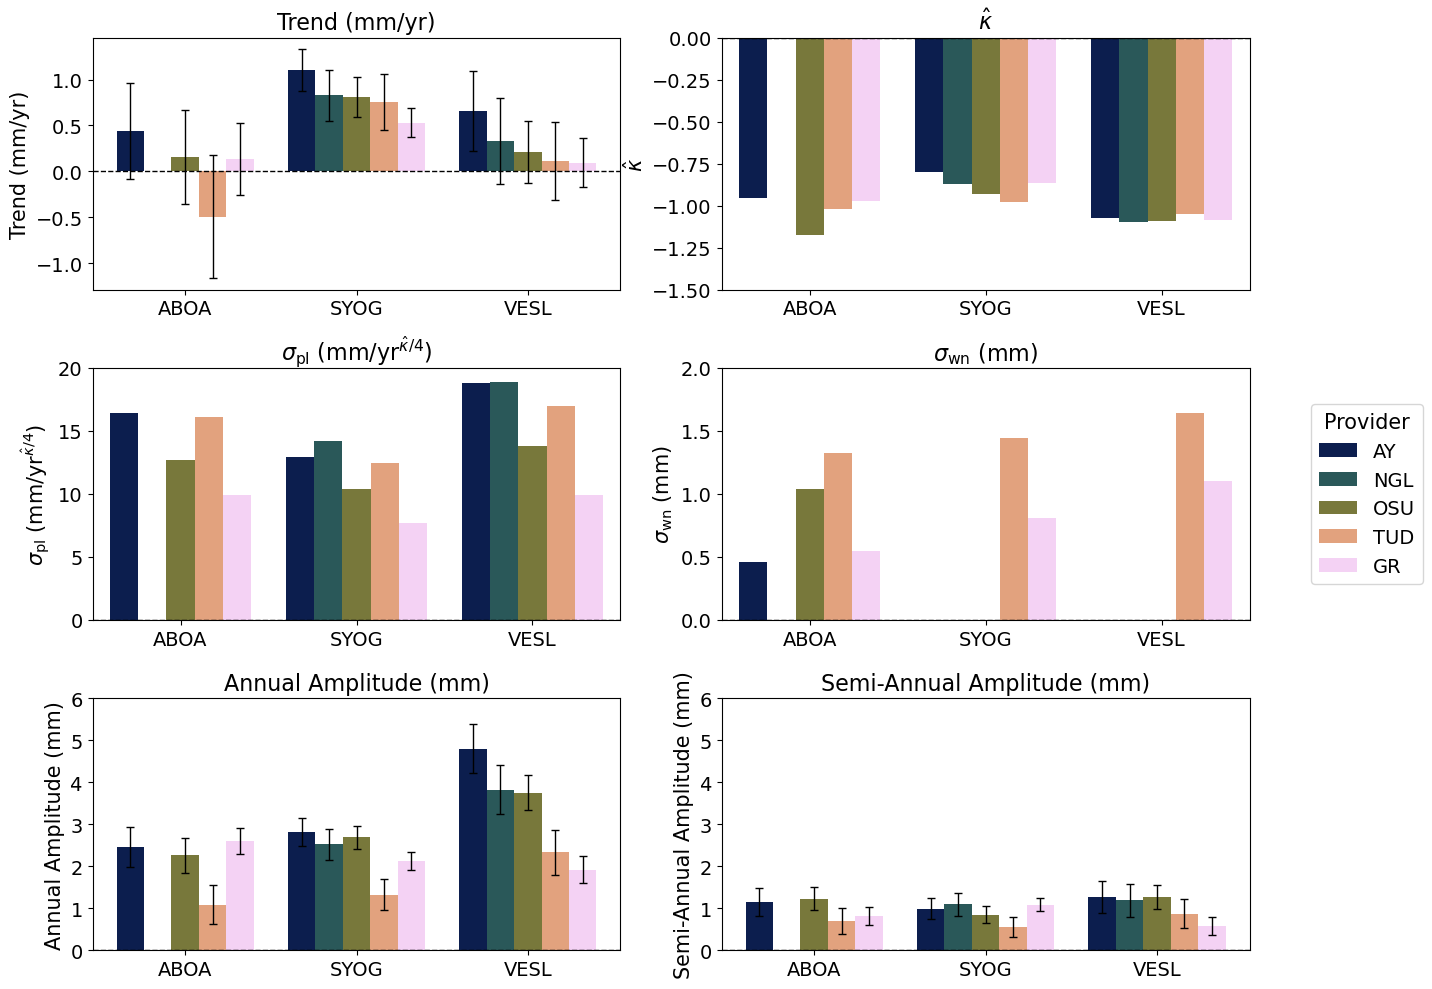

In [19]:
# Combine all Up component data for 'Original' only
df_up_all = (
    hector_params[
        (hector_params['Component'] == 'Up') &
        (hector_params['Correction'] == 'Original')
    ].copy()
)

# Desired provider order 
provider_order = ['AY', 'NGL', 'OSU', 'TUD', 'GR']

# Filter and re-order providers based on those present 
present_providers = [p for p in provider_order if p in df_up_all['Provider'].unique()]
df_up_all['Provider'] = pd.Categorical(df_up_all['Provider'], categories=present_providers, ordered=True)

# Ensure station is categorical for consistent bar alignment
df_up_all['Station'] = pd.Categorical(df_up_all['Station'], categories=['ABOA', 'SYOG', 'VESL'], ordered=True)

# Color map in desired order 
palette = [cm.batlow(i / (len(present_providers) - 1)) for i in range(len(present_providers))]
color_map = dict(zip(present_providers, palette))

# Metrics to plot 
metrics = [
    ('Trend (mm/yr)', 'Trend σ (mm/yr)', 'Trend (mm/yr)', None),
    (r'$\hat{\kappa}$', None, r'$\hat{\kappa}$', (-1.5, 0)),
    (r'$\sigma_\mathrm{pl}$ (mm/yr$^{\hat{\kappa}/4}$)', None, r'$\sigma_\mathrm{pl}$ (mm/yr$^{\hat{\kappa}/4}$)', (0, 20)),
    (r'$\sigma_\mathrm{wn}$ (mm)', None, r'$\sigma_\mathrm{wn}$ (mm)', (0, 2)),
    ('Annual Amp (mm)', 'Annual Amp σ (mm)', 'Annual Amplitude (mm)', (0, 6)),
    ('Semi-Annual Amp (mm)', 'Semi-Annual Amp σ (mm)', 'Semi-Annual Amplitude (mm)', (0, 6)),
]

# Plotting
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (y_col, err_col, title, ylim) in enumerate(metrics):
    ax = axes[idx]

    # Draw barplot without error bars
    sns.barplot(
        data=df_up_all,
        x='Station',
        y=y_col,
        hue='Provider',
        palette=color_map,
        ax=ax,
        errorbar=None,
        dodge=True
    )

    # Draw custom error bars where uncertainty column is provided
    if err_col:
        # Get number of stations and providers
        station_levels = df_up_all['Station'].cat.categories
        provider_levels = df_up_all['Provider'].cat.categories
        n_providers = len(provider_levels)

        for patch in ax.patches:
            # Determine which bar this is: station and provider index
            x_center = patch.get_x() + patch.get_width() / 2
            height = patch.get_height()

            # Figure out matching row from df_up_all
            station = patch.get_x() + patch.get_width() / 2
            station_label = patch.get_x()
            # x_tick locations are not directly accessible; match from data
            for _, row in df_up_all.iterrows():
                match = (
                    abs(patch.get_height() - row[y_col]) < 1e-3 and
                    row['Provider'] in provider_levels and
                    row['Station'] in station_levels
                )
                if match:
                    err = row[err_col]
                    if pd.notna(err):
                        ax.errorbar(
                            x=x_center,
                            y=height,
                            yerr=err,
                            fmt='none',
                            ecolor='black',
                            capsize=3,
                            linewidth=1
                        )
                    break

    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax.set_title(title, fontsize=16)
    ax.set_ylabel(title, fontsize=15)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=0, labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    if ylim:
        ax.set_ylim(ylim)
    ax.legend_.remove()

# Unified legend 
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles=handles,
    labels=labels,
    loc='right',
    bbox_to_anchor=(1.02, 0.5),
    title='Provider',
    fontsize=14,
    title_fontsize=15
)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig('figures/up_summary_original.png', dpi=300, bbox_inches='tight')
plt.show()


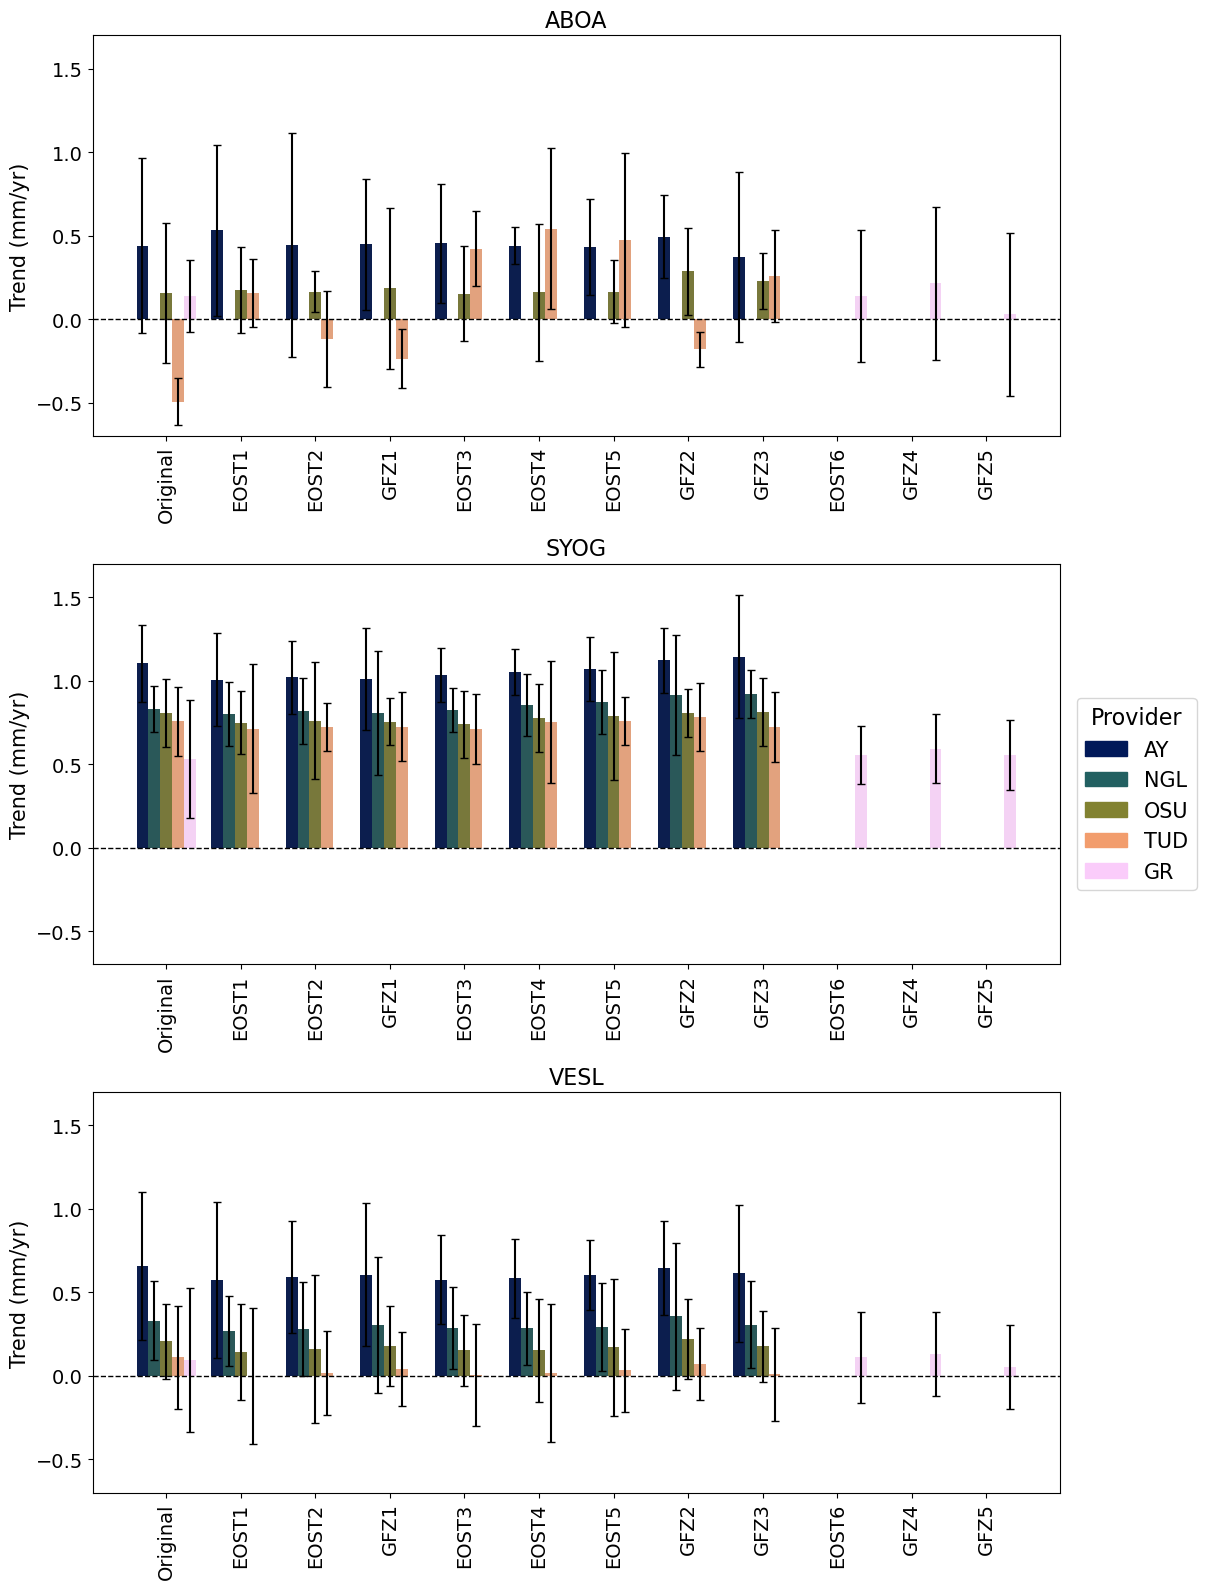

In [20]:
# Define station DataFrames
stations = ["ABOA", "SYOG", "VESL"]
components = ['Up']
priority_end = ['EOST6', 'GFZ4', 'GFZ5']

# Manual y-limits
manual_ylim = {'Up': (-0.7, 1.7)}

# Set up figure and axes 
fig, axes = plt.subplots(3, 1, figsize=(12, 16), sharex=False, sharey=False)

# Use only SYOG providers for consistent color mapping
syog_providers = ['AY', 'NGL', 'OSU', 'TUD', 'GR']  # explicit desired order
palette = [cm.batlow(i / (len(syog_providers) - 1)) for i in range(len(syog_providers))]
color_map = dict(zip(syog_providers, palette))

for idx, station_name in enumerate(stations):
    ax = axes[idx]

    # Subset data for this station & Up component
    df = hector_params[
        (hector_params["Station"] == station_name) &
        (hector_params["Component"] == "Up")
    ].copy()

    if df.empty:
        print(f"Skipping {station_name}: no data for Up component")
        continue

    # Ensure consistent correction order
    df["Correction"] = pd.Categorical(df["Correction"],
                                      categories=correction_order,
                                      ordered=True)

    # Filter to SYOG providers only
    df = df[df["Provider"].isin(syog_providers)]

    # Sort so bars match plotting order
    df = df.sort_values(["Correction", "Provider"]).reset_index(drop=True)

    # Plot barplot
    sns.barplot(
        data=df,
        x="Correction",
        y="Trend (mm/yr)", 
        hue="Provider",
        palette=color_map,
        ax=ax,
        errorbar=None,
        dodge=True
    )

    # Add error bars
    for patch, (_, row) in zip(ax.patches, df.iterrows()):
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_height()
        err = row["Trend σ (mm/yr)"]
        if pd.notna(err):
            ax.errorbar(x=x, y=y, yerr=err, fmt="none",
                        ecolor="black", capsize=3)

    ax.axhline(y=0, color="black", linestyle="--", linewidth=1)
    ax.set_ylim(manual_ylim["Up"])

    ax.set_title(f"{station_name}", fontsize=16)
    ax.set_xlabel("", fontsize=15)
    ax.set_ylabel("Trend (mm/yr)", fontsize=15)
    ax.tick_params(axis="x", rotation=90, labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    ax.legend_.remove()

# Unified legend 
legend_handles = [mpatches.Patch(color=color_map[prov], label=prov) for prov in syog_providers]
fig.legend(
    handles=legend_handles,
    labels=syog_providers,
    loc="right",
    bbox_to_anchor=(1.01, 0.5),
    title="Provider",
    fontsize=15,
    title_fontsize=16
)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig('figures/station_comparison_trends_up.png', dpi=300, bbox_inches='tight')
plt.show()

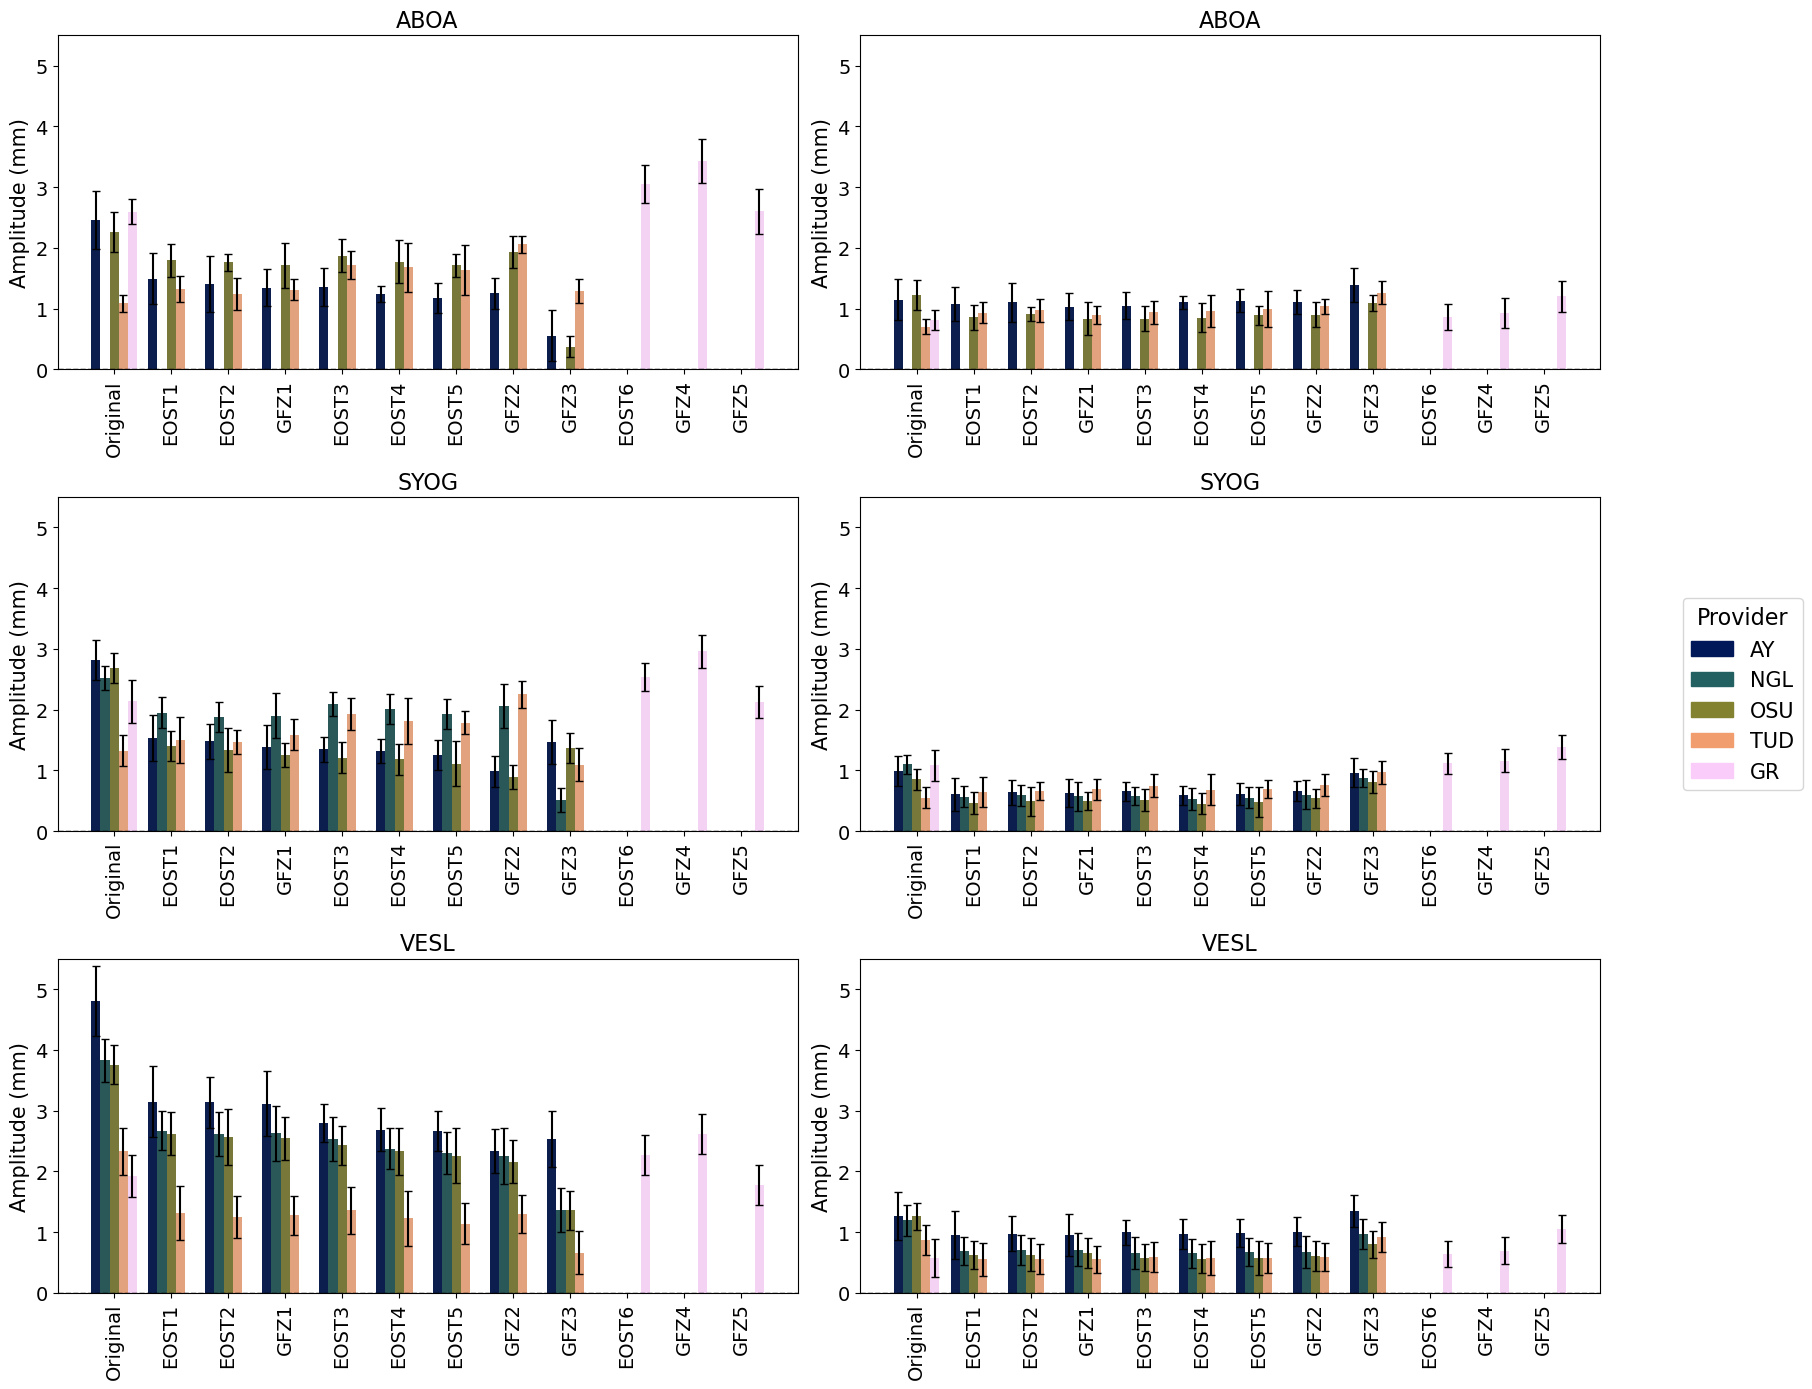

In [21]:
# Define station DataFrames
stations = ["ABOA", "SYOG", "VESL"]
priority_end = ['EOST6', 'GFZ4', 'GFZ5']
manual_ylim = {'Up': (0, 5.5)}
amplitude_types = ['Annual Amp (mm)', 'Semi-Annual Amp (mm)']
error_columns = {
    'Annual Amp (mm)': 'Annual Amp σ (mm)',
    'Semi-Annual Amp (mm)': 'Semi-Annual Amp σ (mm)'
}

# Color map for providers
syog_providers = ['AY', 'NGL', 'OSU', 'TUD', 'GR']
palette = [cm.batlow(i / (len(syog_providers) - 1)) for i in range(len(syog_providers))]
color_map = dict(zip(syog_providers, palette))

# Set up figure
fig, axes = plt.subplots(3, 2, figsize=(18, 14), sharex=False, sharey=False)

# Loop: rows = stations, cols = amp types 
for row_idx, station_name in enumerate(stations):
    # Subset for this station and Up component
    df = hector_params[
        (hector_params["Station"] == station_name) &
        (hector_params["Component"] == "Up")
    ].copy()

    if df.empty:
        print(f"Skipping {station_name}: no Up data")
        continue

    # Ensure consistent correction order
    df["Correction"] = pd.Categorical(df["Correction"],
                                      categories=correction_order,
                                      ordered=True)

    # Filter providers
    df = df[df["Provider"].isin(syog_providers)]

    # Sort so bar order matches across providers/corrections
    df = df.sort_values(["Correction", "Provider"]).reset_index(drop=True)

    # Loop over amplitude types
    for col_idx, amp_type in enumerate(amplitude_types):
        ax = axes[row_idx, col_idx]

        # Prepare data
        df_amp = df[['Correction', 'Provider', amp_type]].copy()
        df_amp = df_amp.rename(columns={amp_type: 'Amplitude'})
        df_amp['Error'] = df.apply(lambda row: row[error_columns[amp_type]], axis=1)

        sns.barplot(
            data=df_amp,
            x='Correction',
            y='Amplitude',
            hue='Provider',
            palette=color_map,
            ax=ax,
            errorbar=None,
            dodge=True
        )

        # Add error bars
        for patch, (_, row) in zip(ax.patches, df_amp.iterrows()):
            x = patch.get_x() + patch.get_width() / 2
            y = patch.get_height()
            err = row['Error']
            ax.errorbar(x=x, y=y, yerr=err, fmt='none', ecolor='black', capsize=3)

        # Formatting
        ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
        ax.set_ylim(manual_ylim['Up'])
        ax.set_xlabel('', fontsize=15)
        ax.set_ylabel('Amplitude (mm)', fontsize=15)
        ax.tick_params(axis='x', rotation=90, labelsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.legend_.remove()
        ax.set_title(f'{station_name}', fontsize=16)

# Unified legend 
legend_handles = [mpatches.Patch(color=color_map[prov], label=prov) for prov in syog_providers]
fig.legend(
    handles=legend_handles,
    labels=syog_providers,
    loc='right',
    bbox_to_anchor=(1.01, 0.5),
    title='Provider',
    fontsize=15,
    title_fontsize=16
)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig('figures/station_comparison_seasonalamp_up.png', dpi=300, bbox_inches='tight')
plt.show()


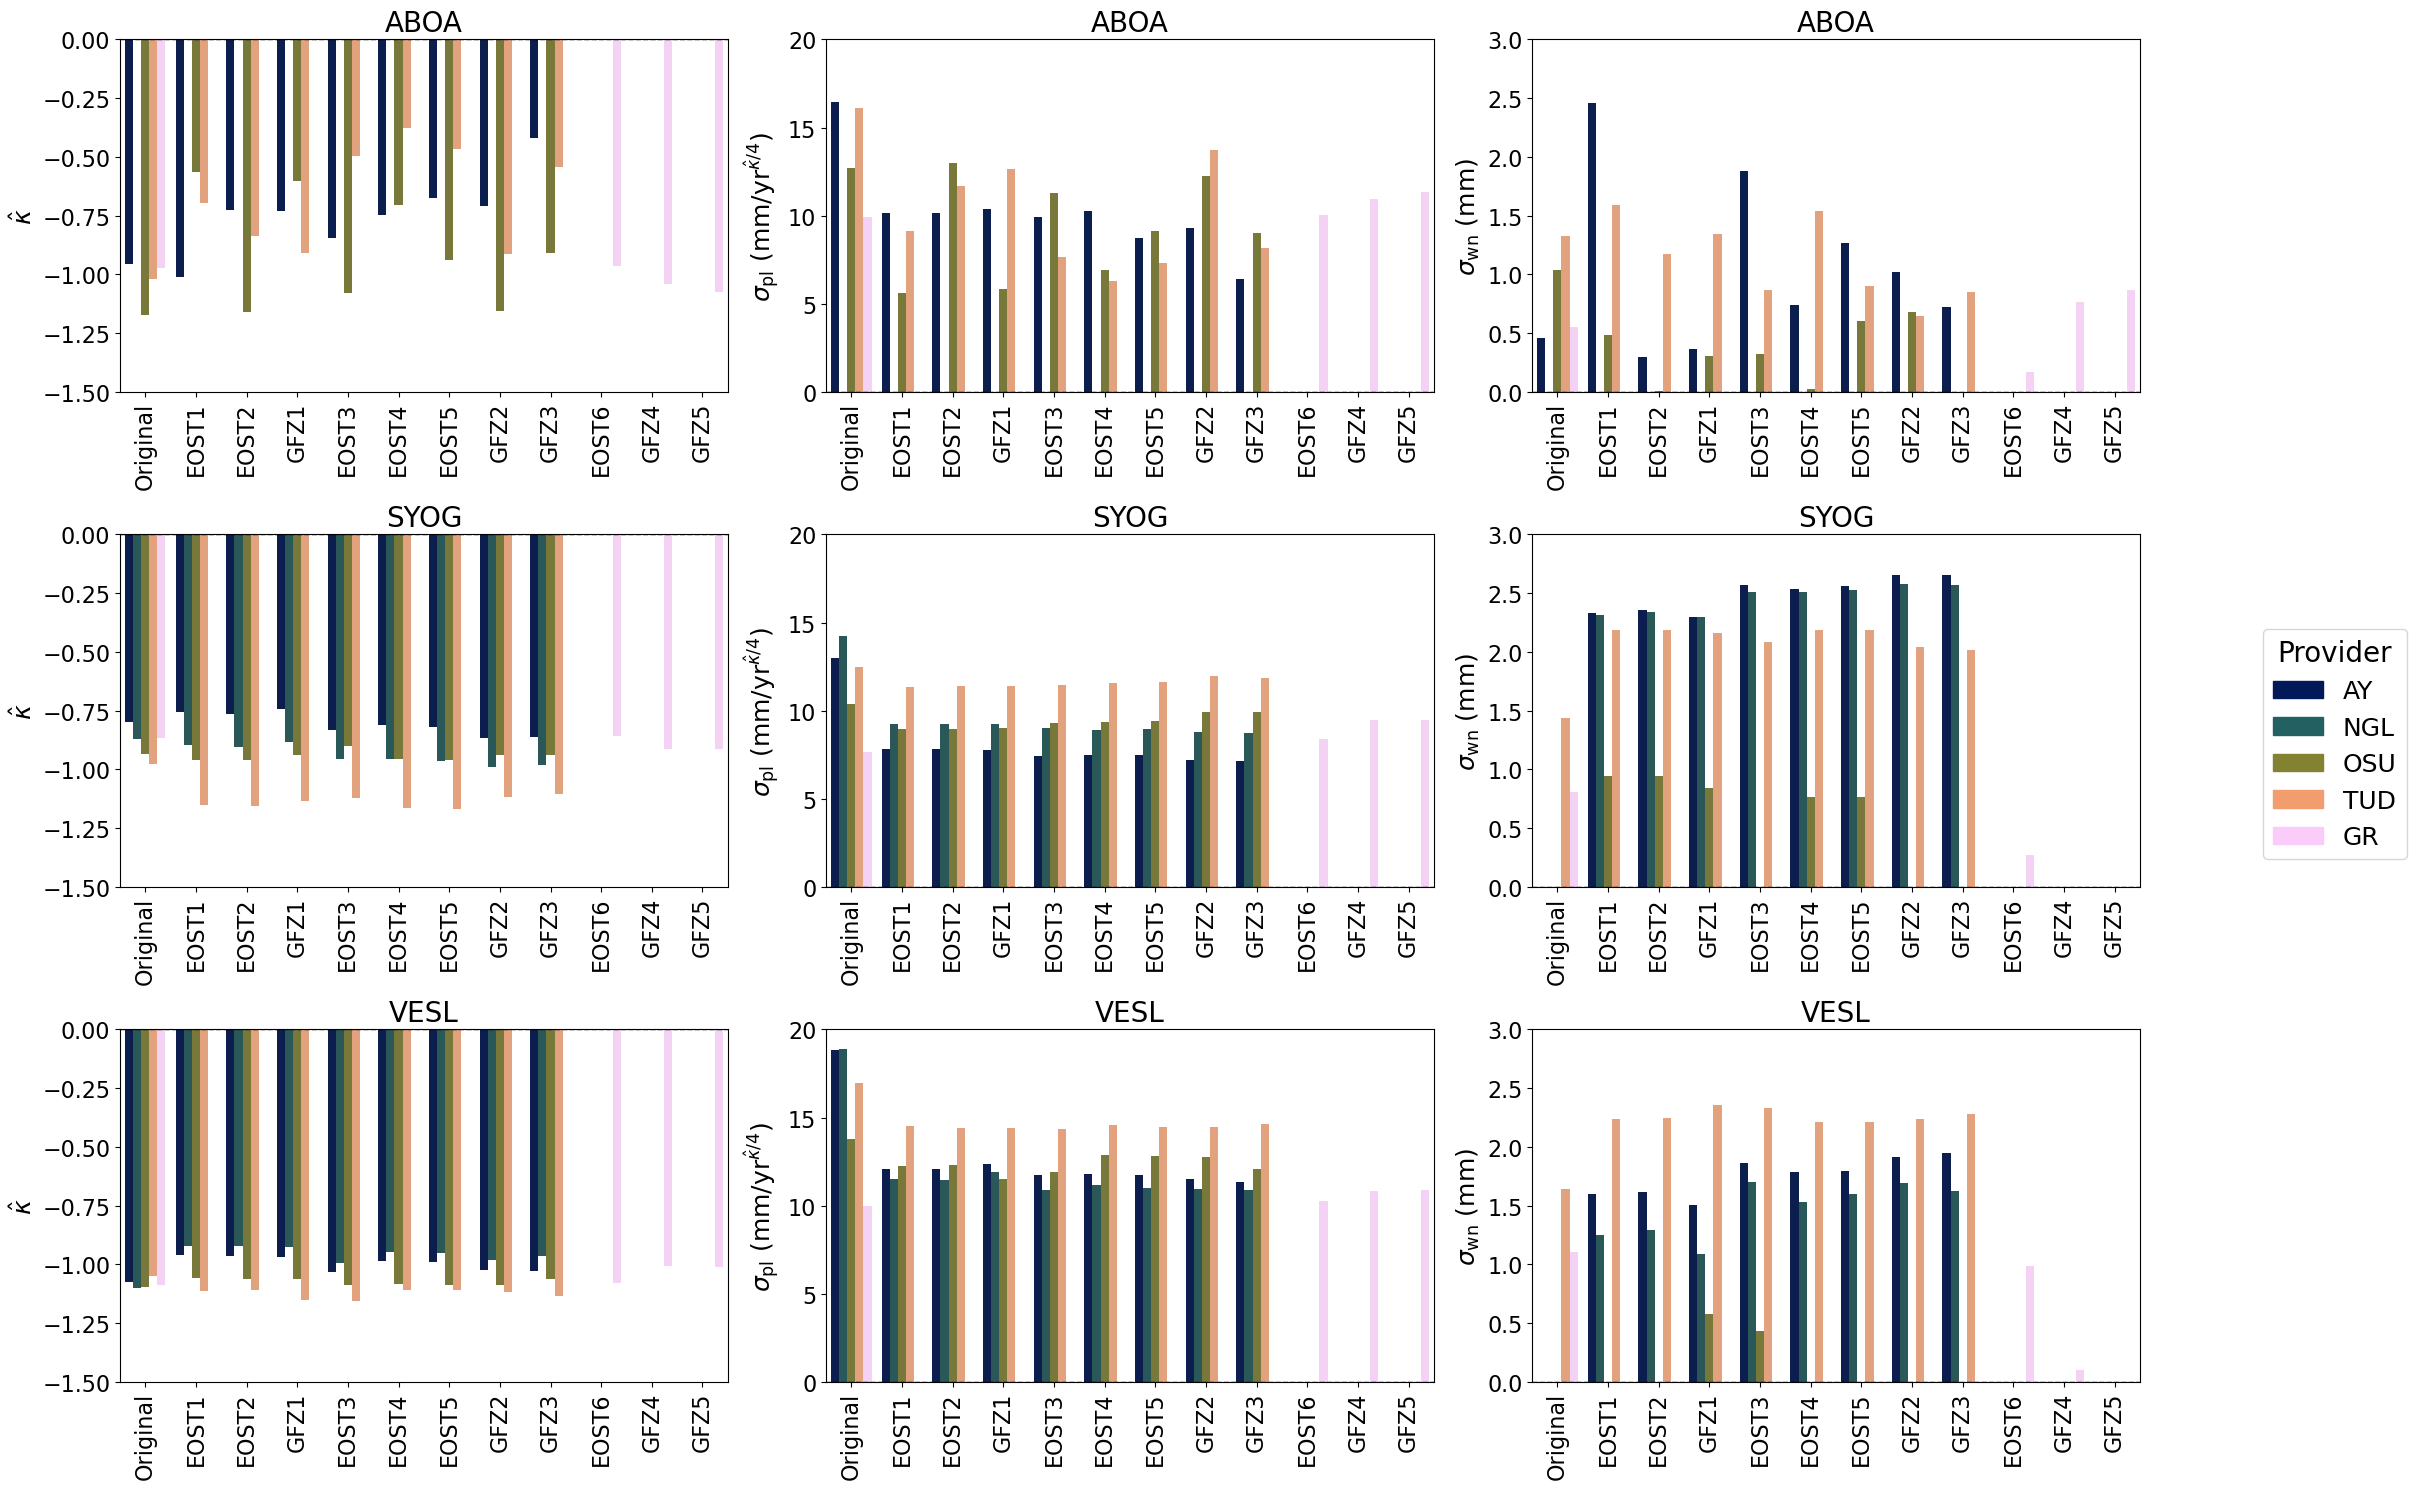

In [22]:
# Stations and noise metrics
stations = ["ABOA", "SYOG", "VESL"]
noise_metrics = [
    r'$\hat{\kappa}$',
    r'$\sigma_\mathrm{pl}$ (mm/yr$^{\hat{\kappa}/4}$)',
    r'$\sigma_\mathrm{wn}$ (mm)'
]

# Manual y-limits (adjust as needed)
manual_ylim = {
    r'$\hat{\kappa}$': (-1.5, 0),
    r'$\sigma_\mathrm{pl}$ (mm/yr$^{\hat{\kappa}/4}$)': (0, 20),
    r'$\sigma_\mathrm{wn}$ (mm)': (0, 3)
}

# Color map for providers
syog_providers = ['AY', 'NGL', 'OSU', 'TUD', 'GR']
palette = [cm.batlow(i / (len(syog_providers) - 1)) for i in range(len(syog_providers))]
color_map = dict(zip(syog_providers, palette))

# Set up figure: rows = stations, cols = noise metrics
fig, axes = plt.subplots(len(stations), len(noise_metrics), figsize=(24, 15), sharey=False)

for row_idx, station_name in enumerate(stations):
    df = hector_params[
        (hector_params["Station"] == station_name) &
        (hector_params["Component"] == "Up") &
        (hector_params["Provider"].isin(syog_providers))
    ].copy()

    if df.empty:
        print(f"Skipping {station_name}: no Up data")
        continue

    df["Correction"] = pd.Categorical(df["Correction"], categories=correction_order, ordered=True)
    df = df.sort_values(["Correction", "Provider"]).reset_index(drop=True)

    for col_idx, metric in enumerate(noise_metrics):
        ax = axes[row_idx, col_idx]

        df_plot = df[['Correction', 'Provider', metric]].copy()
        df_plot = df_plot.rename(columns={metric: 'Value'})

        sns.barplot(
            data=df_plot,
            x='Correction',
            y='Value',
            hue='Provider',
            palette=color_map,
            ax=ax,
            errorbar=None,
            dodge=True
        )

        # Formatting
        ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
        ax.set_ylim(manual_ylim[metric])
        ax.set_xlabel('', fontsize=18)
        ax.set_ylabel(metric, fontsize=18)
        ax.tick_params(axis='x', rotation=90, labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        ax.legend_.remove()
        ax.set_title(f'{station_name}', fontsize=20)

        if col_idx == 0:
            ax.set_ylabel(f'{metric}', fontsize=18)

# Unified legend
legend_handles = [mpatches.Patch(color=color_map[prov], label=prov) for prov in syog_providers]
fig.legend(
    handles=legend_handles,
    labels=syog_providers,
    loc='right',
    bbox_to_anchor=(1.01, 0.5),
    title='Provider',
    fontsize=18,
    title_fontsize=20
)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig('figures/station_comparison_noise_up.png', dpi=300, bbox_inches='tight')
plt.show()

No data for ABOA NGL


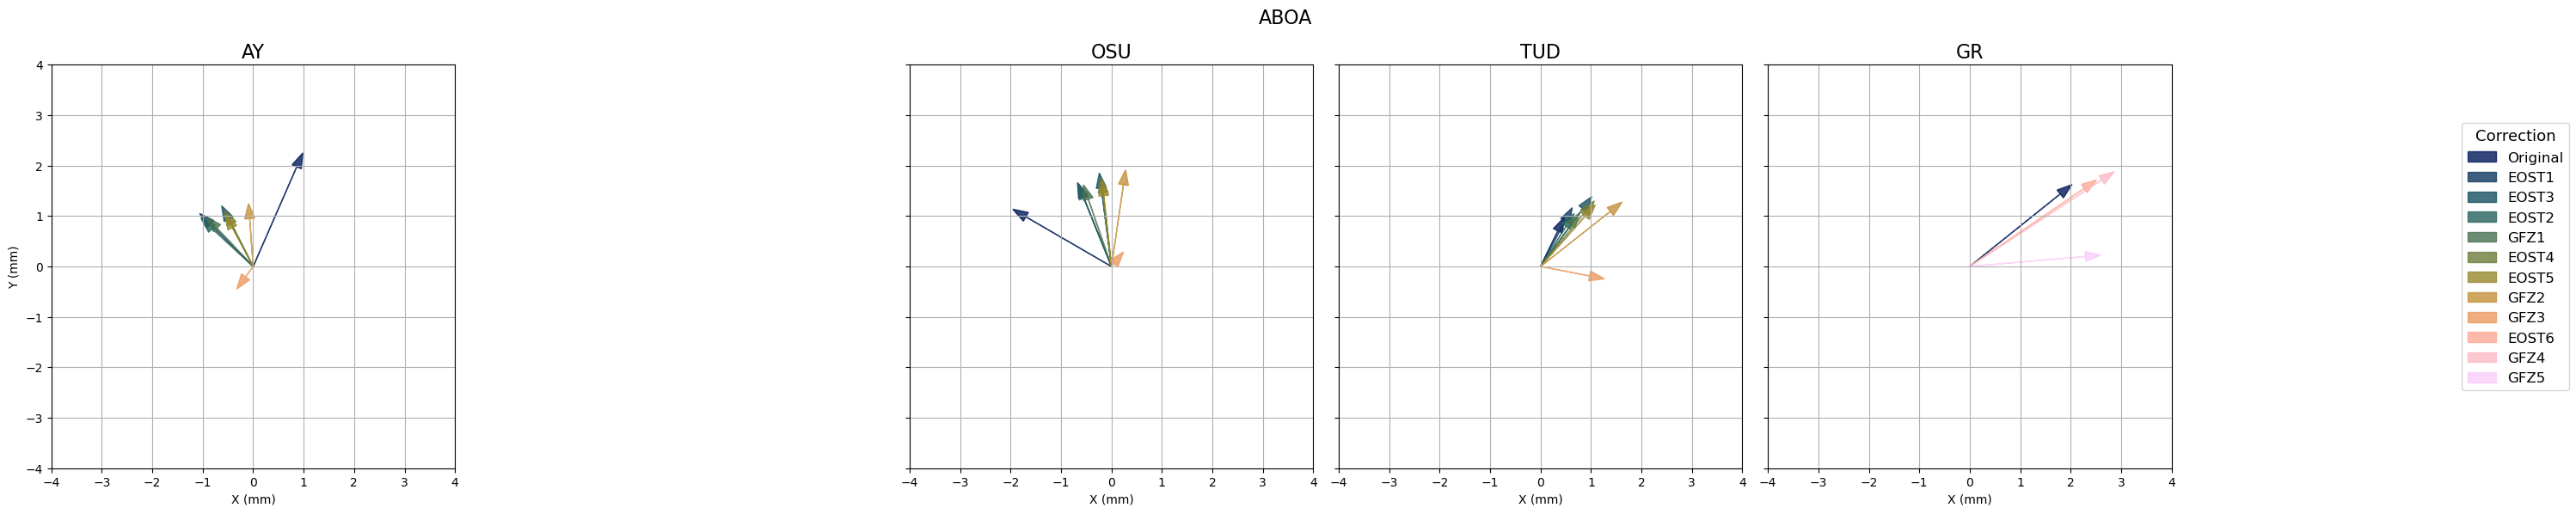

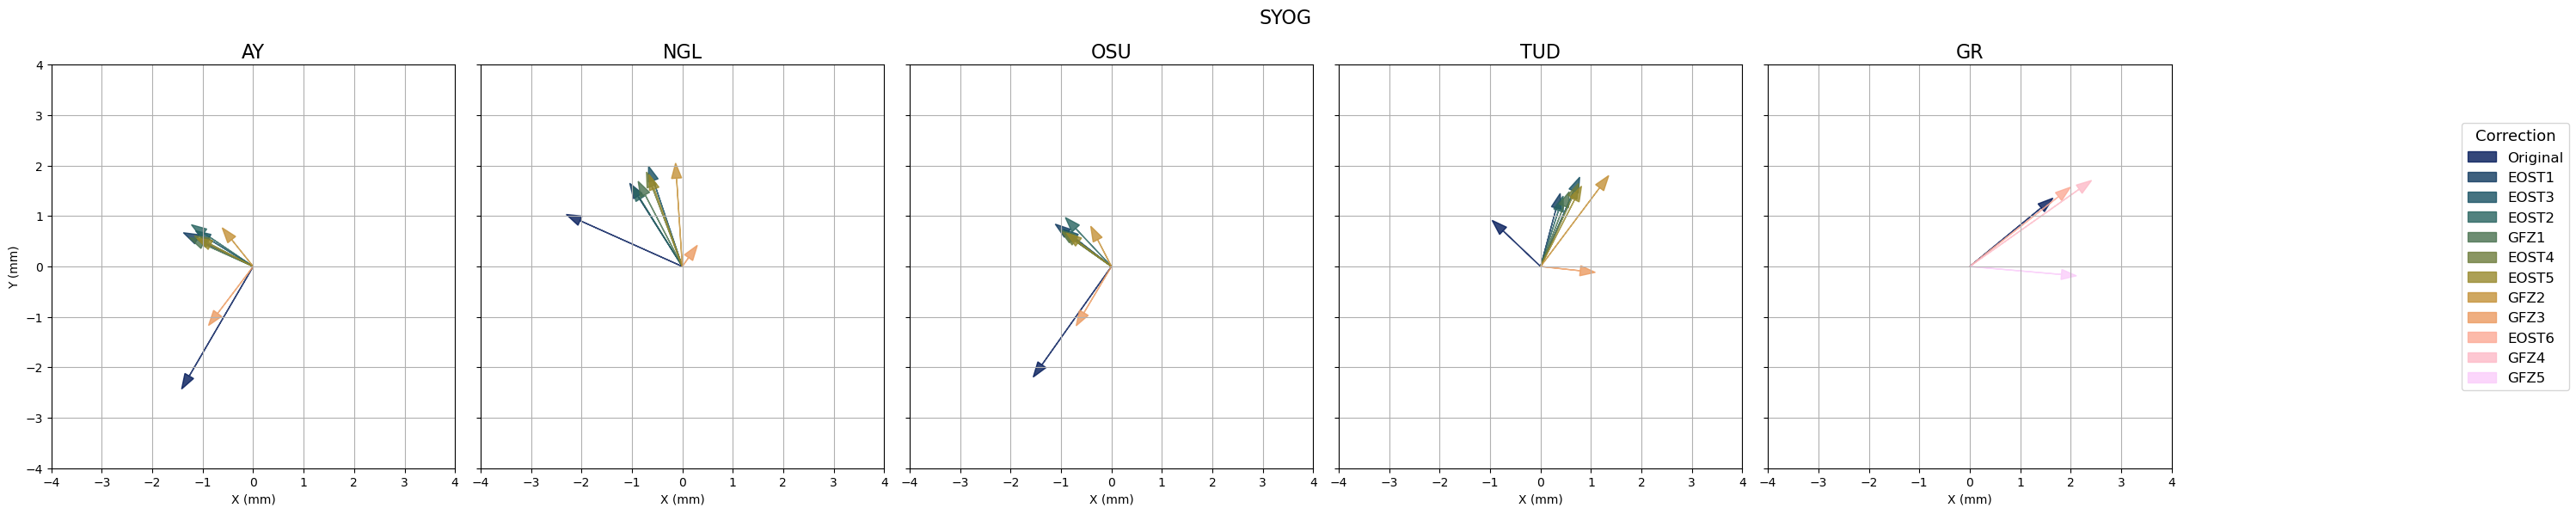

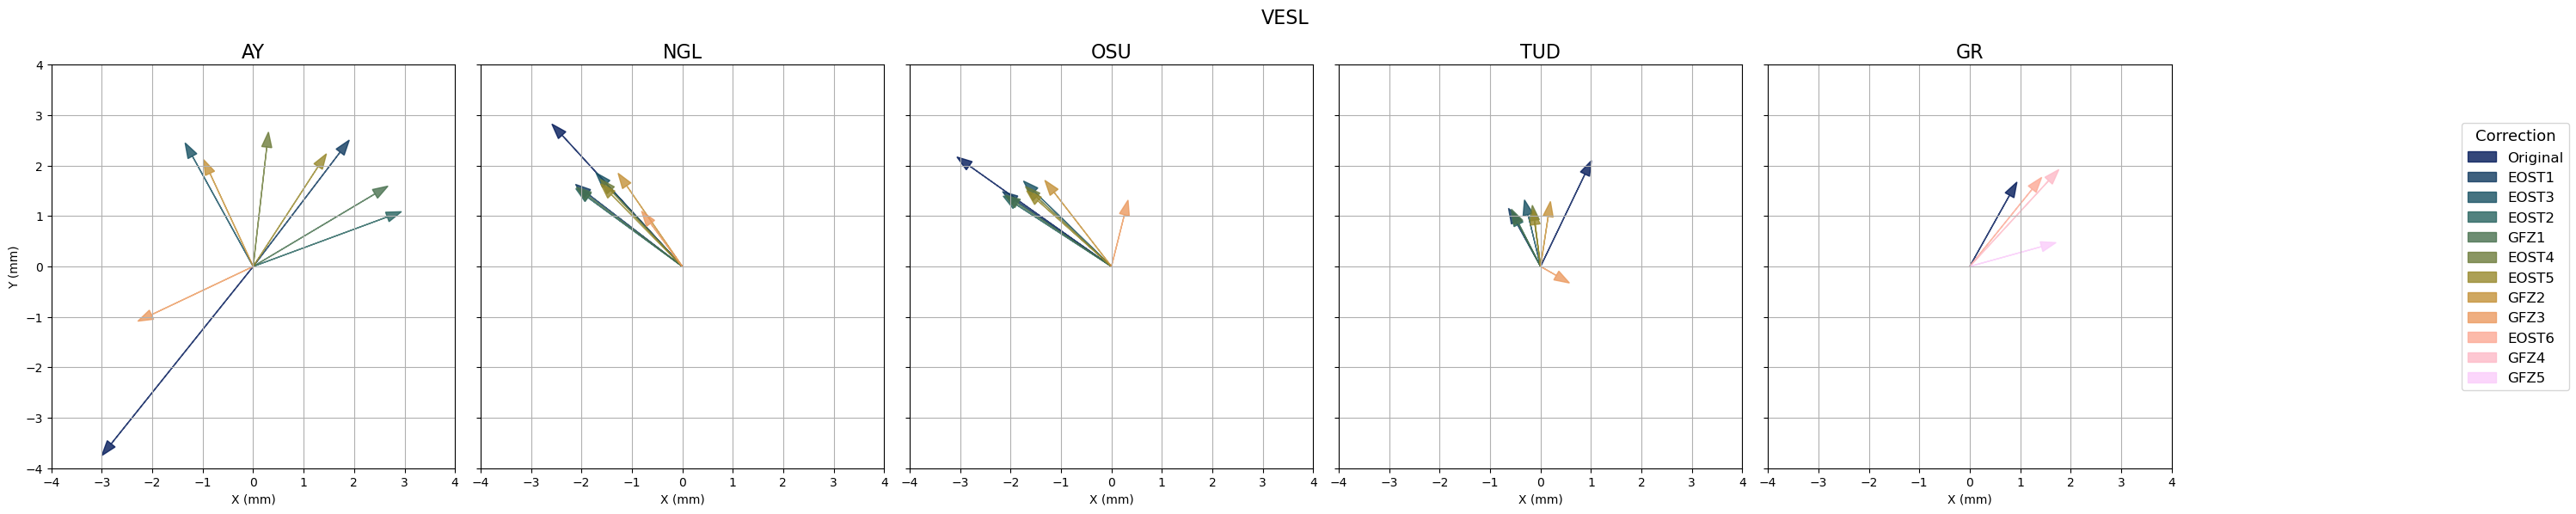

In [23]:
def plot_phase_amplitude_arrows(
    hector_params,
    stations,
    providers,
    correction_order,
    color_map,
    fig_folder="figures"
):
    n_datasets = len(providers)

    for station in stations:
        fig, axes = plt.subplots(1, len(providers), figsize=(6*len(providers), 6), sharey=True)
        if len(providers) == 1:
            axes = [axes]

        correction_handles = {}

        for ax, prov in zip(axes, providers):
            df = hector_params[
                (hector_params["Station"].str.lower() == station.lower()) &
                (hector_params["Provider"] == prov) &
                (hector_params["Component"] == "Up")
            ].copy()

            if df.empty:
                print(f"No data for {station} {prov}")
                ax.set_visible(False)  # hide this subplot
                continue

            # Ensure correction ordering
            df["Correction"] = pd.Categorical(df["Correction"], categories=correction_order, ordered=True)
            df = df.sort_values("Correction").reset_index(drop=True)

            # Plot all arrows for this provider
            for corr in correction_order:
                df_corr = df[df["Correction"] == corr]
                for _, row in df_corr.iterrows():
                    amp = row["Annual Amp (mm)"]
                    phase_deg = row["phase"]
                    theta = np.deg2rad(phase_deg)
                    arrow = ax.arrow(
                        0, 0,
                        amp * np.cos(theta),
                        amp * np.sin(theta),
                        color=color_map[corr],
                        alpha=0.8,
                        head_width=0.2,
                        length_includes_head=True
                    )
                    # save handle for legend
                    if corr not in correction_handles:
                        correction_handles[corr] = arrow

            ax.set_title(prov.upper(), fontsize=16)
            ax.set_xlim(-4, 4)
            ax.set_ylim(-4, 4)
            ax.set_xlabel("X (mm)")
            if ax == axes[0]:
                ax.set_ylabel("Y (mm)")
            ax.grid(True)
            ax.set_aspect('equal')

        # Unified legend
        handles = [correction_handles[c] for c in correction_order if c in correction_handles]
        labels = [c for c in correction_order if c in correction_handles]
        fig.legend(handles, labels, title="Correction", loc="center right", fontsize=12, title_fontsize=13)

        fig.suptitle(station.upper(), fontsize=16)
        plt.tight_layout(rect=[0, 0, 0.85, 1])

        # Save figure
        fig_path = os.path.join(fig_folder, f"{station}_phase_amplitude_up.png")
        plt.savefig(fig_path, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close(fig)

correction_map = {
    'Original': '00',
    'EOST1': '04',
    'EOST3': '05',
    'EOST2': '06',
    'GFZ1': '07',
    'EOST4': '08',
    'EOST5': '09',
    'GFZ2': '10',
    'GFZ3': '11',
    'EOST6': '01',
    'GFZ4': '02',
    'GFZ5': '03'
}

plot_phase_amplitude_arrows(
    hector_params,
    stations=["ABOA", "SYOG", "VESL"],
    providers=["AY", "NGL", "OSU", "TUD", "GR"],
    correction_order=list(correction_map.keys()),
    color_map={k: cm.batlow(i / (len(correction_map)-1)) for i, k in enumerate(correction_map)},
    fig_folder="figures"
)

## 3. RMS and WRMS

In [24]:
# Load DataFrame with RMS and WRMS values
rms_df =  pd.read_csv('rms_wrms_results.csv')

rms_df.head()

station dataset correction component       rms  rms_change_%      wrms  \
0    ABOA      GR   Original         e  0.941946      0.000000  0.011717   
1    ABOA      GR   Original         n  1.232293      0.000000  0.015119   
2    ABOA      GR   Original         u  3.336985      0.000000  0.040863   
3    ABOA      GR   Original     total  3.679848      0.000000  0.023886   
4    ABOA      GR      EOST6         e  0.943077     -0.120024  0.011721   

   wrms_change_%  
0       0.000000  
1       0.000000  
2       0.000000  
3       0.000000  
4      -0.033816

In [25]:
# Define desired correction and provider orders 
correction_order = [
    'Original', 'EOST1', 'EOST2', 'GFZ1', 'EOST3', 'EOST4', 'EOST5',
    'GFZ2', 'GFZ3', 'EOST6', 'GFZ4', 'GFZ5'
]

provider_order = ['AY', 'NGL', 'OSU', 'TUD', 'GR']

# Apply categorical sorting
rms_df['correction'] = pd.Categorical(rms_df['correction'], categories=correction_order, ordered=True)
rms_df['dataset'] = pd.Categorical(rms_df['dataset'], categories=provider_order, ordered=True)
rms_df.sort_values(['correction', 'dataset'], inplace=True)

# Print present values (not full category list) 
print("Correction values:", rms_df['correction'].dropna().unique().tolist())
print("Provider values:", rms_df['dataset'].dropna().unique().tolist())


Correction values: ['Original', 'EOST1', 'EOST2', 'GFZ1', 'EOST3', 'EOST4', 'EOST5', 'GFZ2', 'GFZ3', 'EOST6', 'GFZ4', 'GFZ5']
Provider values: ['AY', 'NGL', 'OSU', 'TUD', 'GR']


### a) RMS

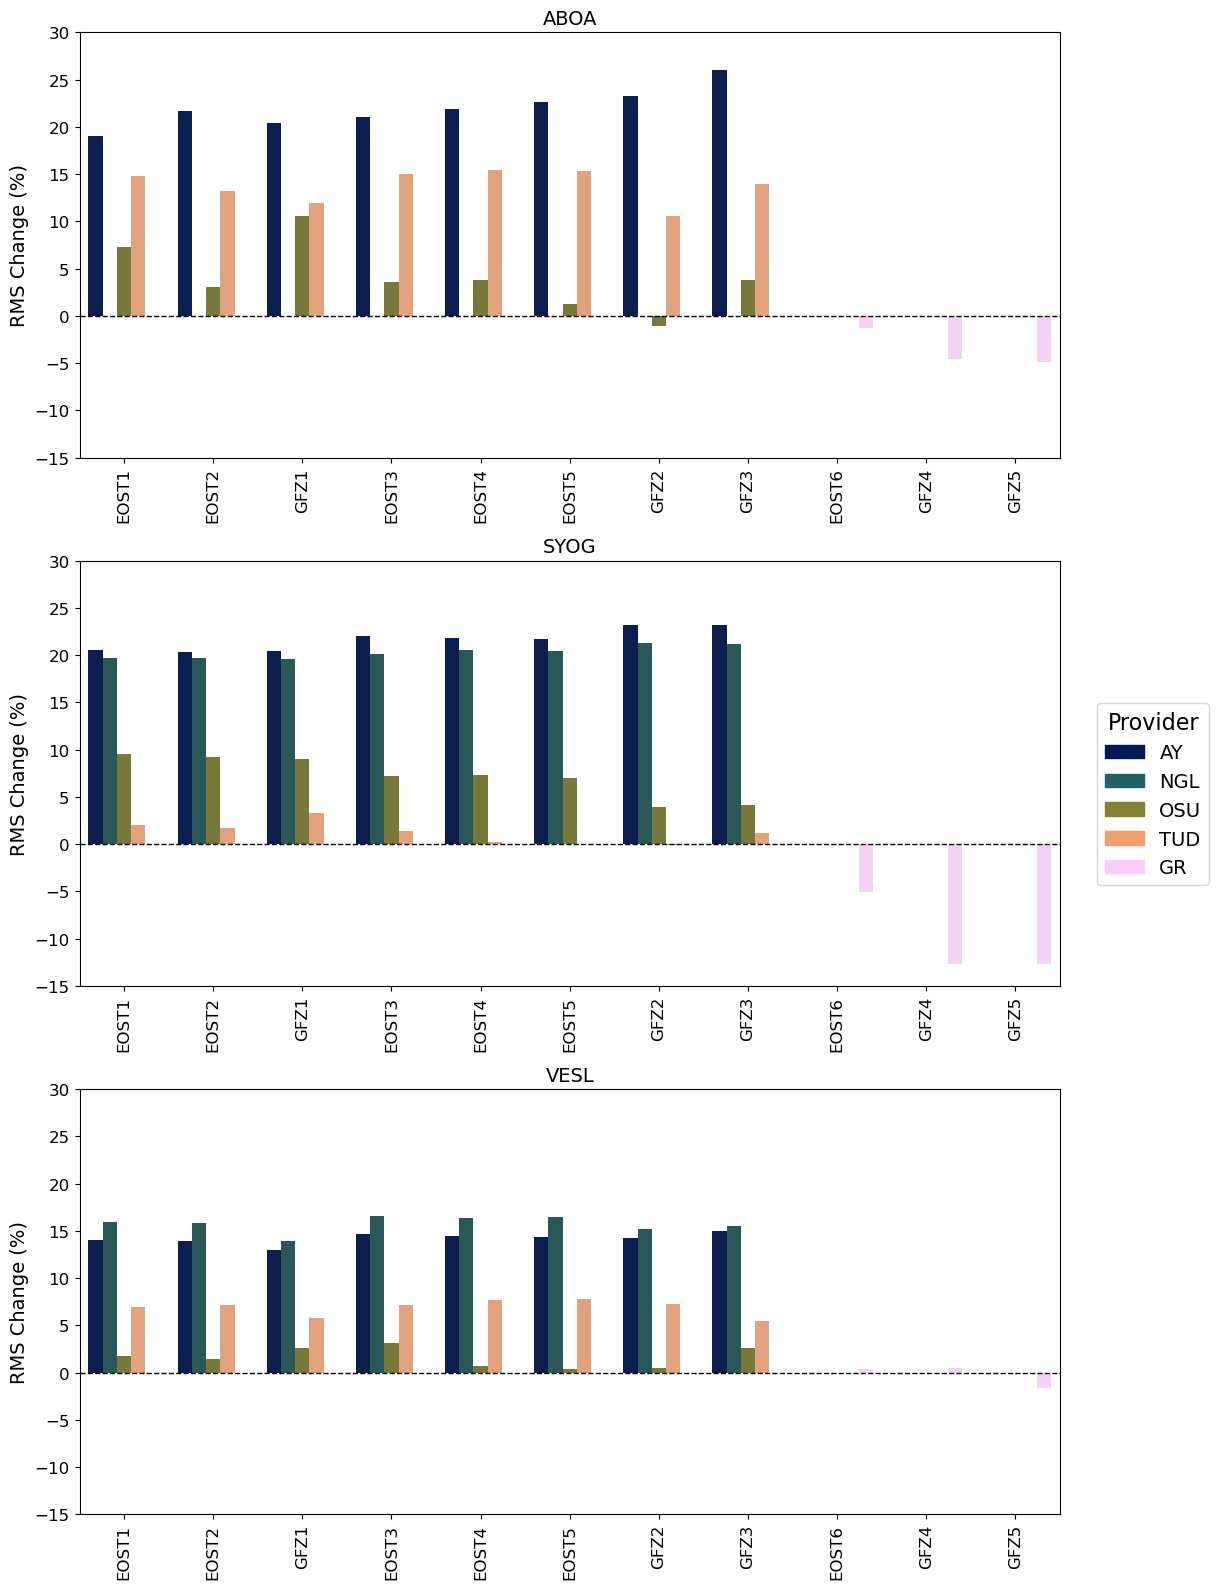

In [26]:
# Filter for Up component & remove 'orig' 
rms_up = rms_df[
    (rms_df['component'].str.lower() == 'u') &
    (rms_df['correction'] != 'Original')
].copy()

# Standardize column values
rms_up['Station'] = rms_up['station'].str.upper()
rms_up['Provider'] = rms_up['dataset'].str.upper()
rms_up['Correction'] = rms_up['correction']

# Custom correction order: move key corrections to end 
priority_end = ['EOST6', 'GFZ4', 'GFZ5']
all_corrections = rms_up['Correction'].unique().tolist()
custom_order = [c for c in all_corrections if c not in priority_end] + priority_end
rms_up['Correction'] = pd.Categorical(rms_up['Correction'], categories=custom_order, ordered=True)

# Custom provider color order 
desired_order = ['AY', 'NGL', 'OSU', 'TUD', 'GR']
rms_up = rms_up[rms_up['Provider'].isin(desired_order)]
rms_up['Provider'] = pd.Categorical(rms_up['Provider'], categories=desired_order, ordered=True)

palette = [cm.batlow(i / (len(desired_order) - 1)) for i in range(len(desired_order))]
provider_color_map = dict(zip(desired_order, palette))

# Plotting 
fig, axes = plt.subplots(3, 1, figsize=(12, 16), sharex=False)

for ax, station in zip(axes, ['ABOA', 'SYOG', 'VESL']):
    df = rms_up[rms_up['Station'] == station]

    sns.barplot(
        data=df,
        x='Correction',
        y='rms_change_%',
        hue='Provider',
        palette=provider_color_map,
        ax=ax,
        dodge=True,
        errorbar=None
    )

    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.set_title(f'{station}', fontsize=14)
    ax.set_ylabel('RMS Change (%)', fontsize=14)
    ax.set_xlabel('')
    ax.set_ylim(-15, 30)
    ax.tick_params(axis='x', rotation=90, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend_.remove()

# Global legend 
handles = [mpatches.Patch(color=provider_color_map[p], label=p) for p in desired_order]
fig.legend(
    handles=handles,
    title='Provider',
    loc='right',
    bbox_to_anchor=(1.02, 0.5),
    fontsize=14,
    title_fontsize=16
)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig('figures/rms_up_summary.png', dpi=300, bbox_inches='tight')
plt.show()


### b) WRMS

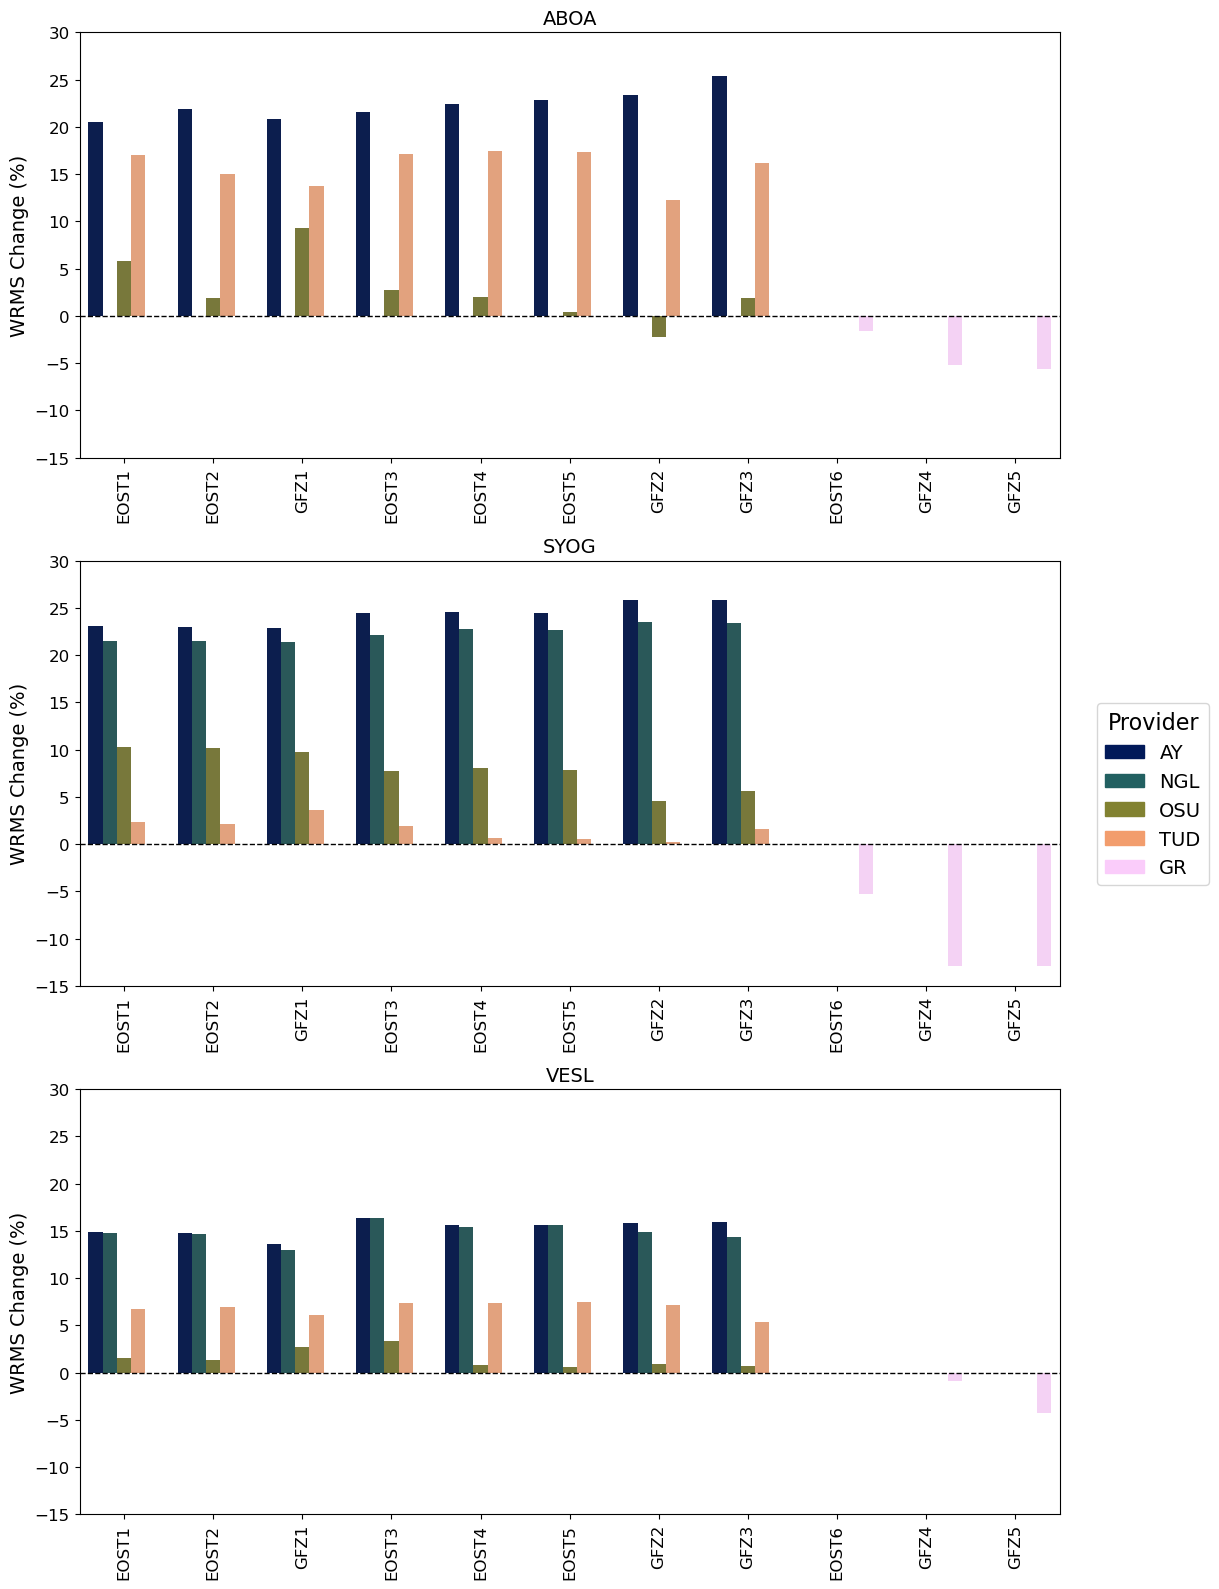

In [27]:
# Filter for Up component & remove 'orig' 
rms_up = rms_df[
    (rms_df['component'].str.lower() == 'u') &
    (rms_df['correction'] != 'Original')
].copy()

# Standardize column values
rms_up['Station'] = rms_up['station'].str.upper()
rms_up['Provider'] = rms_up['dataset'].str.upper()
rms_up['Correction'] = rms_up['correction']

# Custom correction order: move key corrections to end 
priority_end = ['EOST6', 'GFZ4', 'GFZ5']
all_corrections = rms_up['Correction'].unique().tolist()
custom_order = [c for c in all_corrections if c not in priority_end] + priority_end
rms_up['Correction'] = pd.Categorical(rms_up['Correction'], categories=custom_order, ordered=True)

# Custom provider color order 
desired_order = ['AY', 'NGL', 'OSU', 'TUD', 'GR']
rms_up = rms_up[rms_up['Provider'].isin(desired_order)]
rms_up['Provider'] = pd.Categorical(rms_up['Provider'], categories=desired_order, ordered=True)

palette = [cm.batlow(i / (len(desired_order) - 1)) for i in range(len(desired_order))]
provider_color_map = dict(zip(desired_order, palette))

# Plotting 
fig, axes = plt.subplots(3, 1, figsize=(12, 16), sharex=False)

for ax, station in zip(axes, ['ABOA', 'SYOG', 'VESL']):
    df = rms_up[rms_up['Station'] == station]

    sns.barplot(
        data=df,
        x='Correction',
        y='wrms_change_%',
        hue='Provider',
        palette=provider_color_map,
        ax=ax,
        dodge=True,
        errorbar=None
    )

    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.set_title(f'{station}', fontsize=14)
    ax.set_ylabel('WRMS Change (%)', fontsize=14)
    ax.set_xlabel('')
    ax.set_ylim(-15, 30)
    ax.tick_params(axis='x', rotation=90, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend_.remove()

# Global legend 
handles = [mpatches.Patch(color=provider_color_map[p], label=p) for p in desired_order]
fig.legend(
    handles=handles,
    title='Provider',
    loc='right',
    bbox_to_anchor=(1.02, 0.5),
    fontsize=14,
    title_fontsize=16
)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig('figures/wrms_up_summary.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. PSD Plots

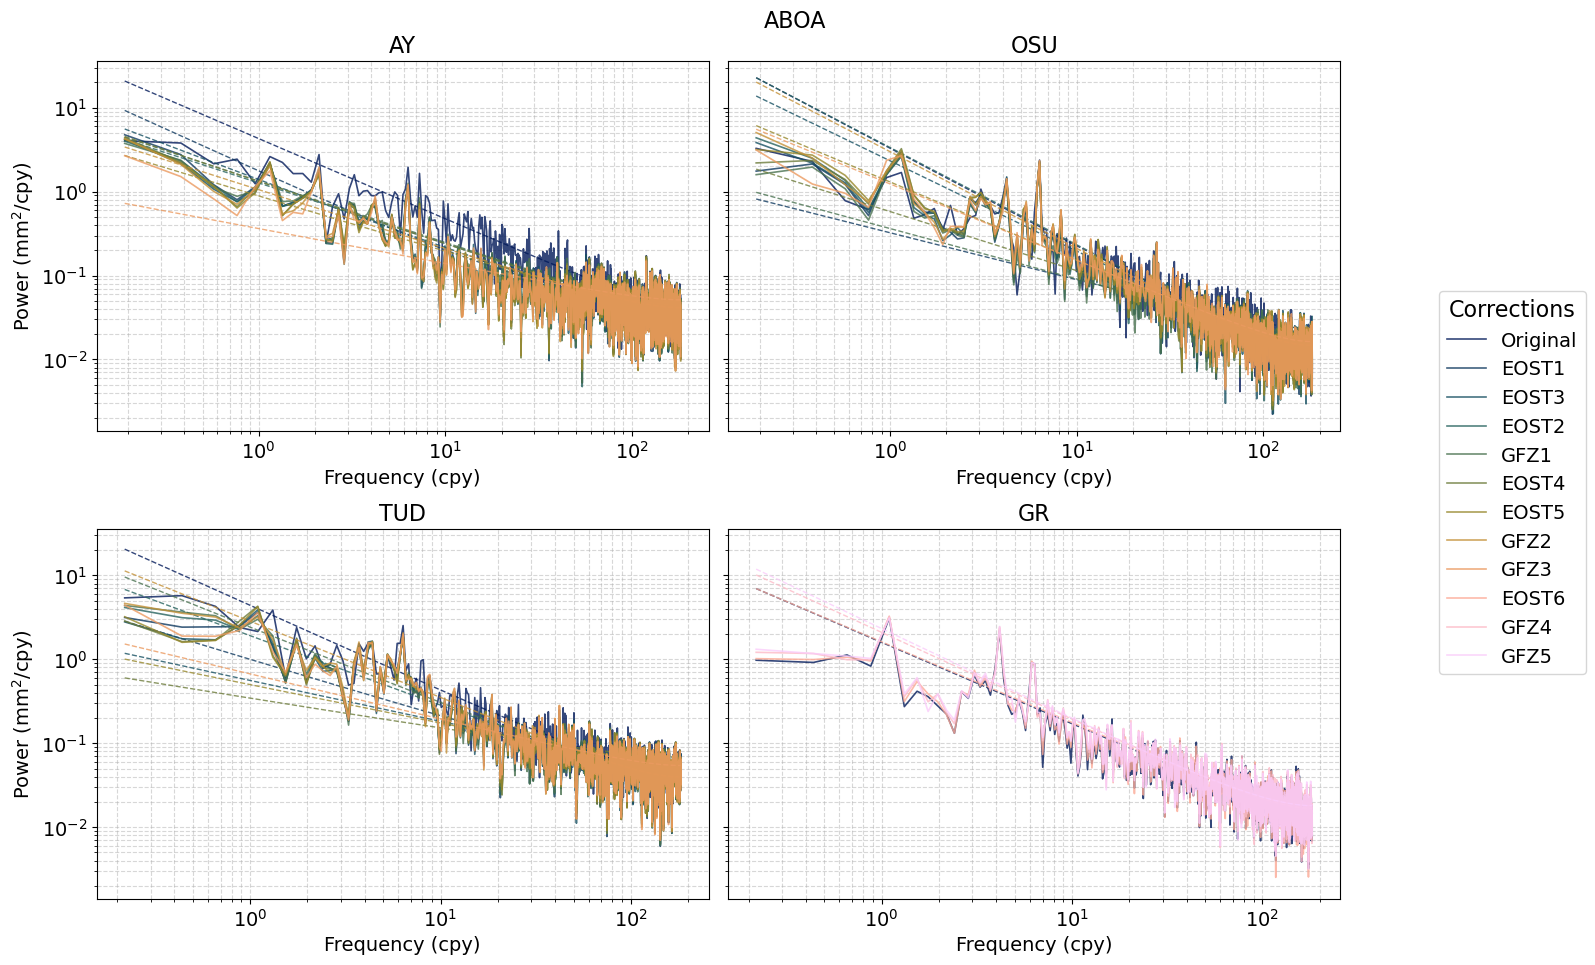

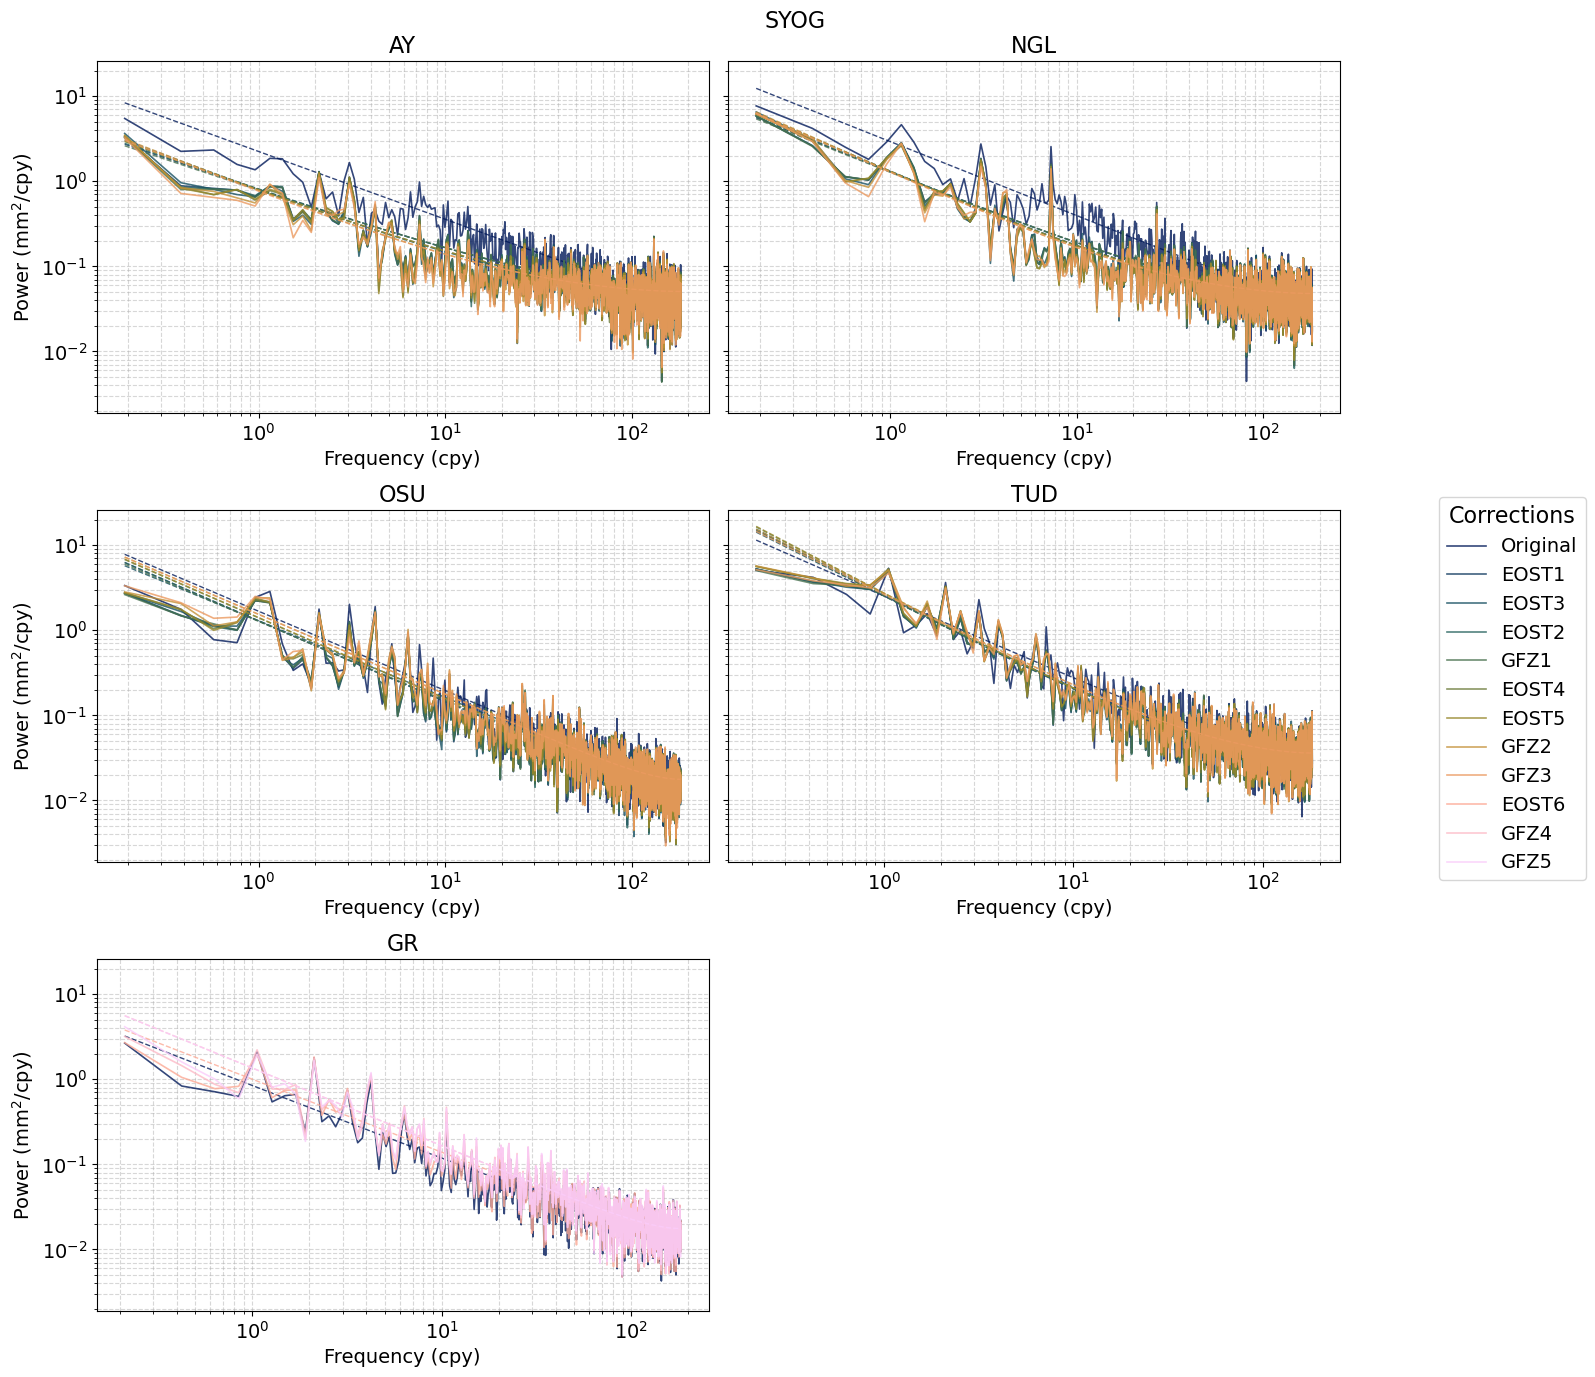

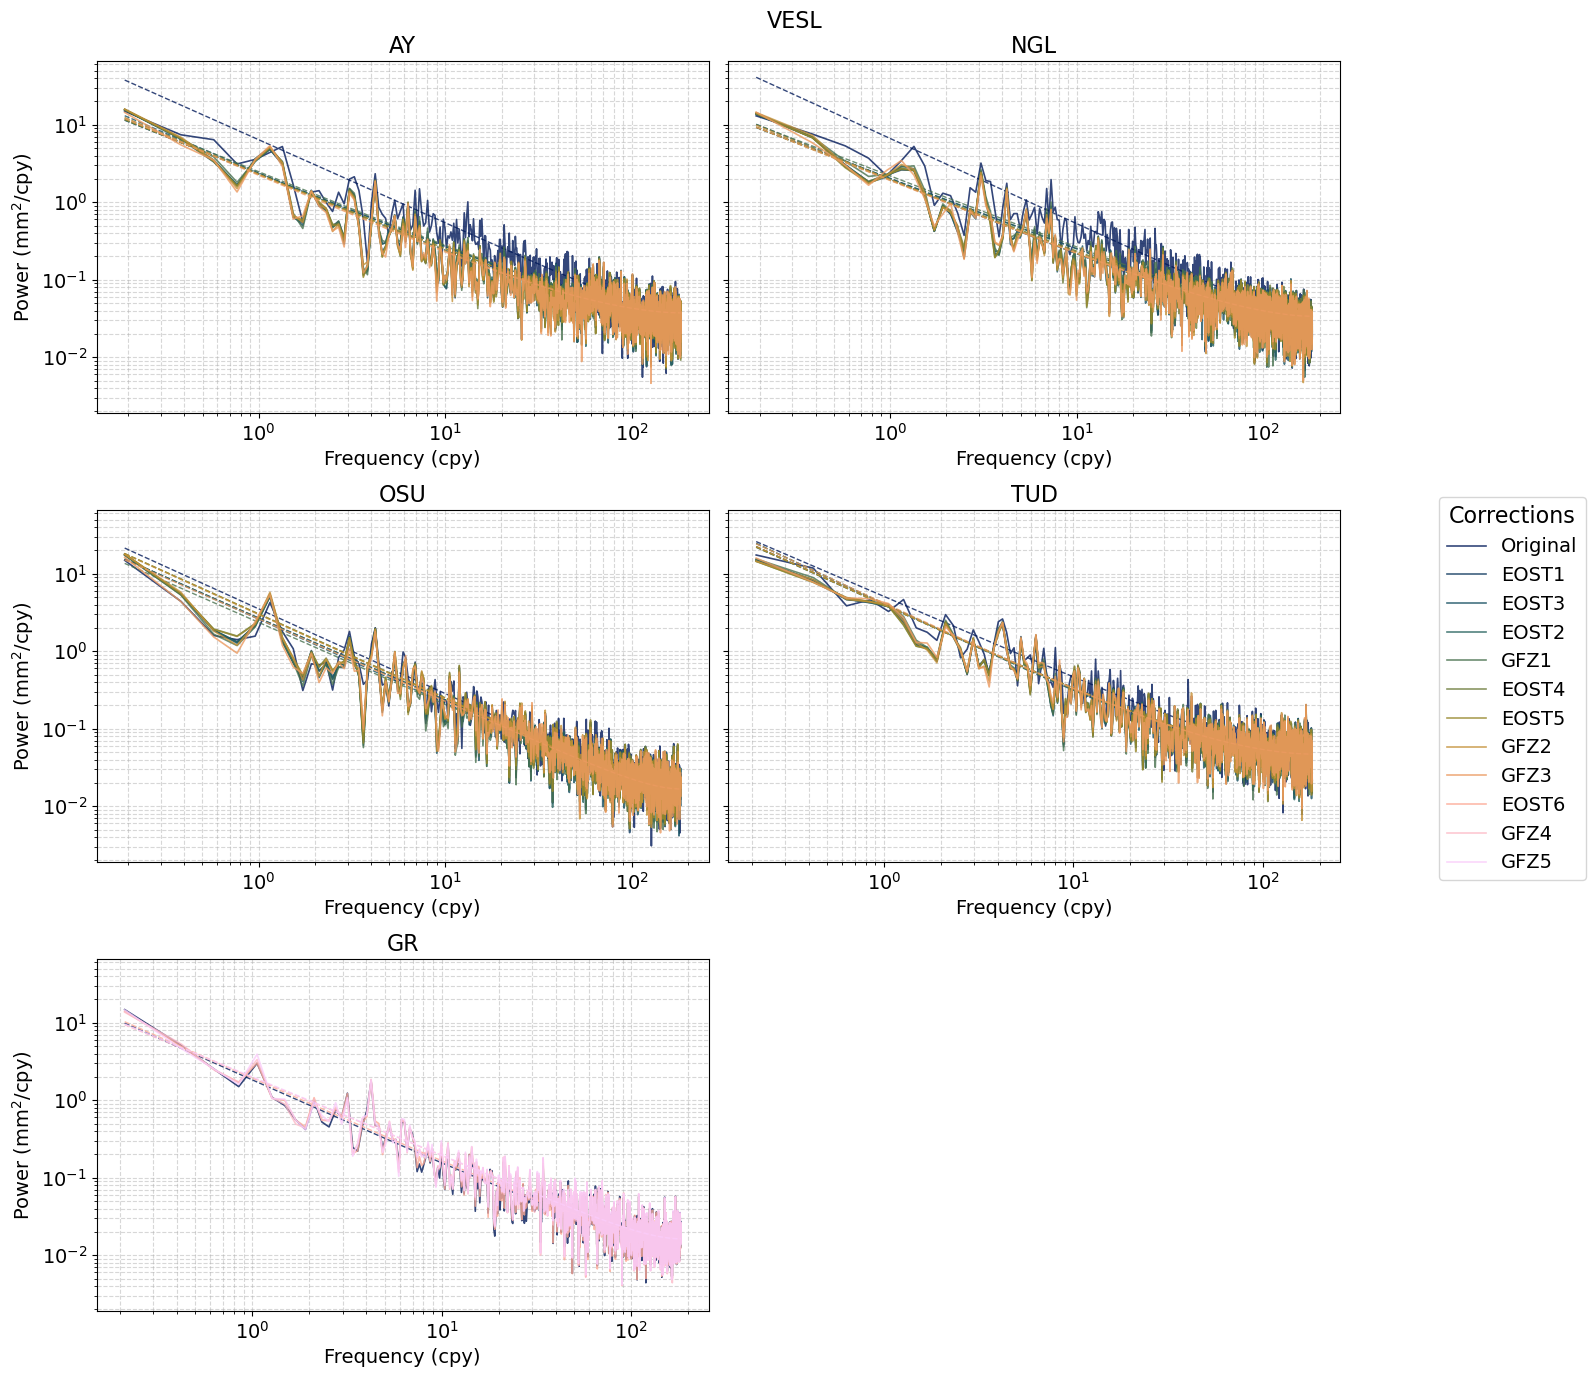

In [28]:
# How the files are named
station_map = {
    'aboa': 'A',
    'syog': 'S',
    'vesl': 'V'
}
dataset_map = {
    'gr': 'G',
    'ngl': 'N',
    'tud': 'T',
    'osu': 'O',
    'ay': 'A'
}
correction_map = {
    'Original': '00',
    'EOST1': '04',
    'EOST3': '05',
    'EOST2': '06',
    'GFZ1': '07',
    'EOST4': '08',
    'EOST5': '09',
    'GFZ2': '10',
    'GFZ3': '11',
    'EOST6': '01',
    'GFZ4': '02',
    'GFZ5': '03'
}

# Settings
psd_folder = "hector/psd_figures"
fig_folder = "figures"
comp = "2"  # Up component
datasets = ["ay", "ngl", "osu", "tud", "gr"]  # fixed order
corrections = list(correction_map.items())

# Create palette: fixed color per correction
palette = [cm.batlow(i / (len(corrections) - 1)) for i in range(len(corrections))]

# Looping over stations
for station, st_code in station_map.items():
    fig, axes = plt.subplots(3, 2, figsize=(16, 14), sharey=True)
    axes = axes.flatten()

    plotted_axes = []
    ax_idx = 0
    correction_handles = {}  # store one handle per correction

    for dataset in datasets:
        # Skip NGL for ABOA
        if station == "aboa" and dataset == "ngl":
            continue

        ds_code = dataset_map[dataset]
        ax = axes[ax_idx]
        ax_idx += 1

        dataset_plotted = False

        for i, (corr_name, corr_id) in enumerate(corrections):
            # PSD estimate file
            fname_est = f"{st_code}{ds_code}{corr_id}_{comp}_estimate.txt"
            fpath_est = os.path.join(psd_folder, fname_est)

            # PSD model file
            fname_model = f"{st_code}{ds_code}{corr_id}_{comp}_model.txt"
            fpath_model = os.path.join(psd_folder, fname_model)

            # Load and plot estimate (solid line)
            if os.path.exists(fpath_est):
                data_est = np.loadtxt(fpath_est, comments="#")
                if data_est.ndim == 1:
                    data_est = data_est[np.newaxis, :]

                sec_per_year = 365.25 * 24 * 3600
                freq = data_est[:, 0] * sec_per_year  # cycles/year
                psd  = data_est[:, 1] / sec_per_year  
                mask = (freq > 0) & (psd > 0)
                if mask.sum() > 0:
                    line, = ax.loglog(
                        freq[mask], psd[mask],
                        color=palette[i], alpha=0.8, lw=1.2,
                        label=corr_name if corr_name not in correction_handles else None
                    )
                    if corr_name not in correction_handles:
                        correction_handles[corr_name] = line
                    dataset_plotted = True

            # Load and plot model (dashed line, no label)
            if os.path.exists(fpath_model):
                data_model = np.loadtxt(fpath_model, comments="#")
                if data_model.ndim == 1:
                    data_model = data_model[np.newaxis, :]
                freq_m = data_model[:, 0] * sec_per_year
                psd_m  = data_model[:, 1] / sec_per_year  
                mask_m = (freq_m > 0) & (psd_m > 0)
                if mask_m.sum() > 0:
                    ax.loglog(
                        freq_m[mask_m], psd_m[mask_m],
                        color=palette[i], alpha=0.8, lw=1.0, ls="--"
                    )
                    dataset_plotted = True


        if dataset_plotted:
            ax.set_title(dataset.upper(), fontsize=16)
            ax.set_xlabel("Frequency (cpy)", fontsize=14)
            ax.tick_params(axis='both', which='major', labelsize=14)
            ax.tick_params(axis='both', which='minor', labelsize=14)
            ax.grid(True, which="both", ls="--", alpha=0.5)
            if ax_idx % 2 == 1:  # left column only
                ax.set_ylabel("Power (mm$^2$/cpy)", fontsize=14)
            plotted_axes.append(ax)
        else:
            fig.delaxes(ax)

    # Remove unused axes
    for j in range(ax_idx, len(axes)):
        fig.delaxes(axes[j])

    # Legend: keep order of `corrections`
    if correction_handles:
        handles = [correction_handles[corr_name] for corr_name, _ in corrections if corr_name in correction_handles]
        labels = [corr_name for corr_name, _ in corrections if corr_name in correction_handles]
        fig.legend(handles, labels, title="Corrections", loc="center right", fontsize=14, title_fontsize=16)

    fig.suptitle(f"{station.upper()}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    
    # Save figure
    fig_path = os.path.join(fig_folder, f"{station}_PSD_up.png")
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.show(fig)
    plt.close(fig)
